In [35]:
from PIL import Image
import cv2 as cv
import os
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
import wandb
import torch.nn as nn
import time
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [36]:
config = {
    'data_root': 'kaggle/',
    'seed': 2022,
    'train_batch_size':16,
    'val_batch_size':16,
    
}

In [37]:
# dataset_prprocessing
def set_seed(seed=42, loader=None):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
        loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass

def read_data(path:str, increase_factor: int):
    # read all data
    data_list = []
    for l in os.listdir(path):
        if l.endswith('.jpg'):
            data_list.append(l)
    random.shuffle(data_list)

    num_files = len(data_list)

    train_list = data_list[:int(num_files*0.8)]
    val_list = data_list[int(num_files*0.8):int(num_files*0.9)]
    test_list = data_list[int(num_files*0.9):]

    # increase data
    train_list *= increase_factor
    val_list *= increase_factor

    return train_list, val_list, test_list


# set_seed(config['seed'])
train_list, val_list, test_list = read_data(config['data_root']+'image/', increase_factor = 1)


In [38]:
# data loader

class Fingernails(Dataset):
    def __init__(self, config, data_list, transform):
        super().__init__()
        # print(self.datas)
        self.config = config
        self.transform = transform
        self.data_list = data_list
        self.total_len = len(self.data_list)
        print("train num: ", self.total_len)
        self.trans = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])

    def __len__(self):
        return self.total_len
    

    def __getitem__(self, idx):
        img_path  = self.data_list[idx]
        image_path = config['data_root']+'image/' + img_path
        mask_path = config['data_root']+'label/' + img_path
        img, gt_mask = self.get_data(image_path, mask_path)
     
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=gt_mask)
            img, gt_mask = augmentations['image'], augmentations['mask']
            img = self.trans(img)
            gt_mask = torch.Tensor(gt_mask)
            # img = img.permute((2, 0, 1))
        return img, gt_mask
    
    def get_data(self, img_path, mask_path):
        assert os.path.exists(img_path) and os.path.exists(mask_path)
        img = cv.imread(img_path)
        mask = cv.imread(mask_path, 0)
        # try:
        #     print(img.shape)
        # except:
        #     print(img_path)
        return img, mask




In [39]:
class MDataModule():
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.train_batch_size = config['train_batch_size']
        self.val_batch_size = config['val_batch_size']

        self.train_transform = A.Compose(
        [   
            A.SmallestMaxSize(max_size=512),
            A.RandomCrop(width=256, height=256),
            A.Rotate(limit=40, p=0.5, border_mode=cv.BORDER_CONSTANT),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.1),
            A.OneOf([
                A.Blur(blur_limit=3, p=0.2),
                A.ColorJitter(p=0.2),
            ], p=0.3),
        ])


        self.val_transform = A.Compose(
        [   
            A.SmallestMaxSize(max_size=512),
            A.RandomCrop(width=256, height=256),
            # A.HorizontalFlip(p=0.5),
            # A.VerticalFlip(p=0.1),
            # A.OneOf([
            #     A.Blur(blur_limit=3, p=0.2),
            #     A.ColorJitter(p=0.2),
            # ], p=0.3),
        ])

        self.setup()

    def setup(self):
        self.train_list, self.val_list, self.test_list = read_data(config['data_root']+'image/', increase_factor = config['increase_factor'])


    def train_dataloader(self):
        train_dataset = Fingernails(self.config, self.train_list, transform=self.train_transform)

        return DataLoader(train_dataset, batch_size=self.train_batch_size, num_workers=0,
                              shuffle=True, drop_last=False)

    def val_dataloader(self):
        val_dataset = Fingernails(self.config, self.val_list, transform=self.val_transform)

        return DataLoader(val_dataset, batch_size=self.val_batch_size, num_workers= 0, shuffle=False)

    def test_dataloader(self):
        test_dataset = Fingernails(self.config, self.test_list, transform=self.val_transform)

        return DataLoader(test_dataset, batch_size=self.val_batch_size, num_workers= 0, shuffle=False)


In [40]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        # print(y_pred.size() , y_true.size())
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        y_pred = torch.sigmoid(y_pred).float()

        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth)

        N = y_true.size(0)
        y_pred = torch.where(y_pred > 0.5, 1.0, 0.0)
        acc = torch.sum(y_pred == y_true) / N

        return 1. - dsc, acc

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from torch.nn.functional import binary_cross_entropy
import torch


class FocalLoss(nn.Module):
    """
    Focal Loss for Dense Object Detection [https://arxiv.org/abs/1708.02002]
    Digest the paper as below:
        α, balances the importance of positive/negative examples
        γ, focusing parameter that controls the strength of the modulating term
            CE(pt) = −log(pt) ==> pt = exp(-CE)
            FL(pt) = −α((1 − pt)^γ) * log(pt)
        In general α should be decreased slightly as γ is increased (for γ = 2, α = 0.25 works best).
    """
    def __init__(self, focusing_param=2, balance_param=0.25):
        super().__init__()
        self.gamma = focusing_param
        self.alpha = balance_param

    def forward(self, inputs, targets, weights=None):
        logpt = -binary_cross_entropy(inputs, targets, weights)
        pt = torch.exp(logpt)
        # compute the loss
        focal_loss = -((1-pt)**self.gamma) * logpt
        balanced_focal_loss = self.alpha * focal_loss
        return balanced_focal_loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.00001):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1-dice
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets):
        smooth = 0
        num = targets.size(0) # number of batches
#         print(num)
        m1 = inputs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
#         print(intersection)
        score = (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) - intersection.sum(1) + smooth)
        iou = score.sum() / num
        # three kinds of loss formulas: (1) 1 - iou (2) -iou (3) -torch.log(iou)
        return 1. - iou
    
    
    
class IoUScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets):
        smooth = 0.00001
        num = targets.size(0) # number of batches
#         print(num)
        m1 = inputs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
#         print(intersection)
        score = (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) - intersection.sum(1) + smooth)
        iou = score.sum() / num
        # three kinds of loss formulas: (1) 1 - iou (2) -iou (3) -torch.log(iou)
        return iou

In [42]:
# Metrics
# from sklearn.metrics import jaccard_similarity_score
 
def IOU(mask,output):
    output = torch.round(output)
    intersection = torch.sum(torch.mul(mask, output))
    union = torch.sum(mask)+torch.sum(output)-intersection
    return intersection/union 

def IOU(targets,inputs):
    smooth = 0.00001
    num = targets.size(0) # number of batches
    m1 = inputs.view(num, -1)
    m2 = targets.view(num, -1)
    intersection = (m1 * m2)
    score = (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) - intersection.sum(1) + smooth)
    iou = score.sum() / num
    # three kinds of loss formulas: (1) 1 - iou (2) -iou (3) -torch.log(iou)
    return iou


def Precision(mask,output):
    output = torch.round(output)
    intersection = torch.sum(torch.mul(mask, output))
    return intersection/torch.sum(output)
    
    
def Recall(mask,output):
    output = torch.round(output)
    intersection = torch.sum(torch.mul(mask, output))
    return intersection/torch.sum(mask)
    

def Dice_cofficient(mask,output):
    output = torch.round(output)
    numerator = torch.sum(torch.mul(mask, output))
    denominator = torch.sum(mask)+torch.sum(output)
    return numerator*2/denominator

In [43]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Recurrent_block(nn.Module):
    def __init__(self, ch_out, t=2):
        super(Recurrent_block, self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):

            if i == 0:
                x1 = self.conv(x)

            x1 = self.conv(x + x1)
        return x1


class RRCNN_block(nn.Module):
    def __init__(self, ch_in, ch_out, t=2):
        super(RRCNN_block, self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out, t=t),
            Recurrent_block(ch_out, t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x + x1


class single_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi


class U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1):
        super(U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=img_ch, ch_out=64)
        self.Conv2 = conv_block(ch_in=64, ch_out=128)
        self.Conv3 = conv_block(ch_in=128, ch_out=256)
        self.Conv4 = conv_block(ch_in=256, ch_out=512)
        self.Conv5 = conv_block(ch_in=512, ch_out=1024)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, t=2):
        super(R2U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch, ch_out=64, t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64, ch_out=128, t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128, ch_out=256, t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256, ch_out=512, t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512, ch_out=1024, t=t)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512, t=t)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256, t=t)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128, t=t)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64, t=t)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class AttU_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1):
        super(AttU_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=img_ch, ch_out=64)
        self.Conv2 = conv_block(ch_in=64, ch_out=128)
        self.Conv3 = conv_block(ch_in=128, ch_out=256)
        self.Conv4 = conv_block(ch_in=256, ch_out=512)
        self.Conv5 = conv_block(ch_in=512, ch_out=1024)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Att5 = Attention_block(F_g=512, F_l=512, F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Att4 = Attention_block(F_g=256, F_l=256, F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Att3 = Attention_block(F_g=128, F_l=128, F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Att2 = Attention_block(F_g=64, F_l=64, F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5, x=x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2AttU_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, t=2):
        super(R2AttU_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch, ch_out=64, t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64, ch_out=128, t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128, ch_out=256, t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256, ch_out=512, t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512, ch_out=1024, t=t)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Att5 = Attention_block(F_g=512, F_l=512, F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512, t=t)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Att4 = Attention_block(F_g=256, F_l=256, F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256, t=t)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Att3 = Attention_block(F_g=128, F_l=128, F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128, t=t)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Att2 = Attention_block(F_g=64, F_l=64, F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64, t=t)

        self.Conv_1x1 = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5, x=x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1



In [44]:
from sklearn.metrics import jaccard_score

train num:  820
train num:  6
train num:  100


  0%|          | 0/55 [00:00<?, ?it/s]

epoch/iterator num: 0/0
	Run cost 0.235452 sec
IOU: 0.6331055164337158, Dice: 0.8381707072257996
-----------------------------------------
predict


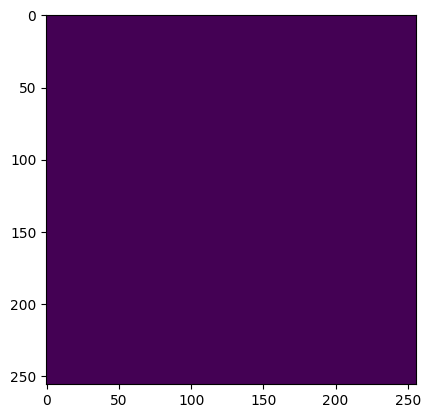

mask


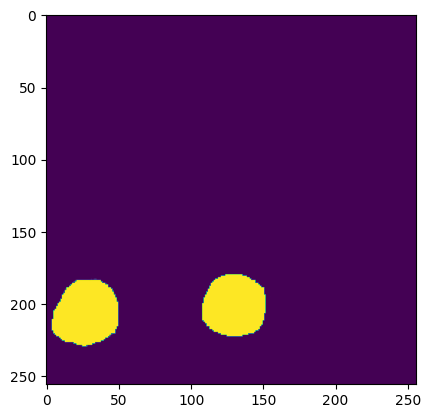

predict


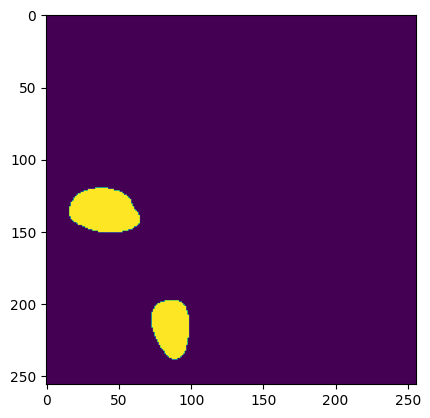

mask


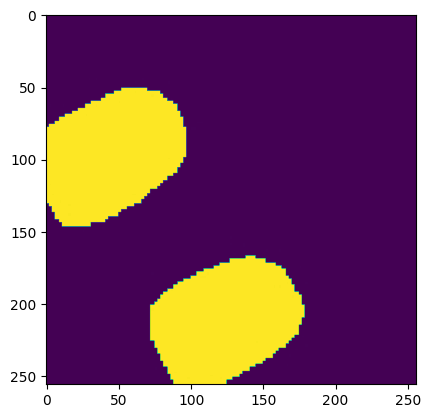

predict


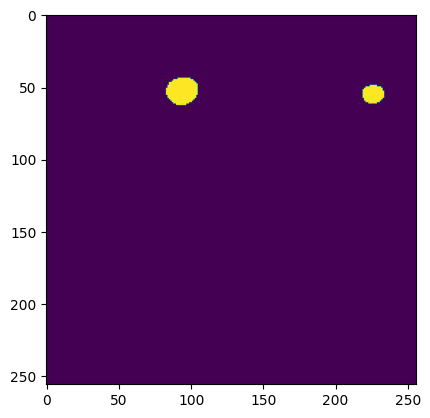

mask


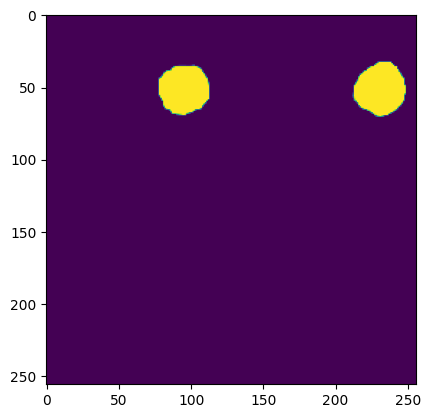

predict


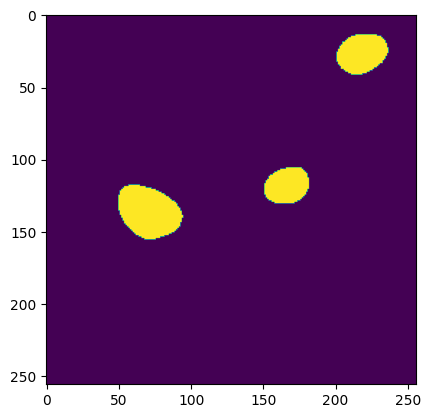

mask


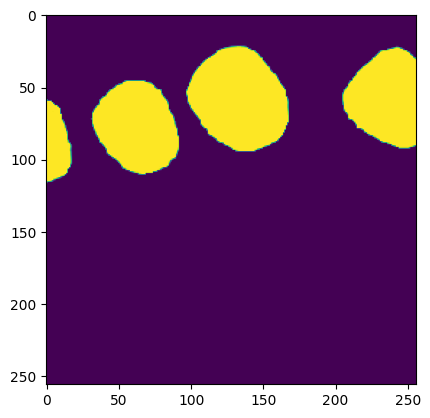

predict


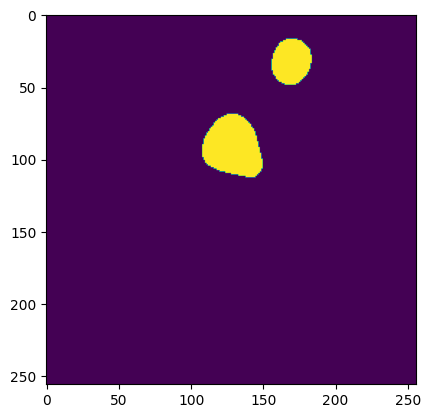

mask


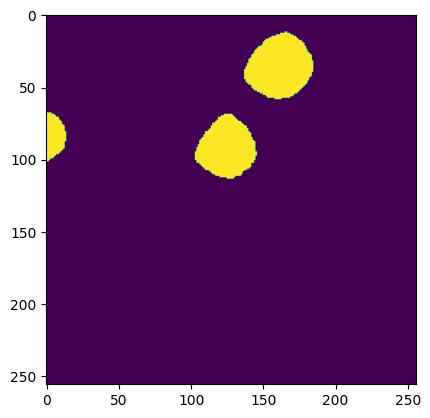

predict


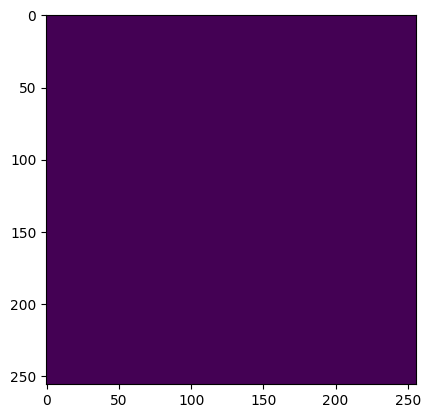

mask


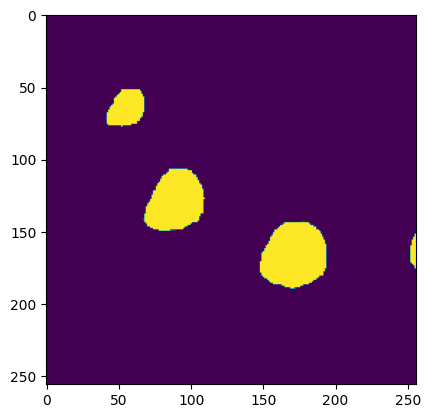

predict


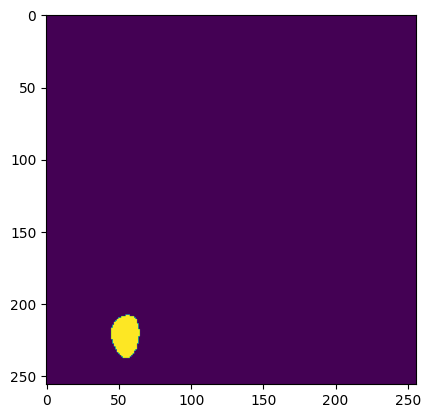

mask


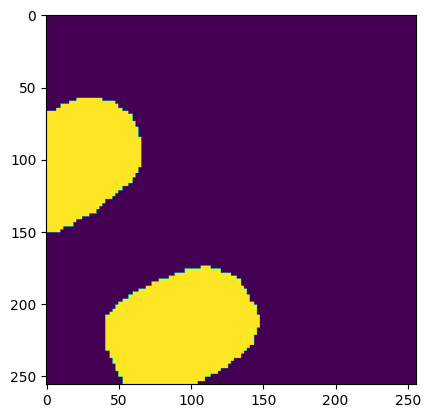

Validation:
	cost time: 5.470226287841797
---------------SAVE MODEL-----------------
	Save model: 0
-----------------------------------------


  2%|▏         | 1/55 [00:34<30:54, 34.33s/it]

epoch/iterator num: 1/3
	Run cost 0.009178 sec
IOU: 4.320938587188721, Dice: 1.8382084369659424
-----------------------------------------
predict


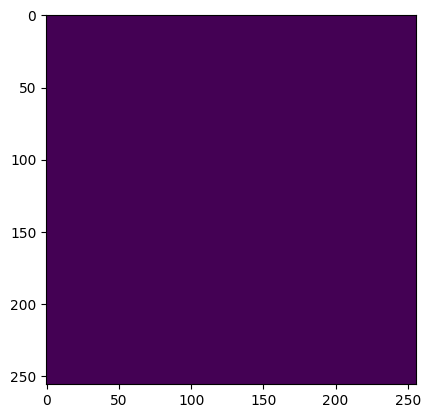

mask


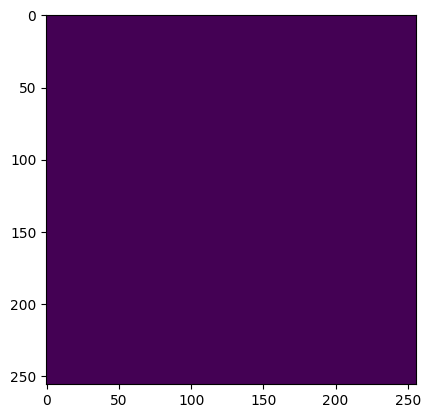

predict


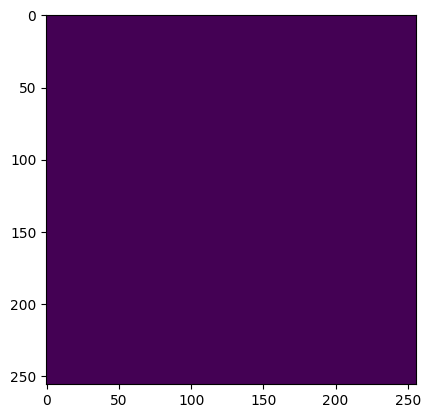

mask


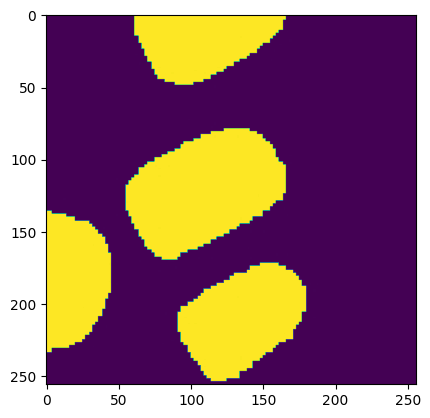

predict


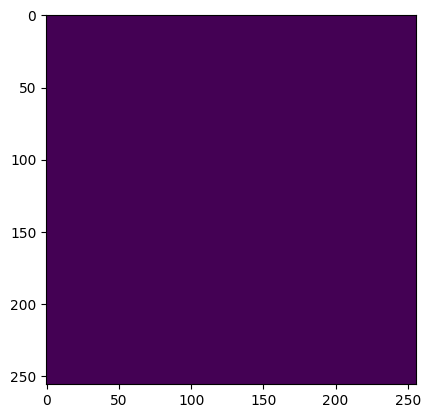

mask


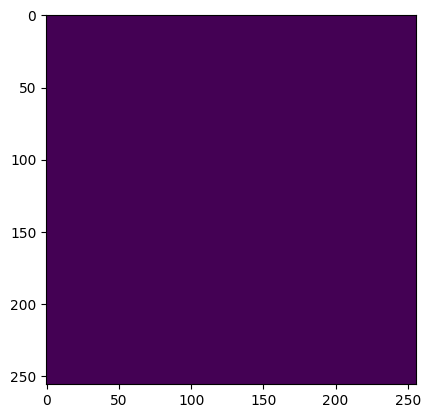

predict


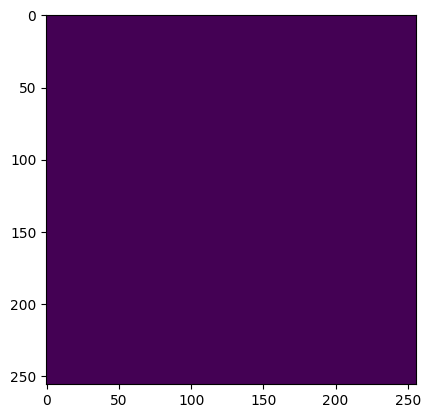

mask


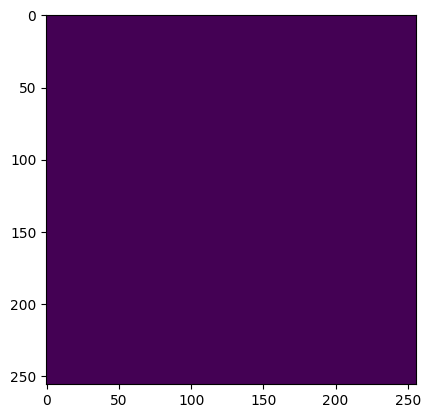

predict


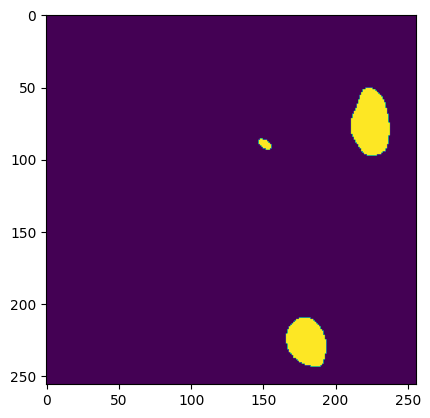

mask


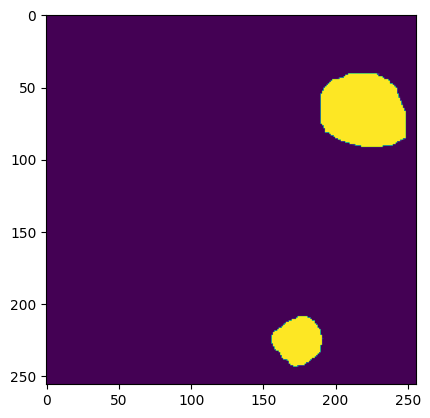

predict


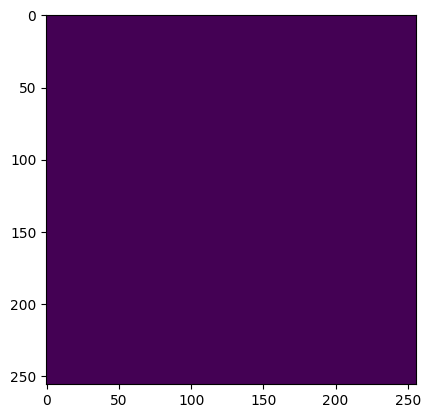

mask


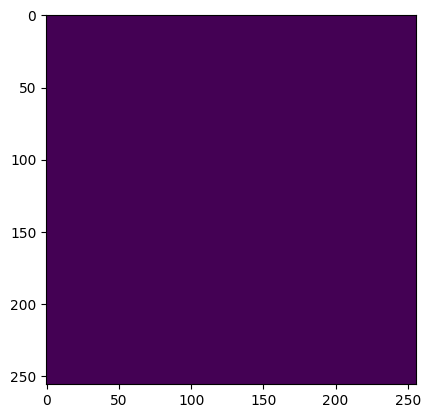

predict


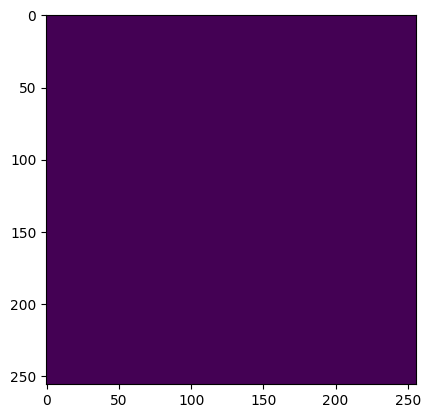

mask


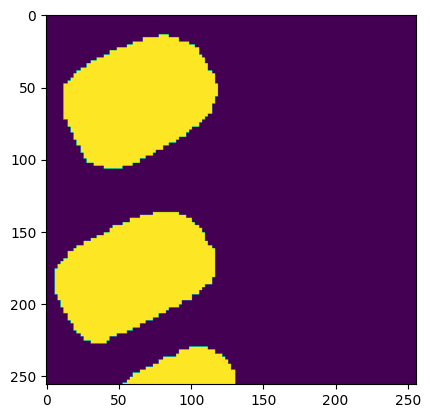

  4%|▎         | 2/55 [01:07<29:45, 33.69s/it]

Validation:
	cost time: 5.208447694778442
epoch/iterator num: 2/6
	Run cost 0.009835 sec
IOU: 9.99502944946289, Dice: 1.5966448783874512
-----------------------------------------
predict


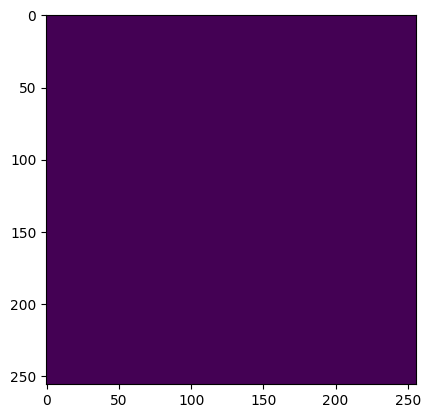

mask


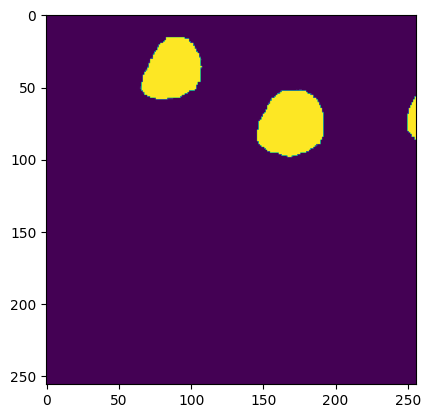

predict


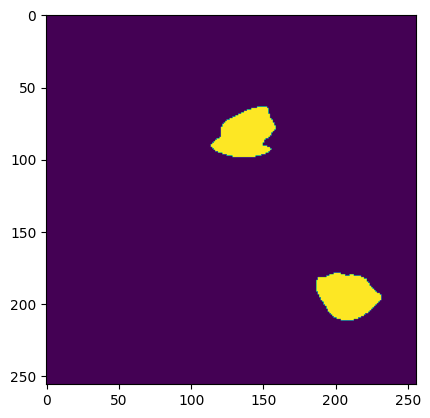

mask


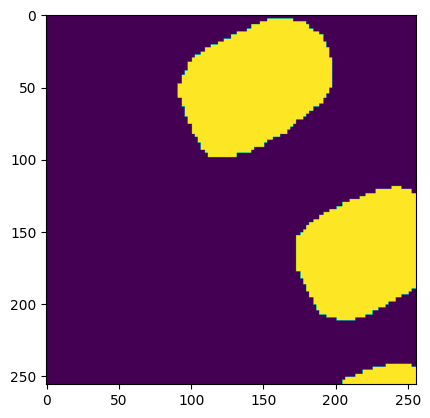

predict


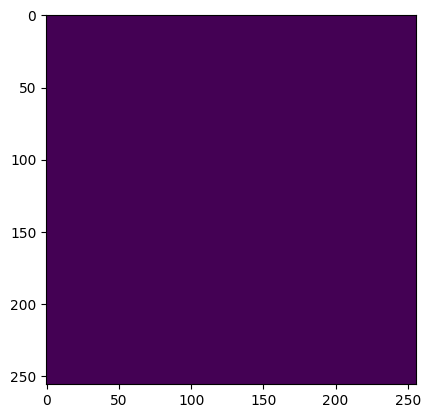

mask


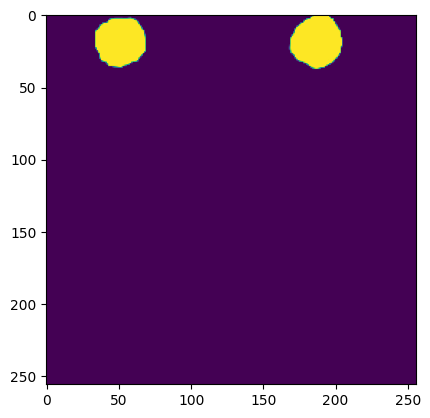

predict


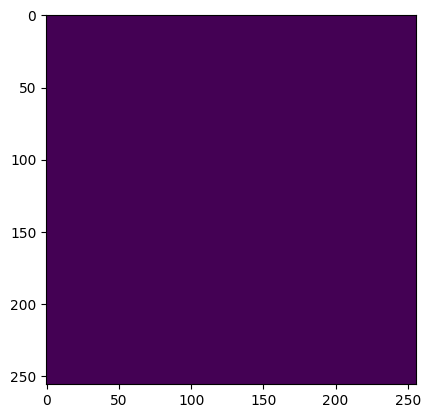

mask


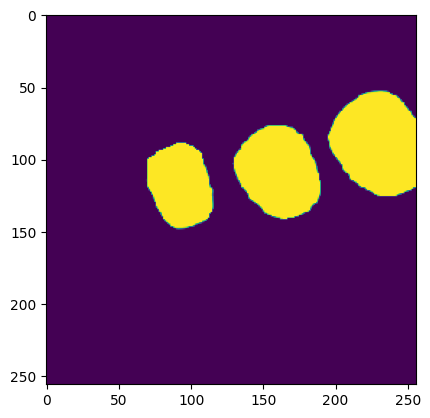

predict


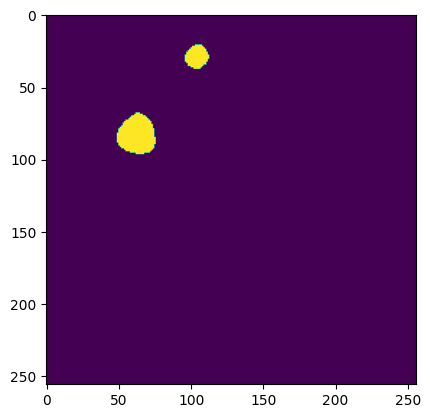

mask


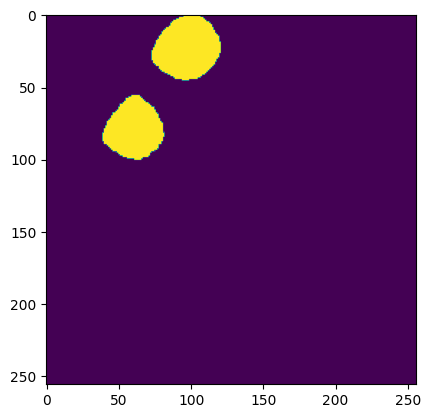

predict


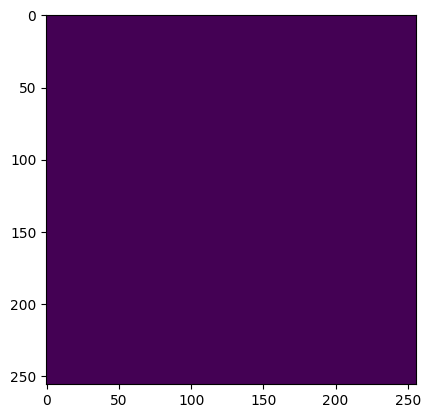

mask


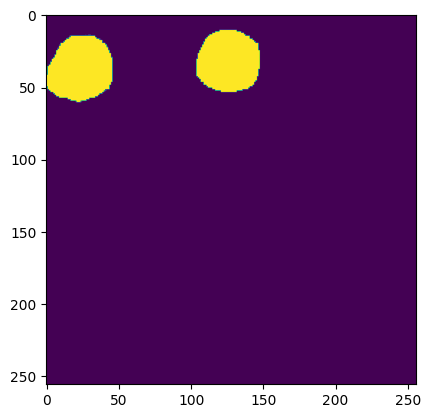

predict


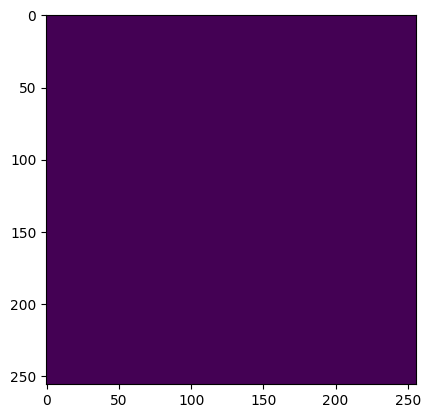

mask


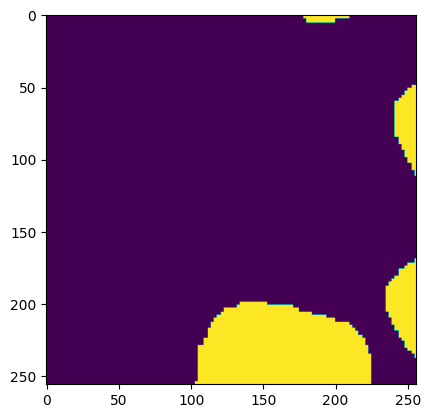

  5%|▌         | 3/55 [01:40<28:54, 33.36s/it]

Validation:
	cost time: 5.435717344284058
epoch/iterator num: 3/9
	Run cost 0.016243 sec
IOU: 7.462413787841797, Dice: 1.8615195751190186
-----------------------------------------
predict


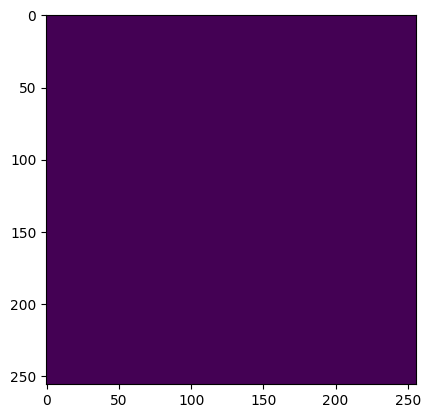

mask


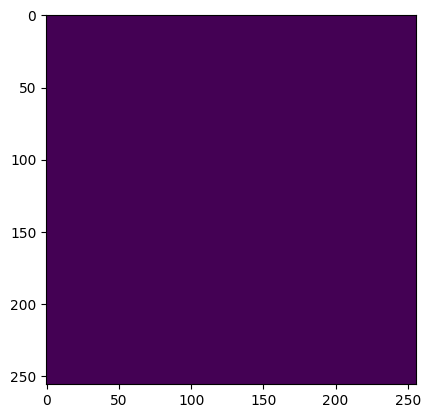

predict


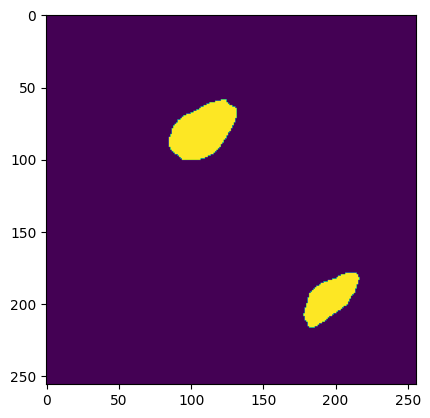

mask


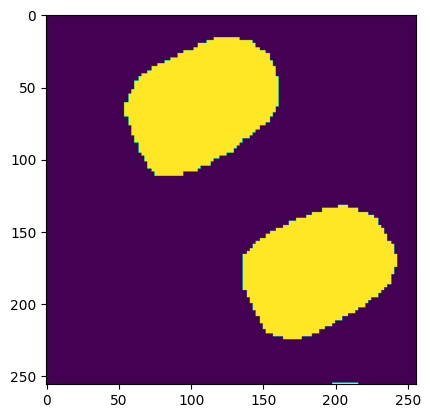

predict


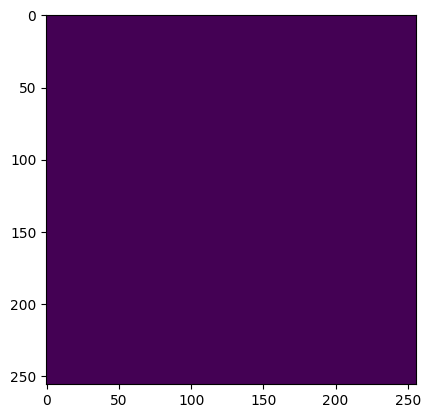

mask


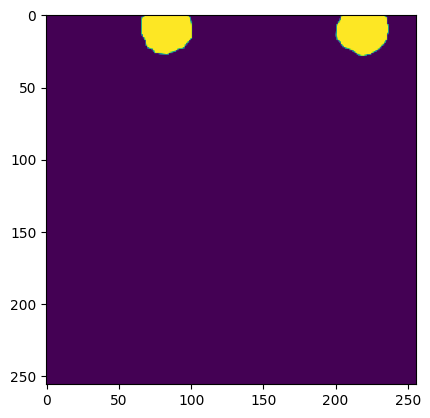

predict


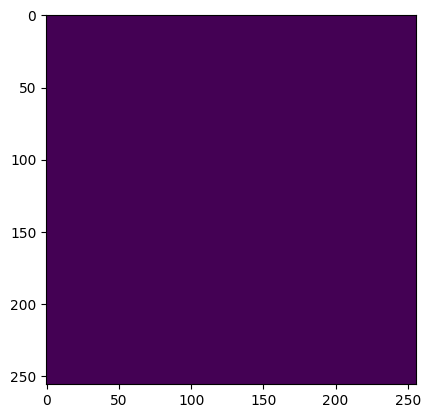

mask


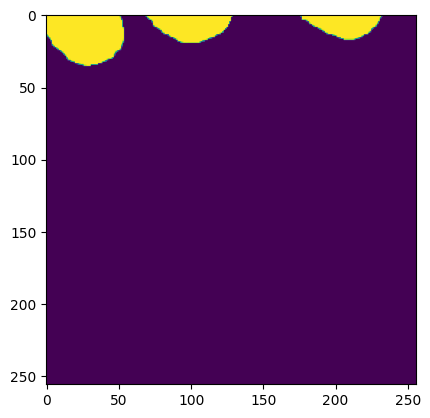

predict


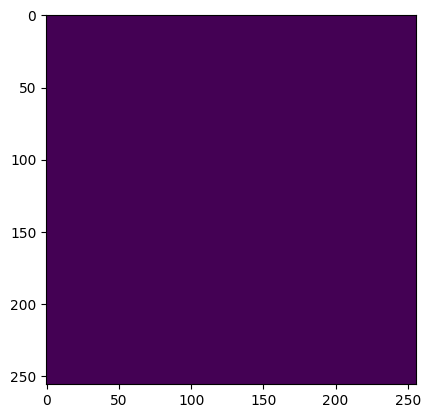

mask


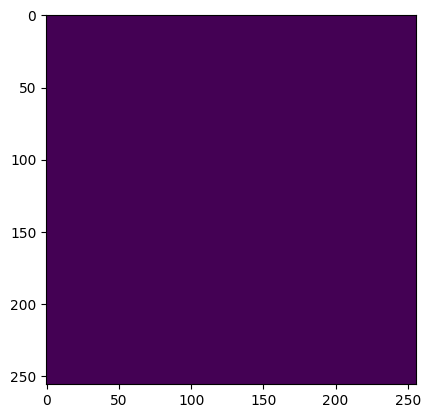

predict


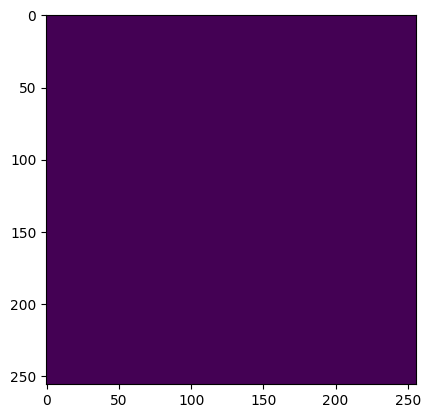

mask


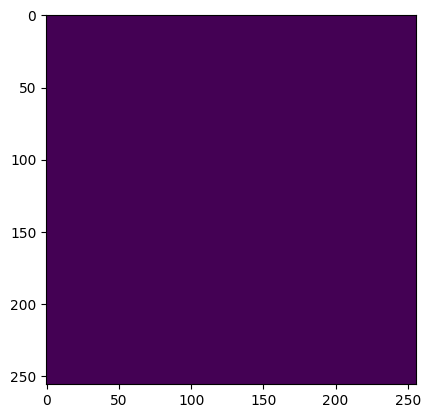

predict


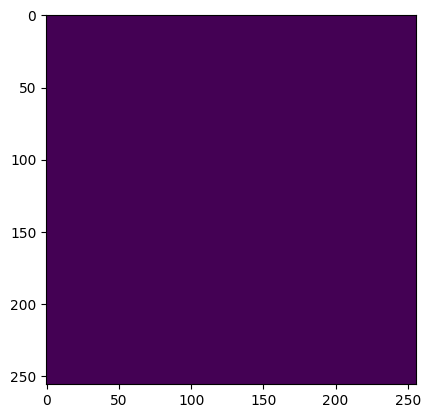

mask


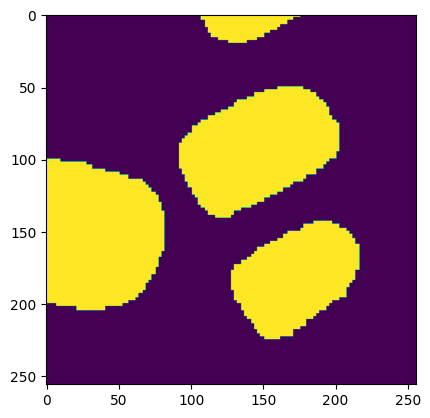

Validation:
	cost time: 5.179739475250244
---------------SAVE MODEL-----------------
	Save model: 3
-----------------------------------------


  7%|▋         | 4/55 [02:13<28:23, 33.40s/it]

epoch/iterator num: 4/13
	Run cost 0.009452 sec
IOU: 6.355562210083008, Dice: 1.8612946271896362
-----------------------------------------
predict


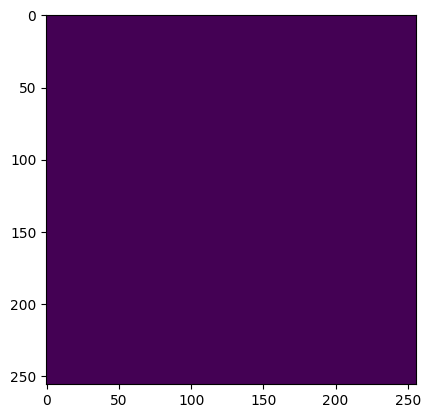

mask


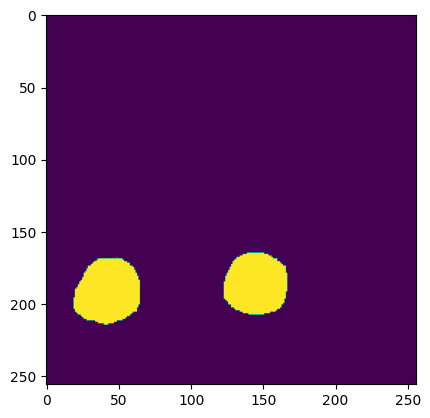

predict


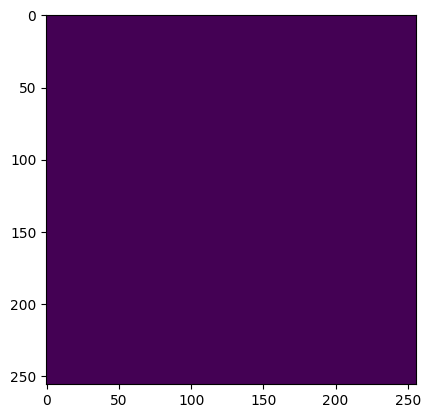

mask


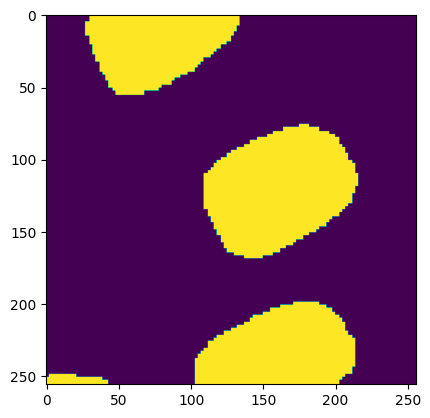

predict


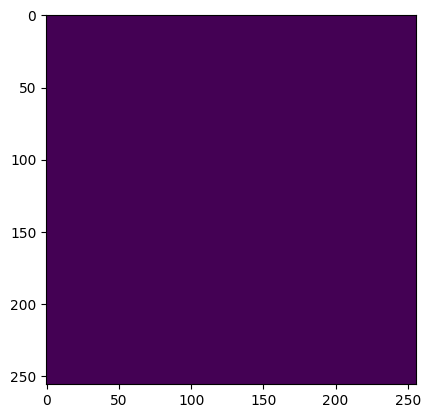

mask


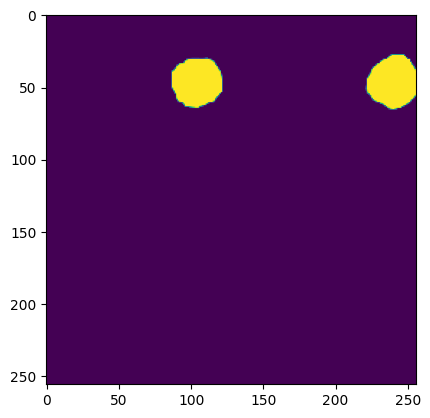

predict


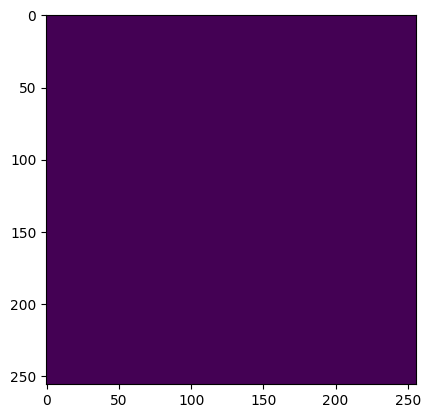

mask


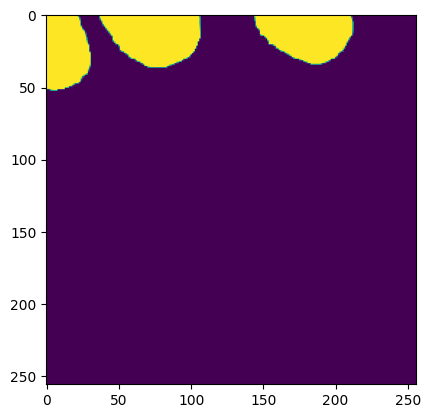

predict


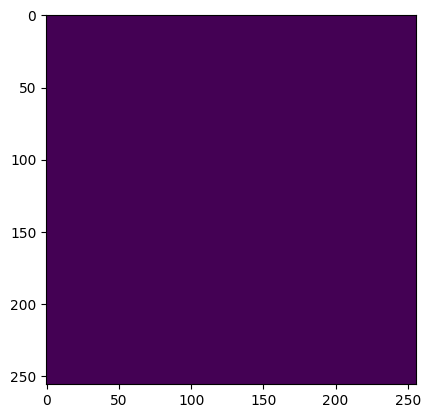

mask


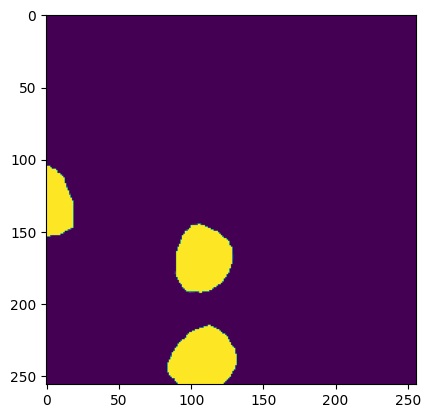

predict


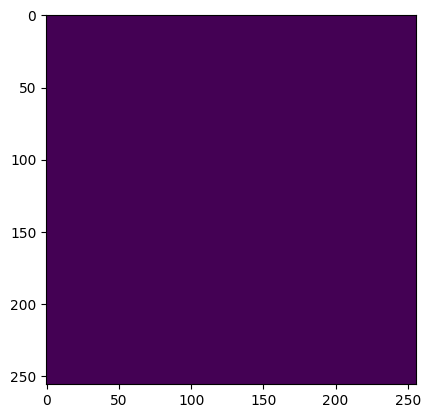

mask


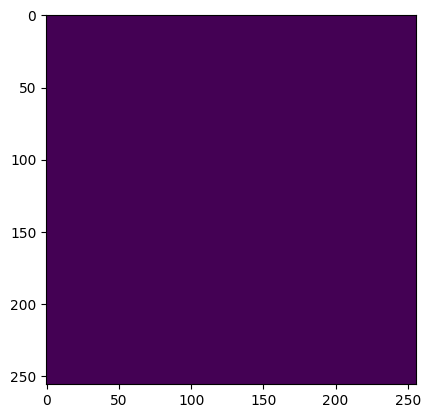

predict


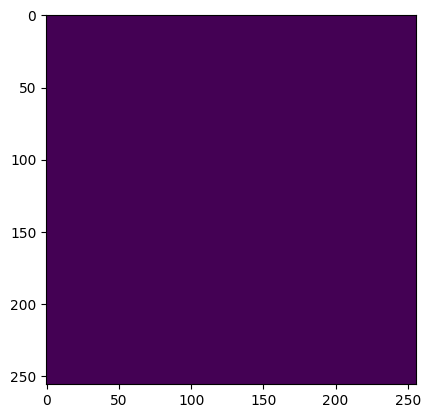

mask


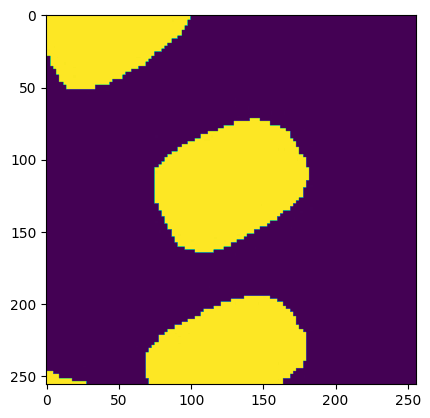

  9%|▉         | 5/55 [02:46<27:36, 33.13s/it]

Validation:
	cost time: 5.009121417999268
epoch/iterator num: 5/16
	Run cost 0.013387 sec
IOU: 11.853445053100586, Dice: 1.8844189643859863
-----------------------------------------
predict


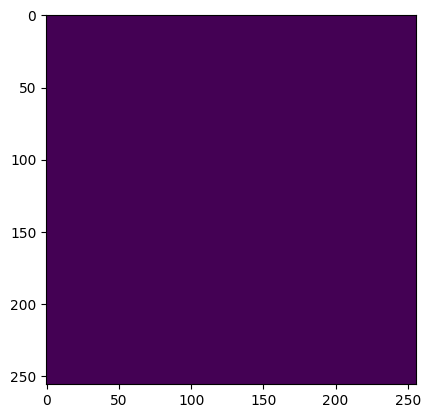

mask


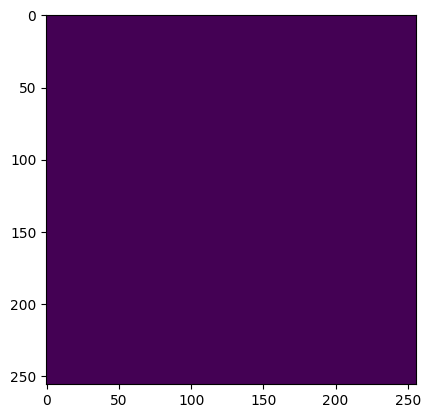

predict


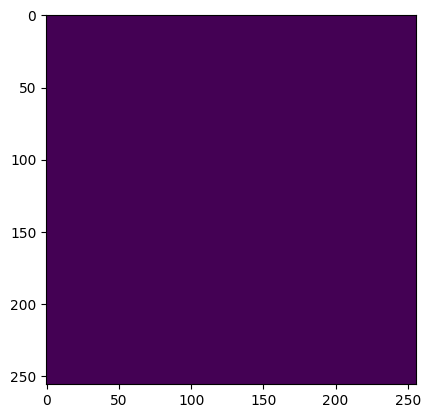

mask


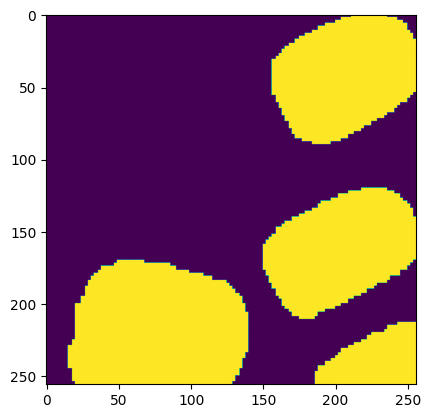

predict


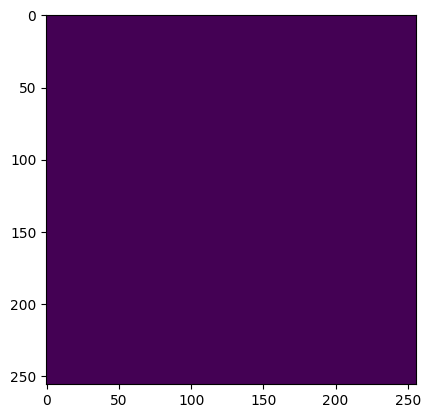

mask


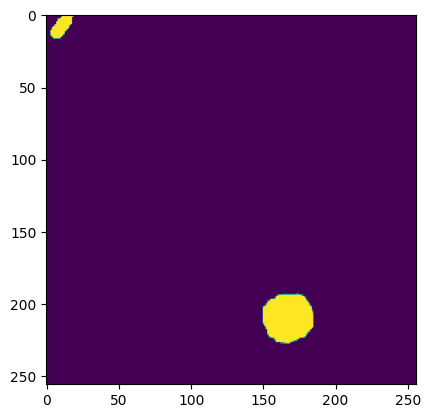

predict


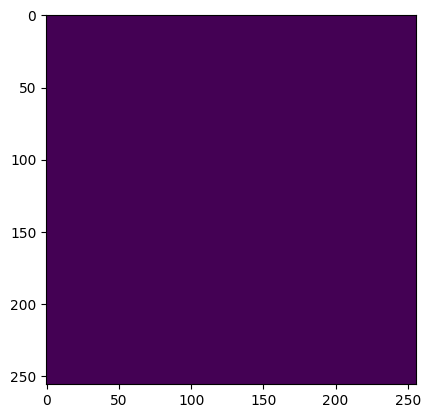

mask


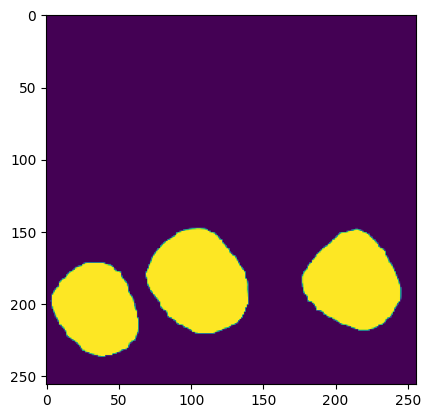

predict


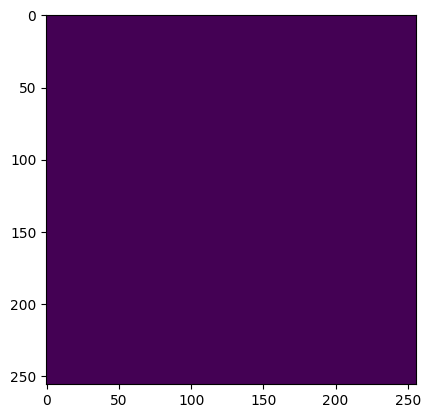

mask


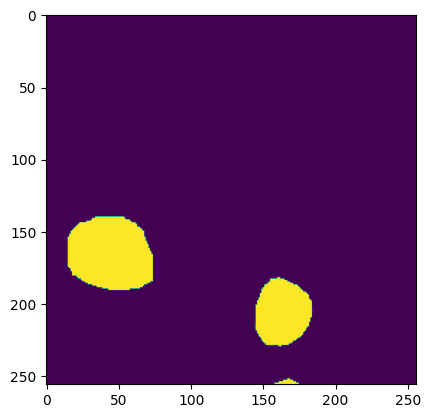

predict


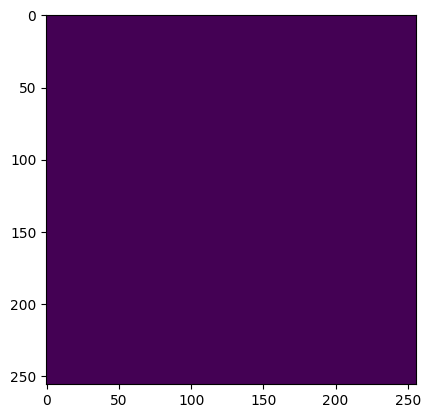

mask


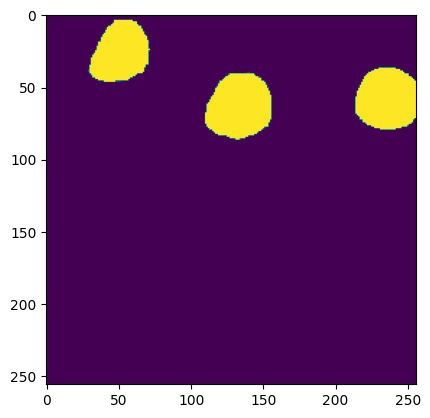

predict


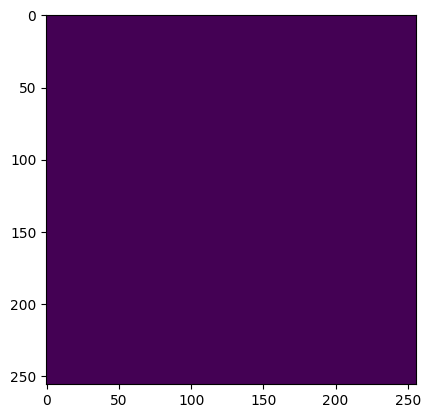

mask


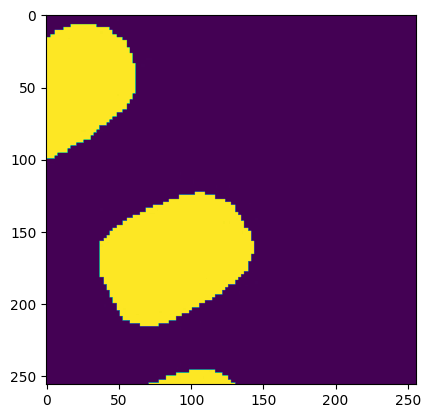

 11%|█         | 6/55 [03:19<26:58, 33.04s/it]

Validation:
	cost time: 5.0681374073028564
epoch/iterator num: 6/19
	Run cost 0.009558 sec
IOU: 12.257993698120117, Dice: 1.905328631401062
-----------------------------------------
predict


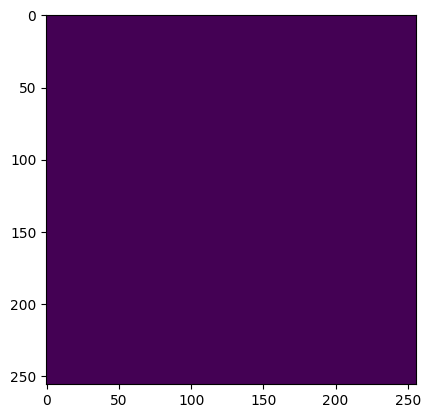

mask


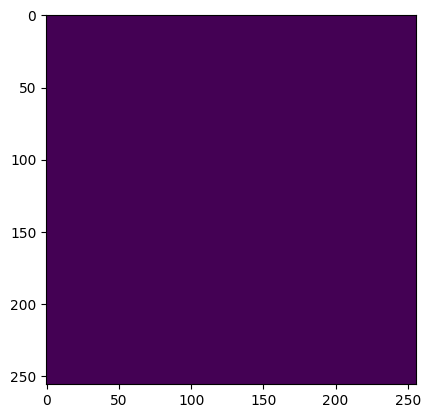

predict


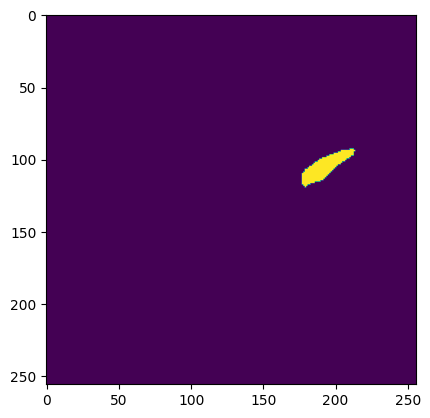

mask


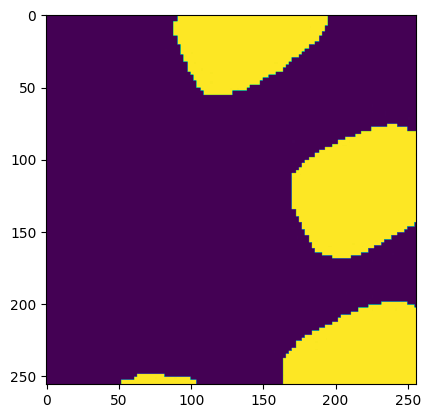

predict


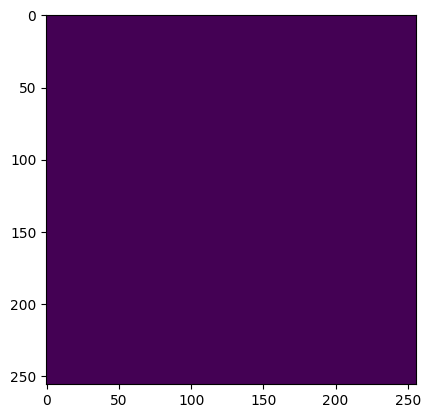

mask


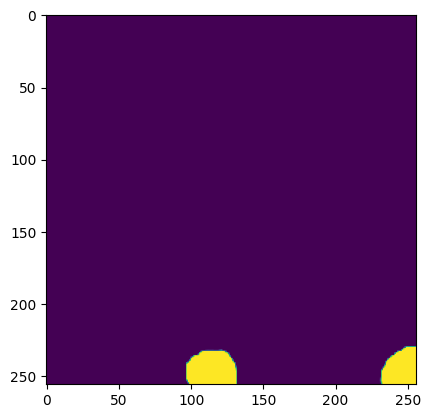

predict


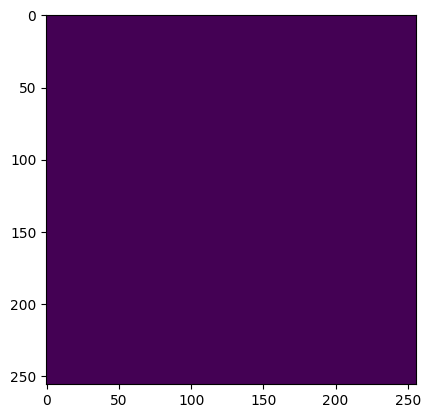

mask


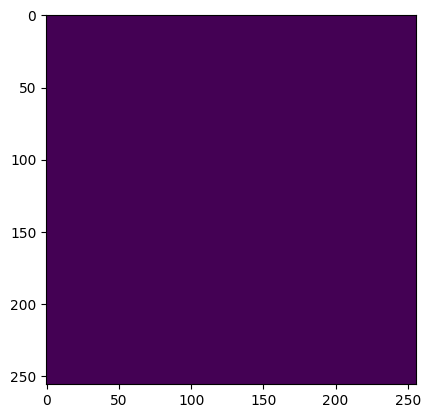

predict


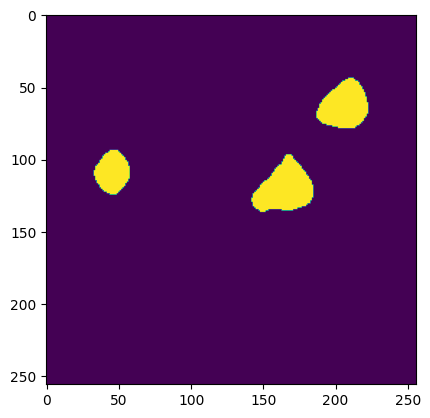

mask


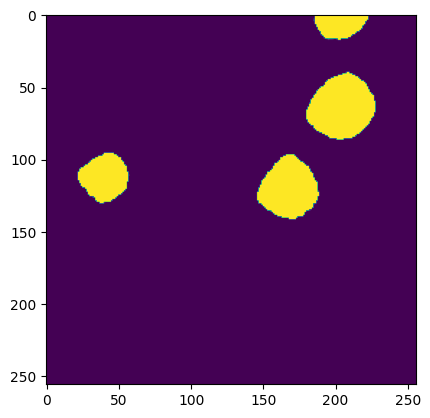

predict


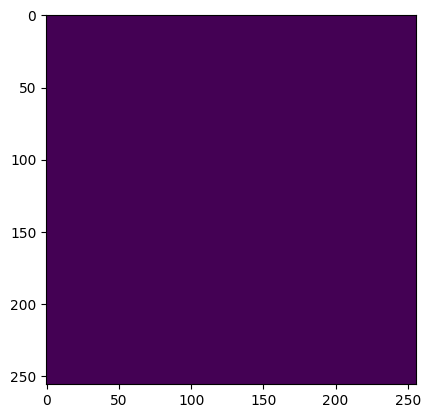

mask


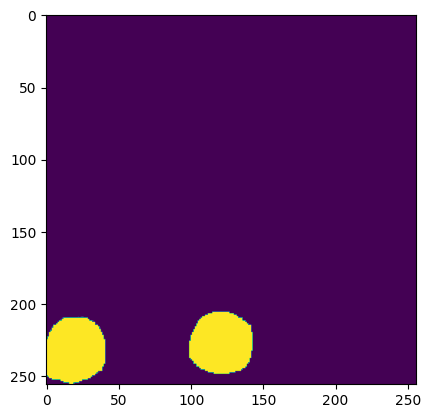

predict


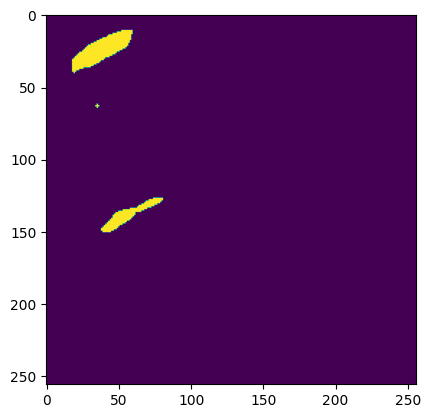

mask


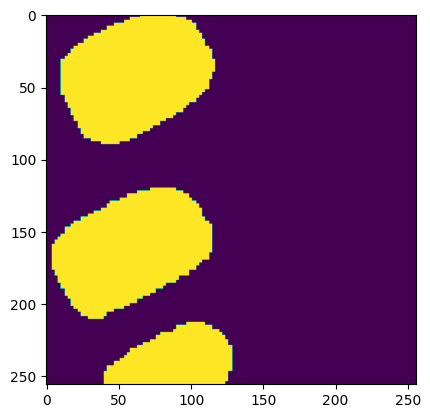

Validation:
	cost time: 5.1442272663116455
---------------SAVE MODEL-----------------
	Save model: 6
-----------------------------------------


 13%|█▎        | 7/55 [03:52<26:29, 33.12s/it]

epoch/iterator num: 7/22
	Run cost 0.014248 sec
IOU: 15.442788124084473, Dice: 1.9175292253494263
-----------------------------------------
predict


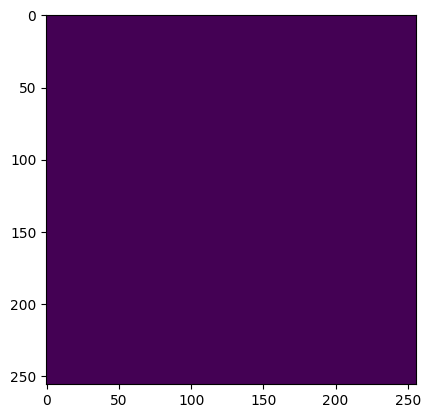

mask


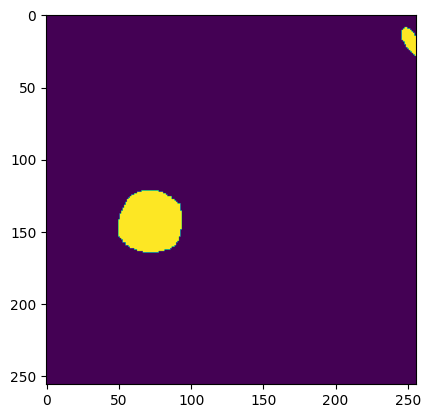

predict


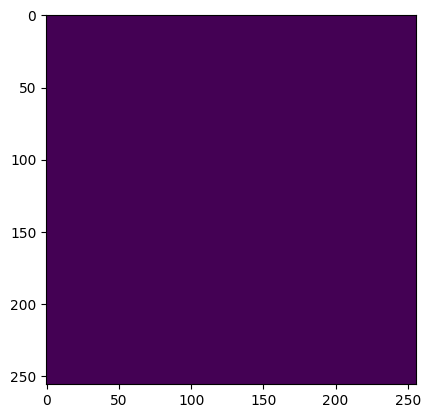

mask


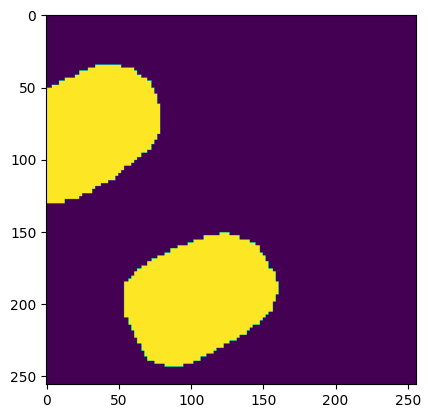

predict


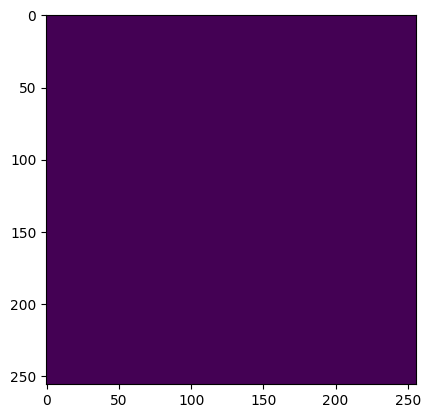

mask


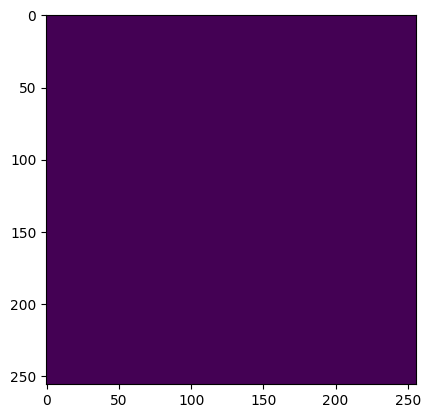

predict


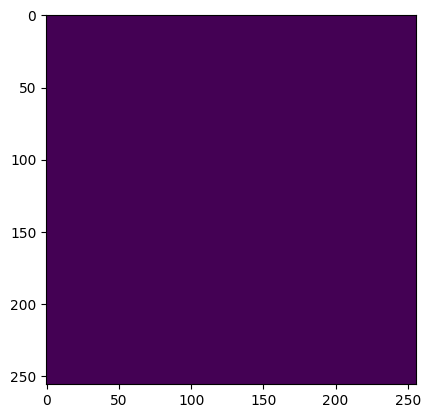

mask


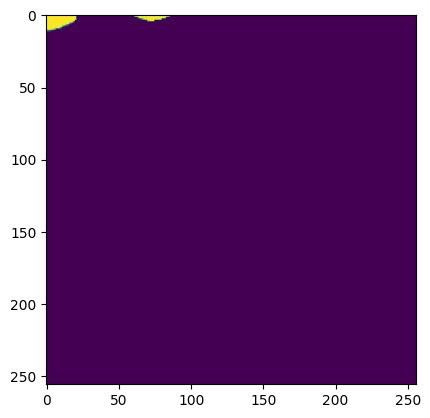

predict


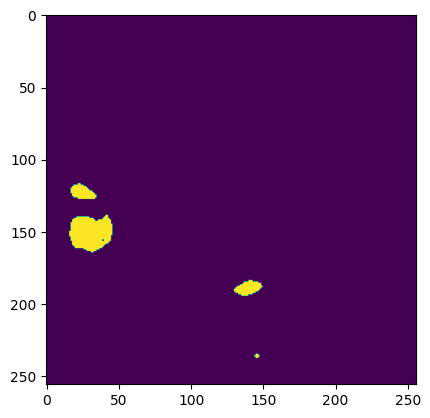

mask


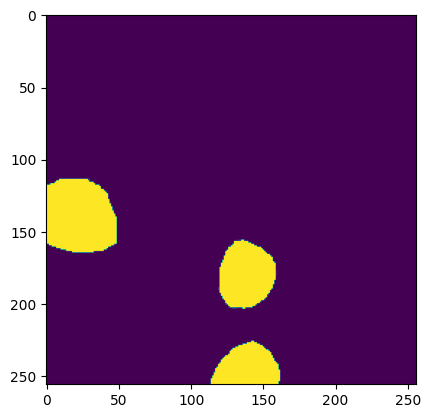

predict


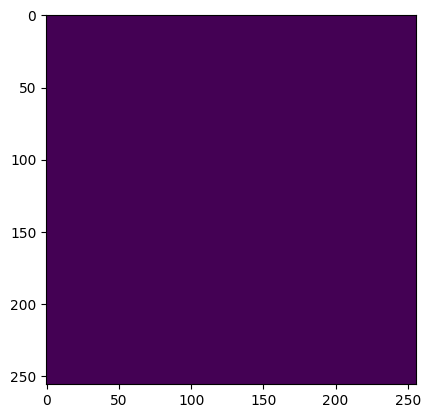

mask


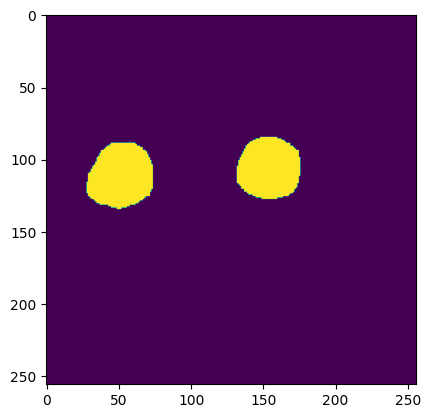

predict


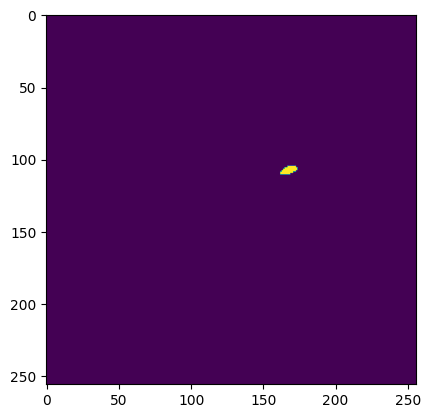

mask


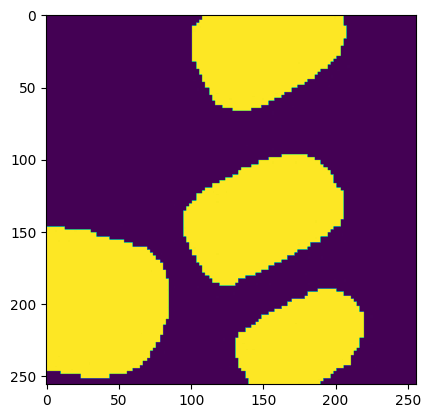

Validation:
	cost time: 5.609232187271118
---------------SAVE MODEL-----------------
	Save model: 7
-----------------------------------------


 15%|█▍        | 8/55 [04:26<26:03, 33.27s/it]

epoch/iterator num: 8/26
	Run cost 0.013498 sec
IOU: 8.560670852661133, Dice: 1.9438093900680542
-----------------------------------------
predict


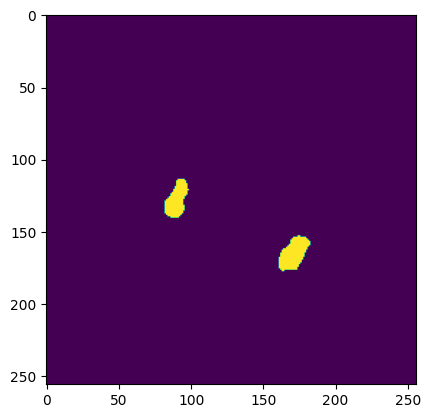

mask


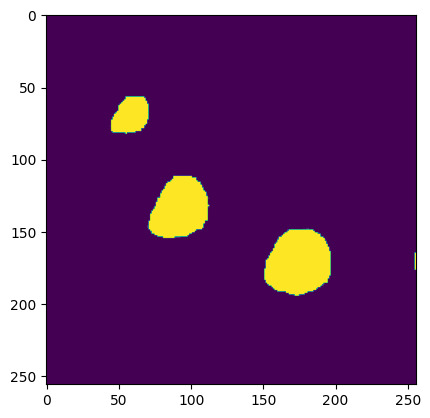

predict


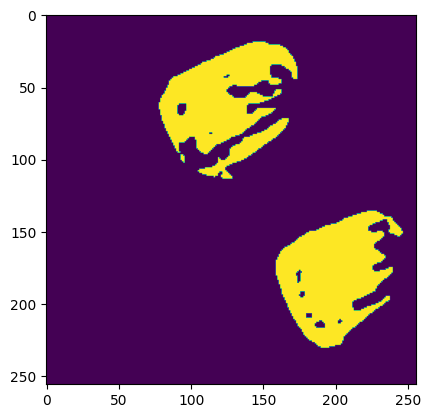

mask


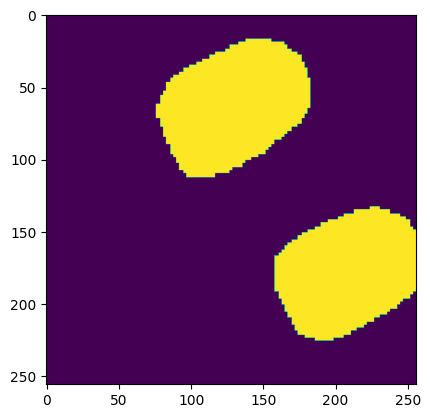

predict


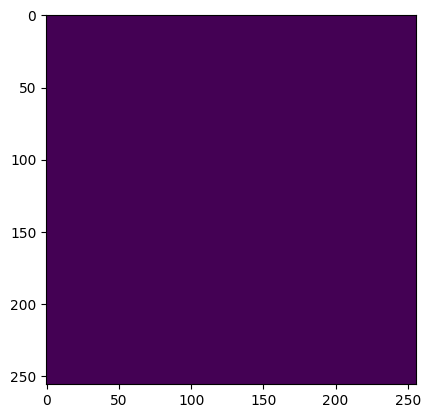

mask


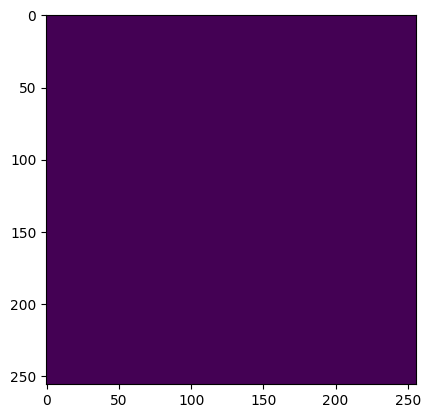

predict


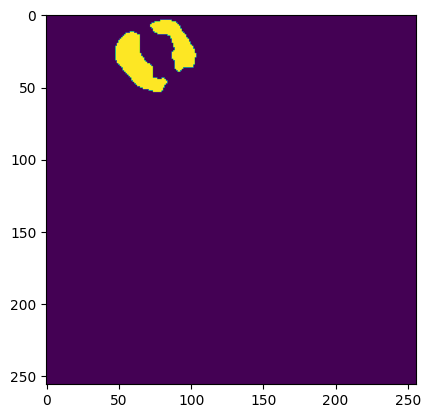

mask


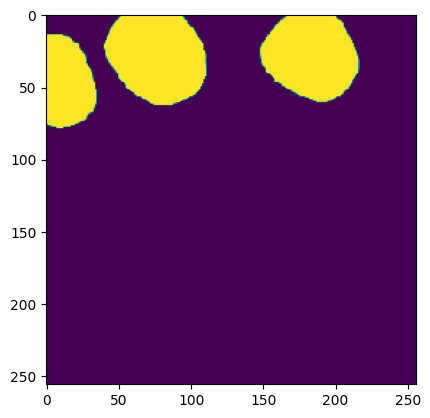

predict


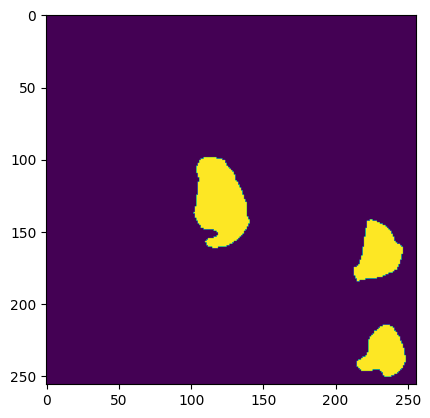

mask


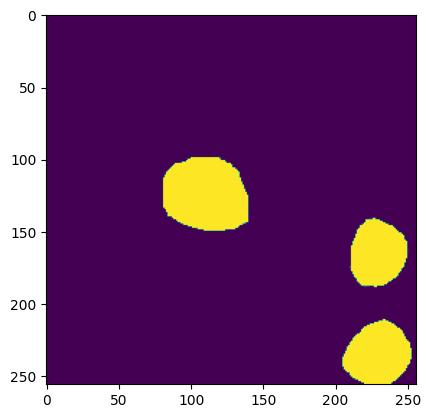

predict


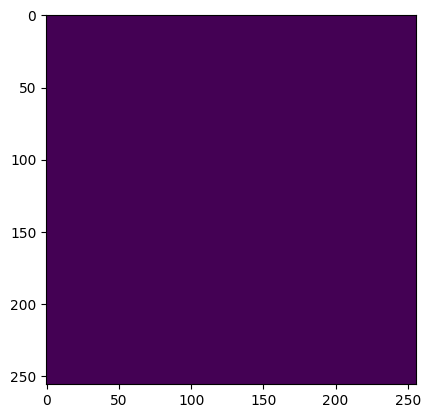

mask


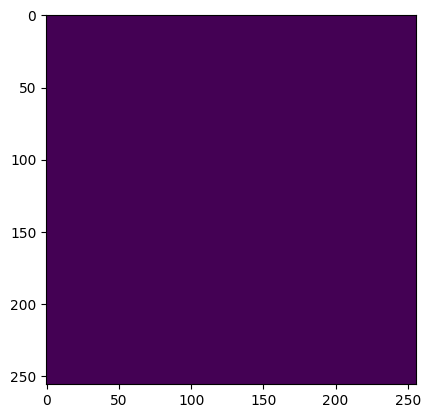

predict


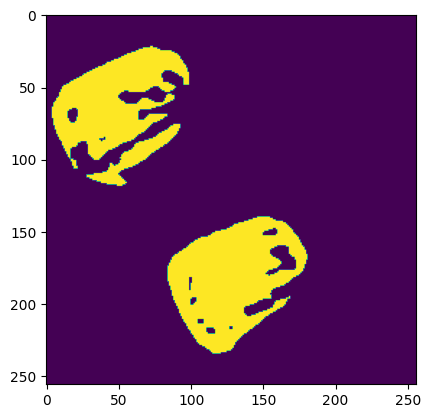

mask


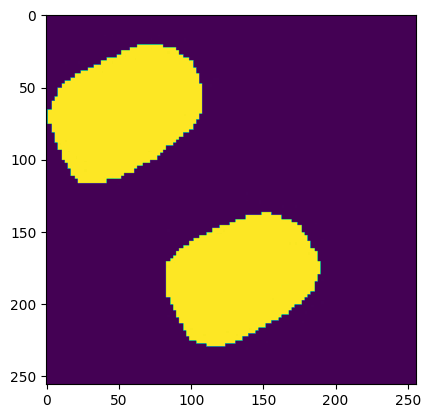

Validation:
	cost time: 5.088571548461914
---------------SAVE MODEL-----------------
	Save model: 8
-----------------------------------------


 16%|█▋        | 9/55 [04:59<25:26, 33.20s/it]

epoch/iterator num: 9/29
	Run cost 0.008967 sec
IOU: 23.572053909301758, Dice: 1.942318081855774
-----------------------------------------
predict


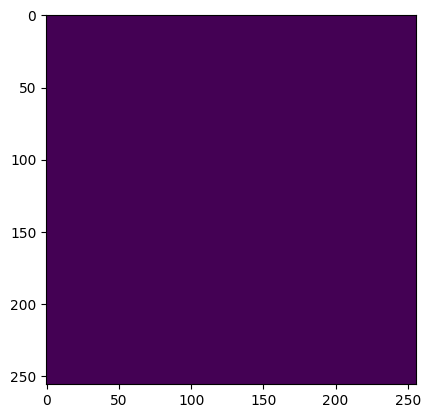

mask


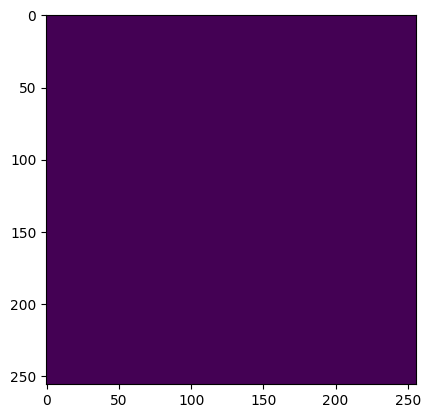

predict


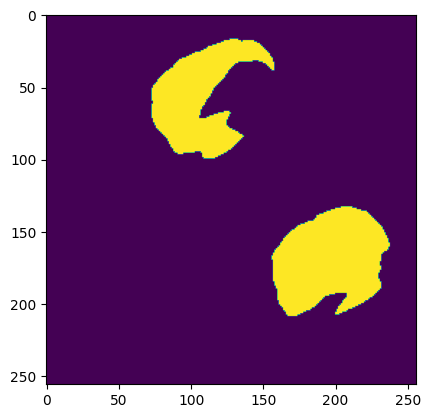

mask


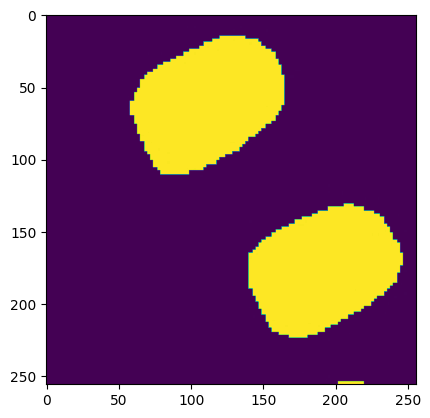

predict


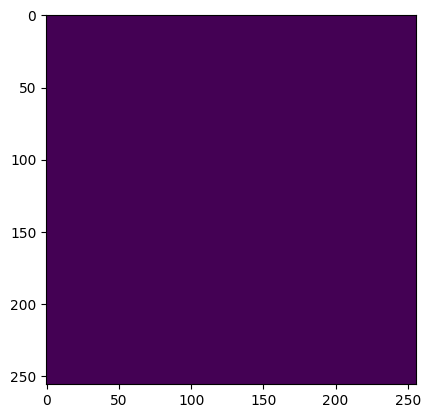

mask


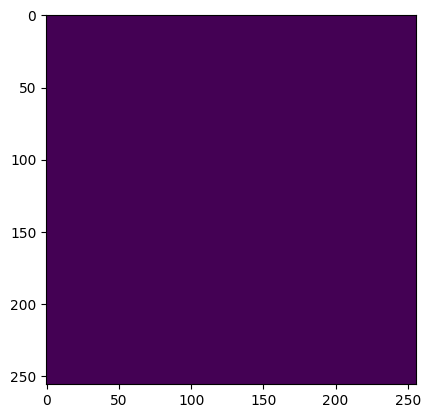

predict


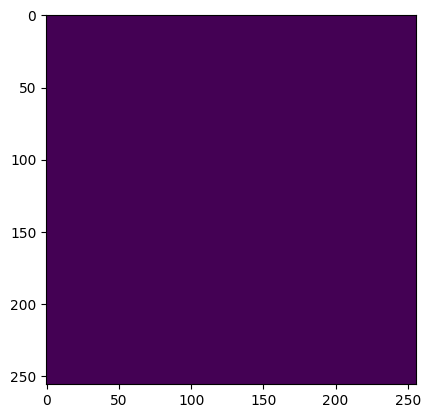

mask


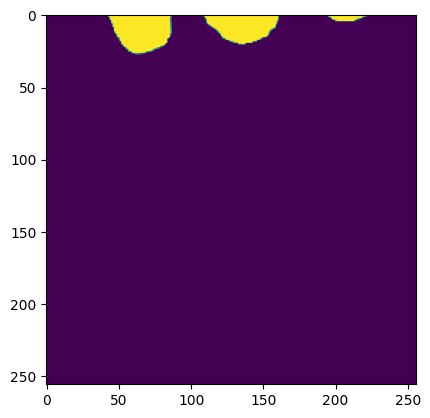

predict


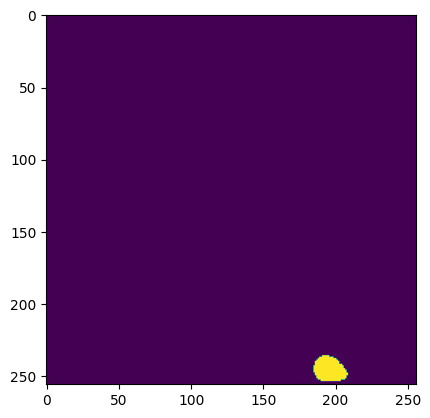

mask


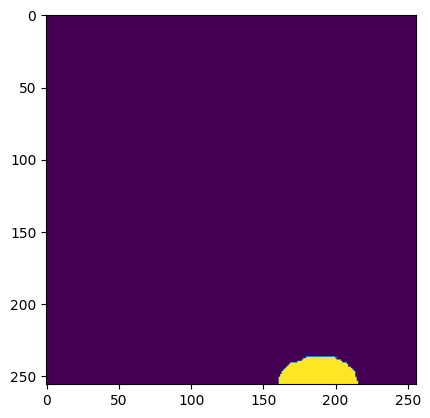

predict


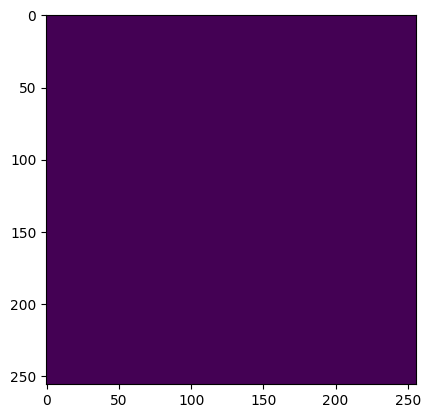

mask


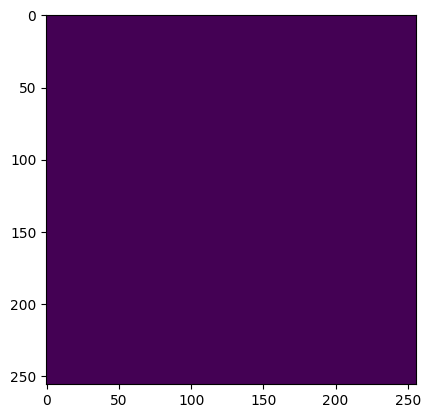

predict


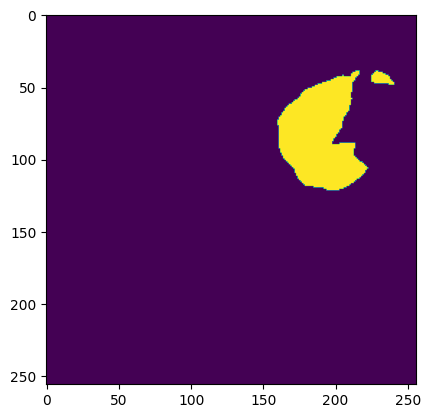

mask


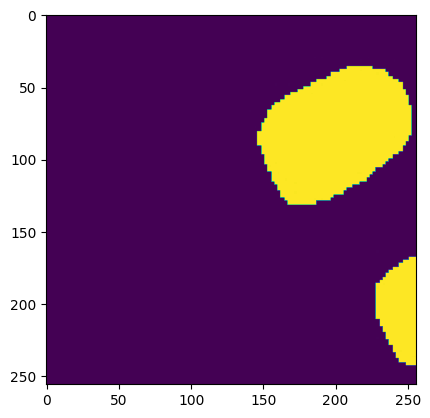

 18%|█▊        | 10/55 [05:32<24:45, 33.01s/it]

Validation:
	cost time: 5.233151912689209
epoch/iterator num: 10/32
	Run cost 0.010284 sec
IOU: 12.703359603881836, Dice: 1.9229272603988647
-----------------------------------------
predict


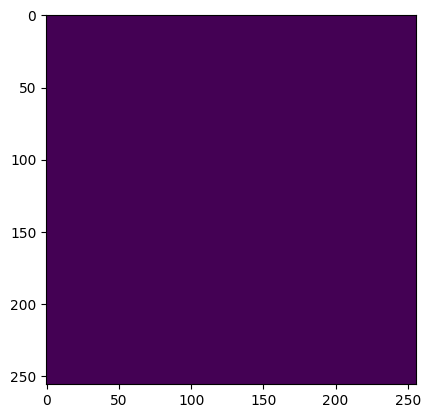

mask


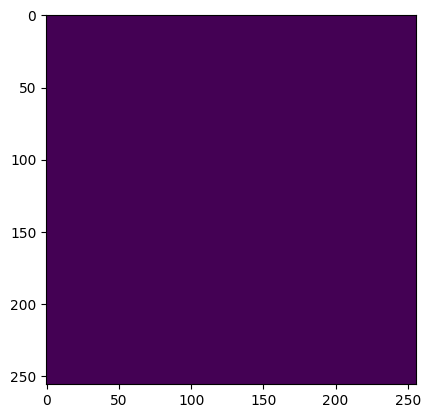

predict


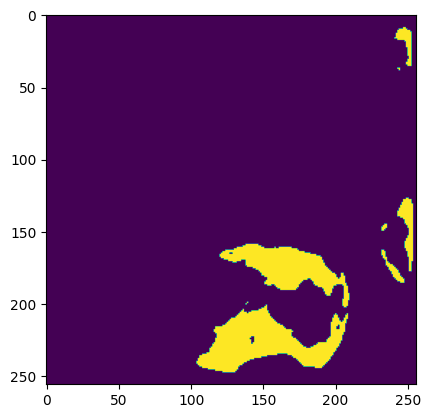

mask


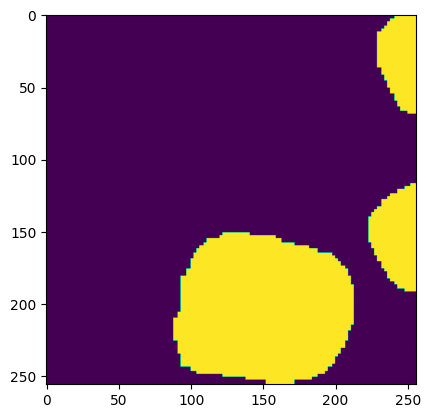

predict


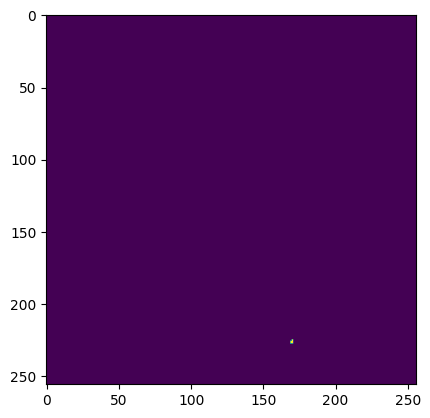

mask


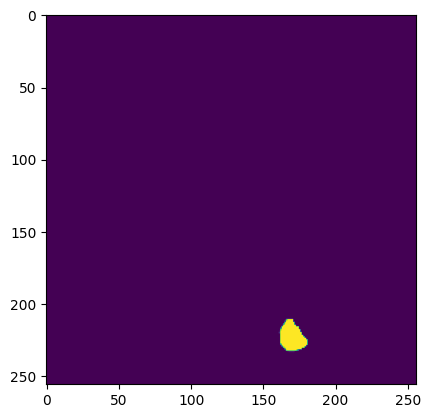

predict


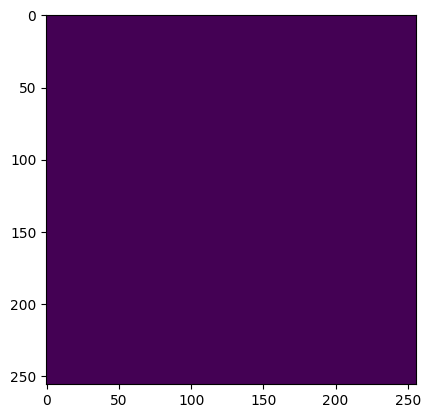

mask


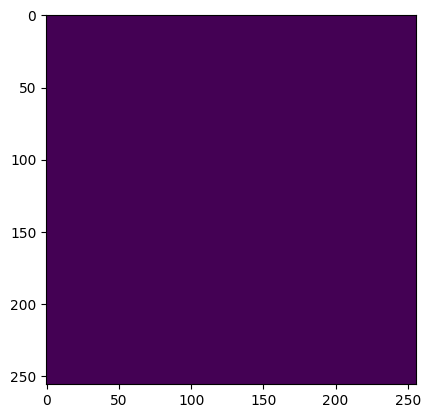

predict


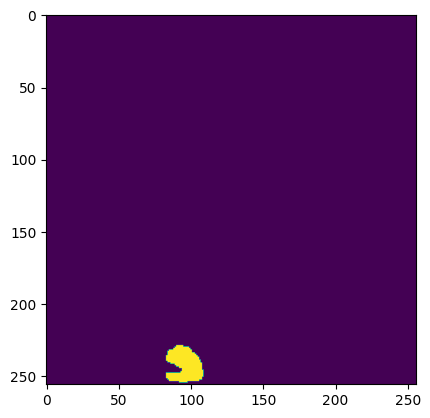

mask


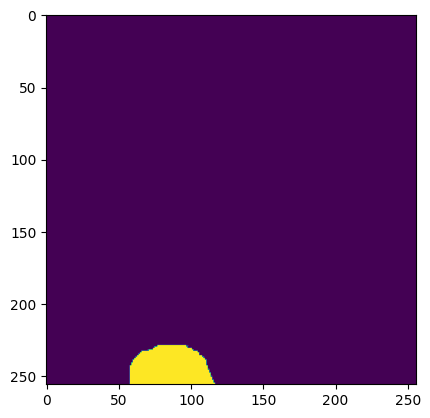

predict


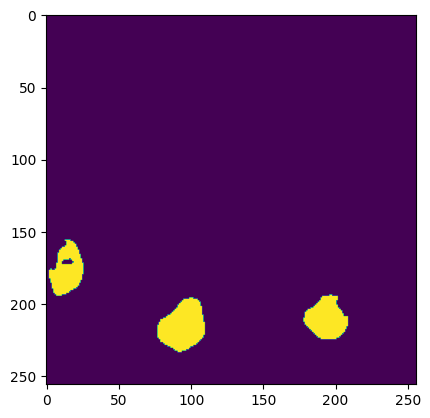

mask


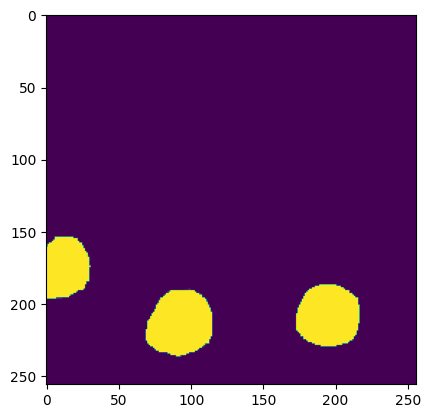

predict


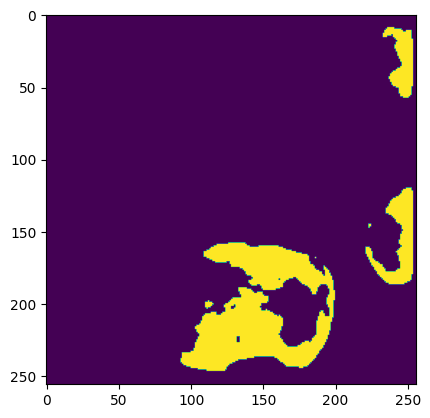

mask


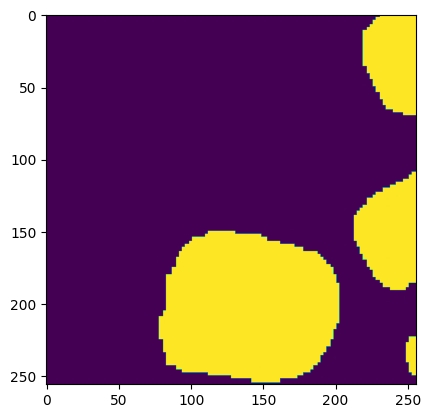

Validation:
	cost time: 5.327046871185303
---------------SAVE MODEL-----------------
	Save model: 10
-----------------------------------------


 20%|██        | 11/55 [06:05<24:12, 33.02s/it]

epoch/iterator num: 11/35
	Run cost 0.008195 sec
IOU: 17.73301124572754, Dice: 1.8935209512710571
-----------------------------------------
predict


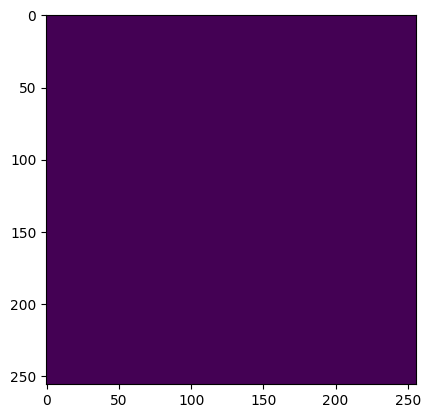

mask


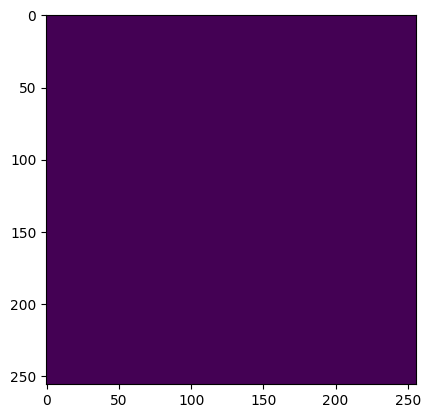

predict


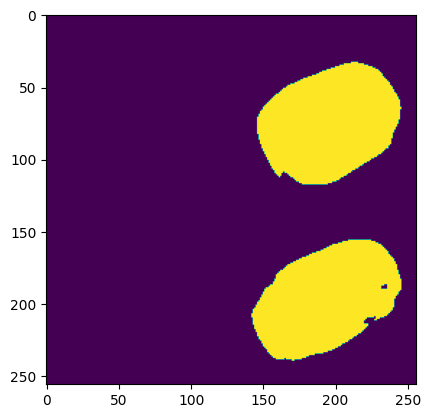

mask


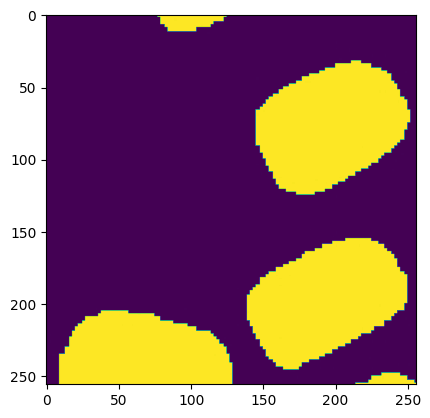

predict


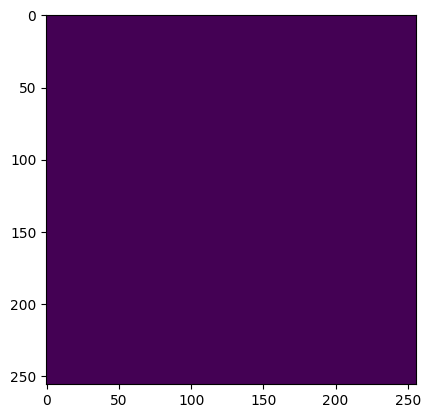

mask


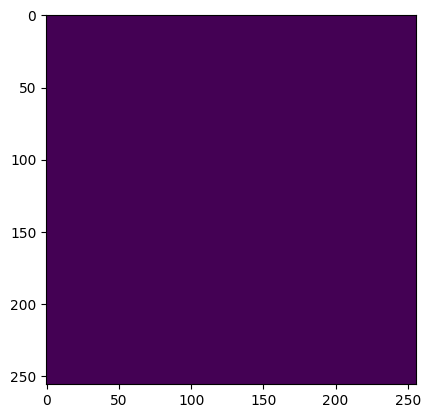

predict


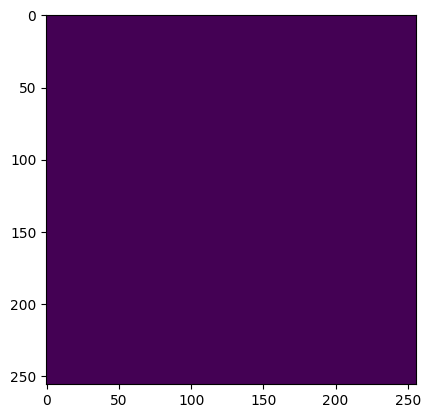

mask


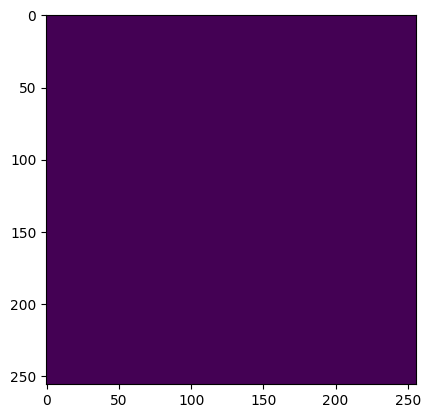

predict


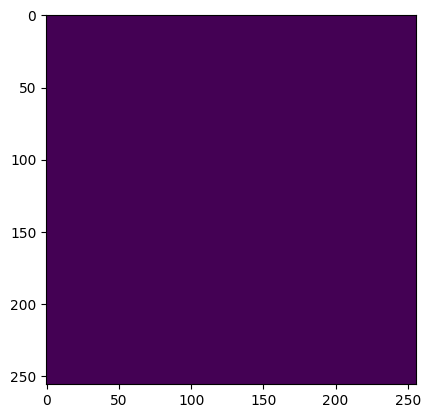

mask


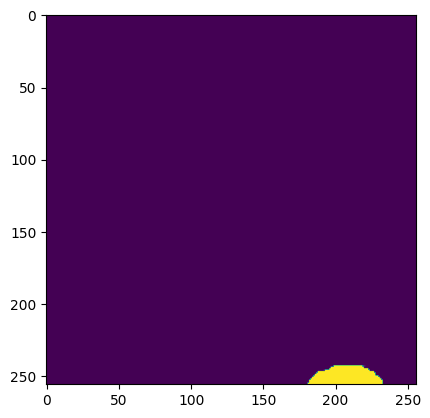

predict


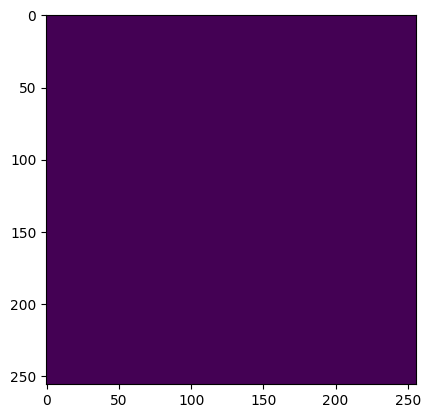

mask


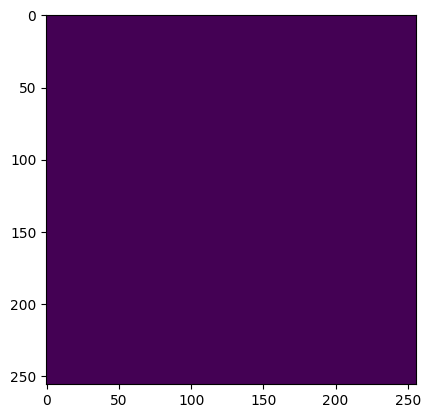

predict


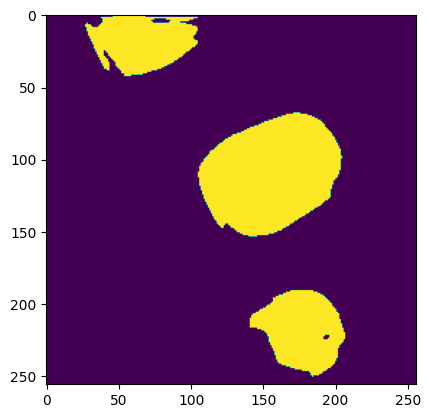

mask


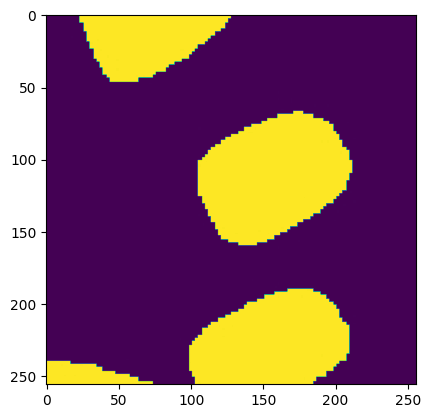

Validation:
	cost time: 5.073486089706421
---------------SAVE MODEL-----------------
	Save model: 11
-----------------------------------------


 22%|██▏       | 12/55 [06:37<23:38, 32.98s/it]

epoch/iterator num: 12/39
	Run cost 0.012611 sec
IOU: 16.587913513183594, Dice: 1.909985065460205
-----------------------------------------
predict


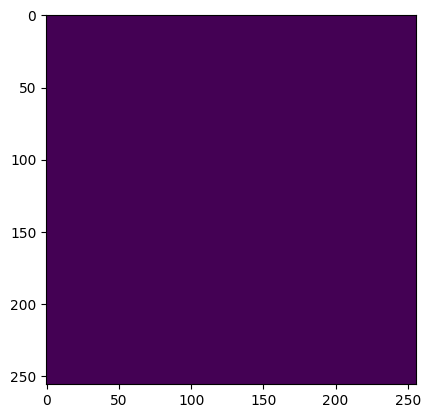

mask


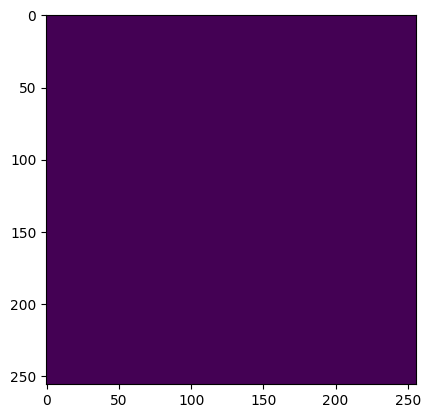

predict


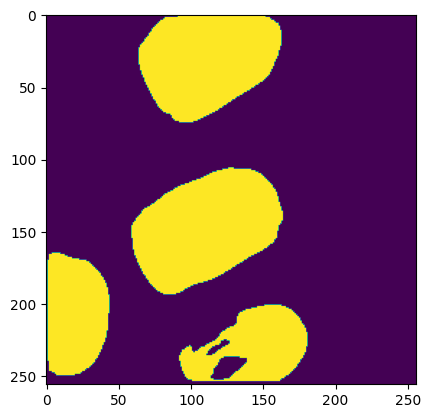

mask


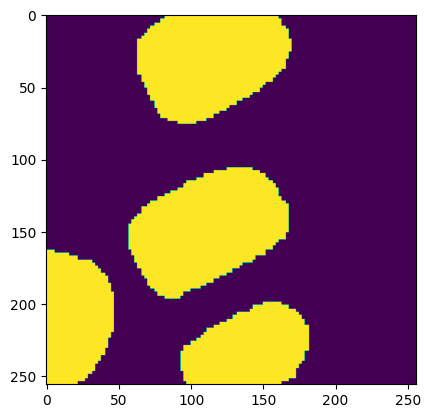

predict


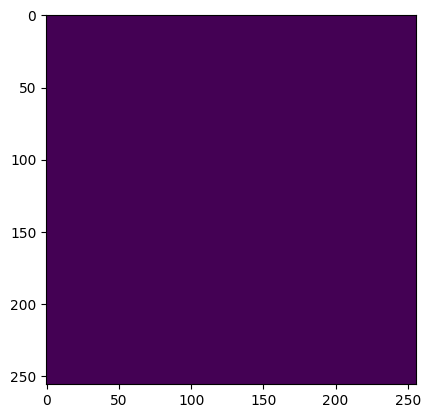

mask


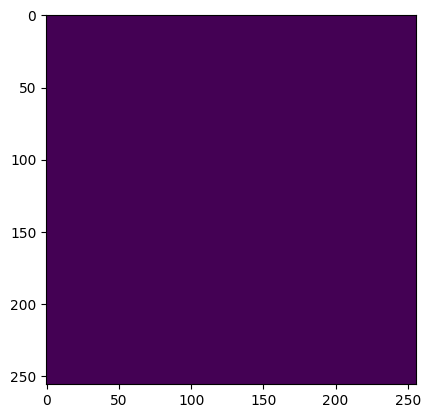

predict


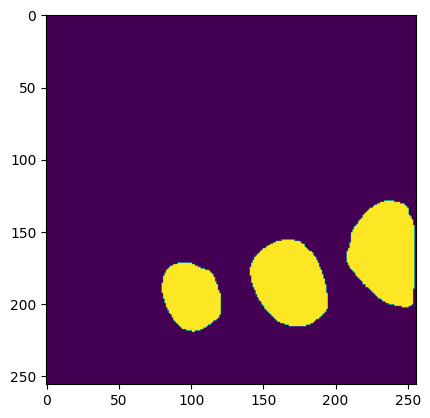

mask


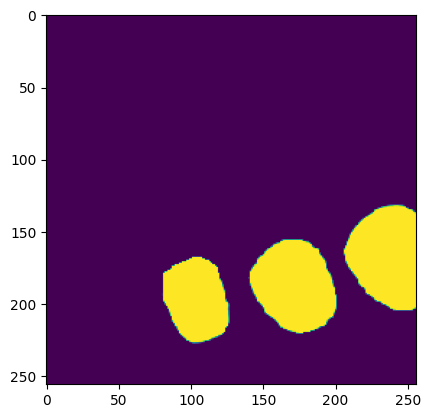

predict


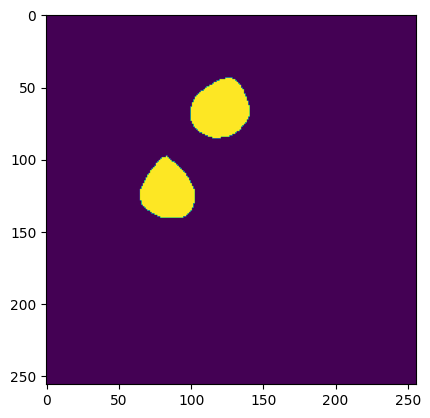

mask


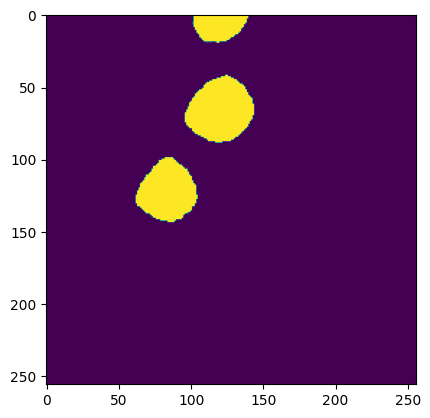

predict


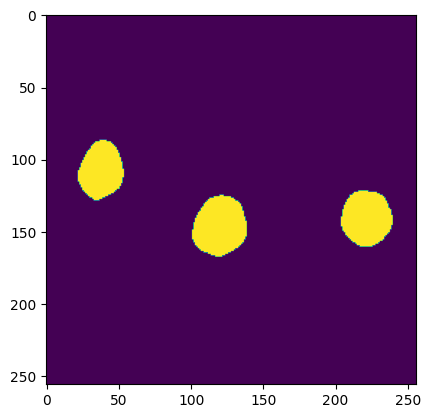

mask


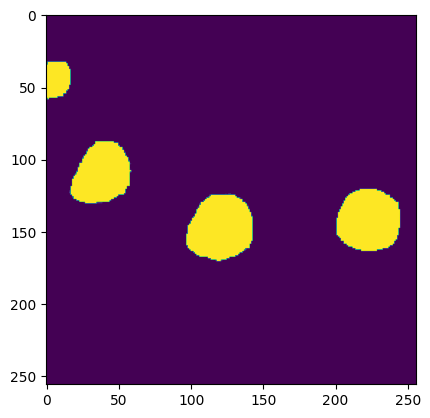

predict


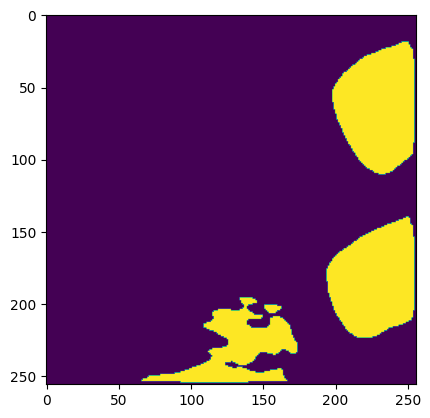

mask


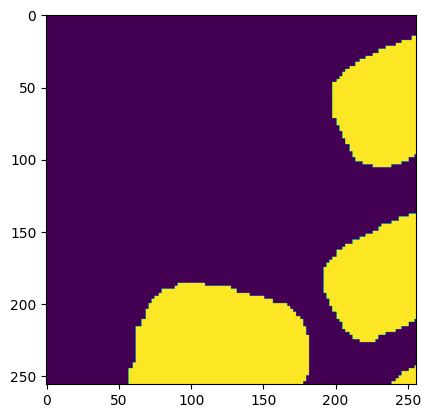

Validation:
	cost time: 5.22352933883667
---------------SAVE MODEL-----------------
	Save model: 12
-----------------------------------------


 24%|██▎       | 13/55 [07:11<23:07, 33.03s/it]

epoch/iterator num: 13/42
	Run cost 0.012904 sec
IOU: 20.023101806640625, Dice: 1.8859376907348633
-----------------------------------------
predict


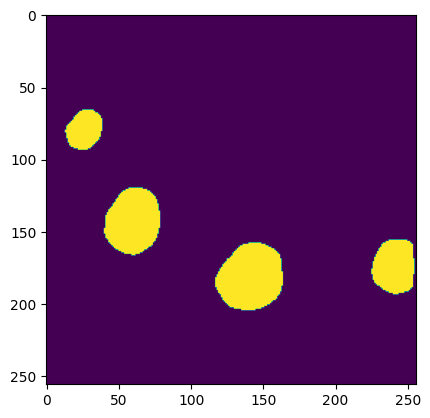

mask


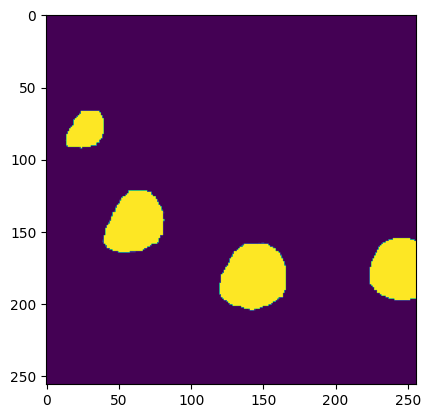

predict


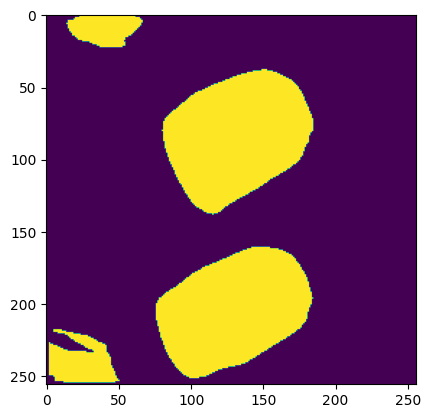

mask


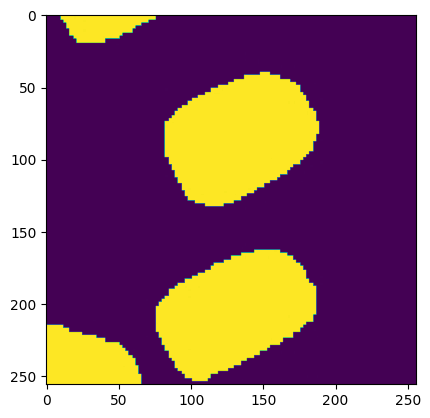

predict


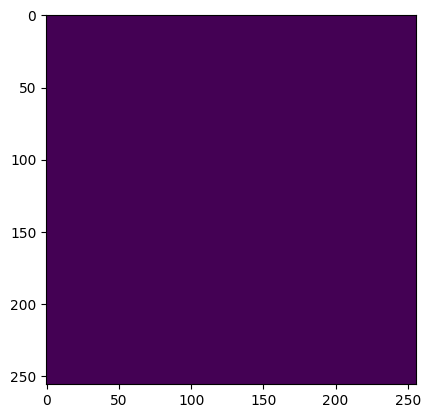

mask


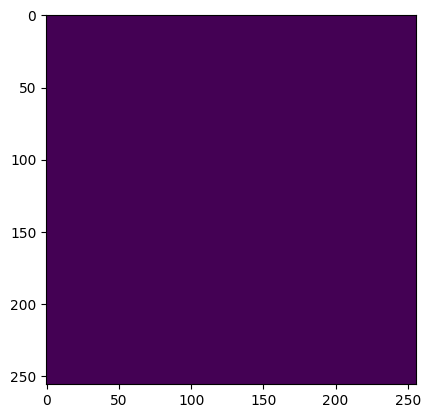

predict


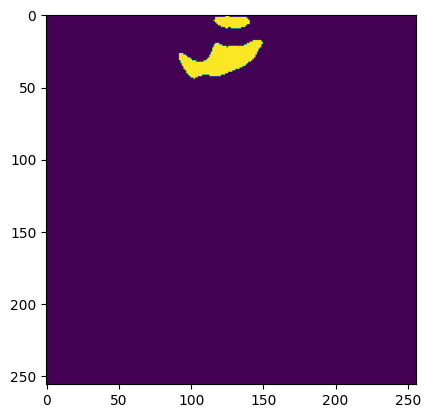

mask


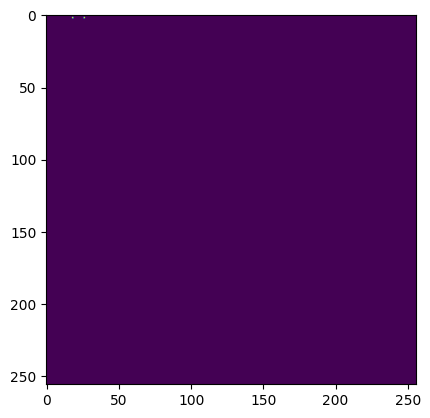

predict


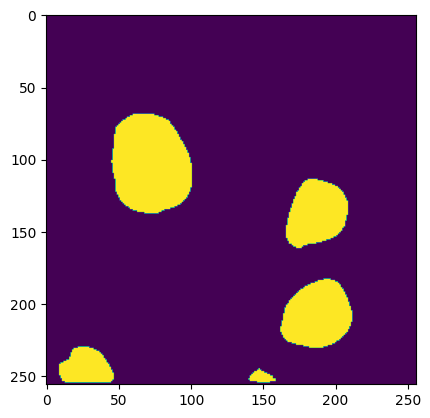

mask


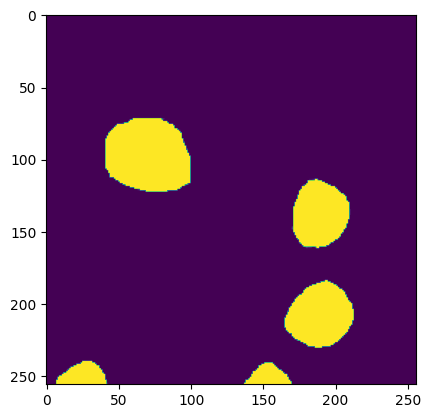

predict


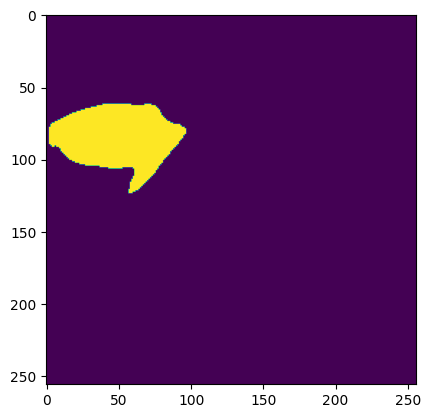

mask


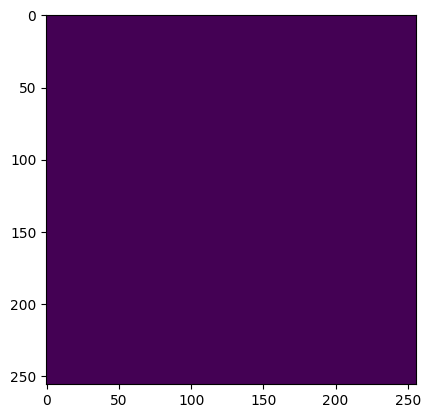

predict


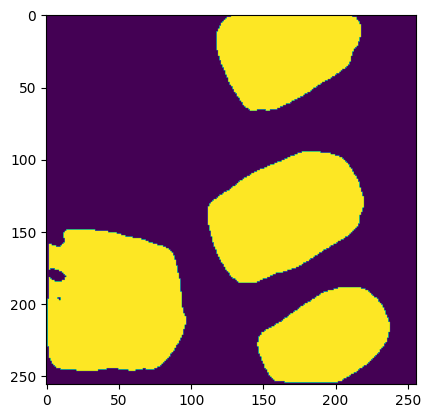

mask


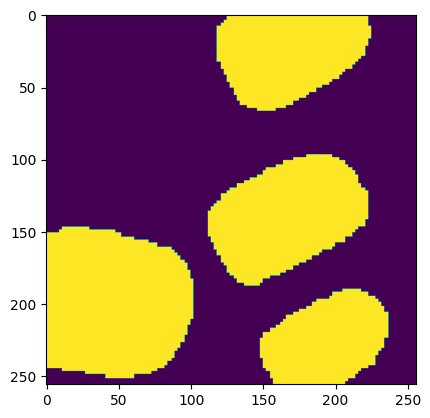

Validation:
	cost time: 5.62302041053772
---------------SAVE MODEL-----------------
	Save model: 13
-----------------------------------------


 25%|██▌       | 14/55 [07:44<22:37, 33.10s/it]

epoch/iterator num: 14/45
	Run cost 0.014828 sec
IOU: 18.69736099243164, Dice: 1.9159976243972778
-----------------------------------------
predict


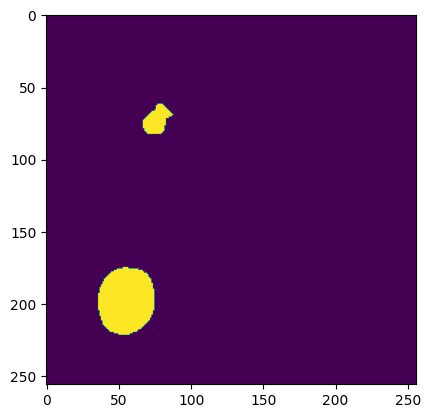

mask


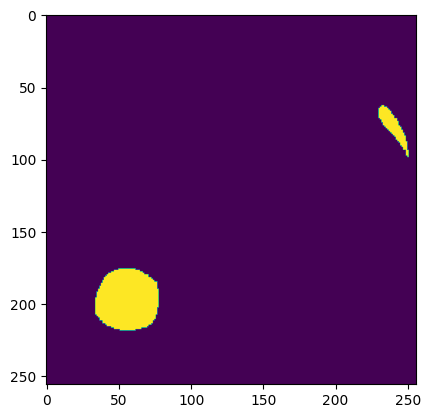

predict


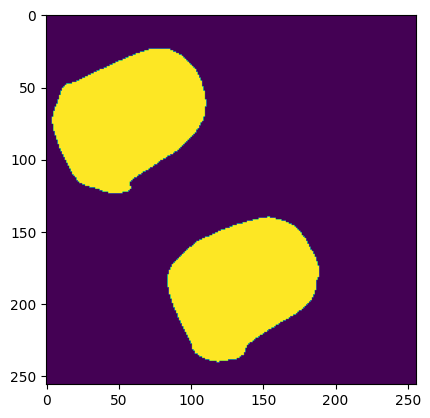

mask


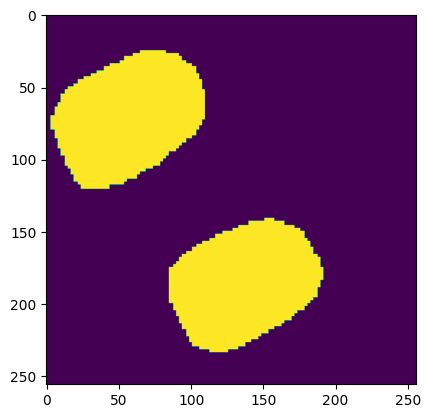

predict


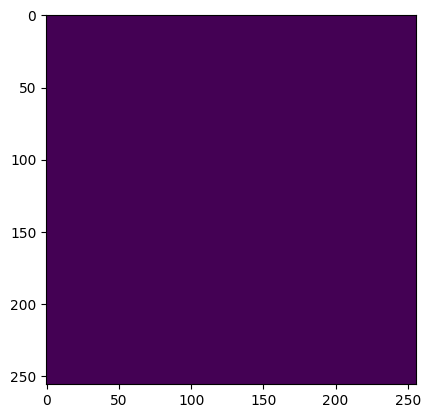

mask


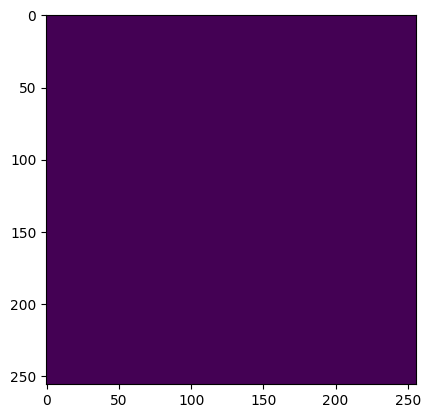

predict


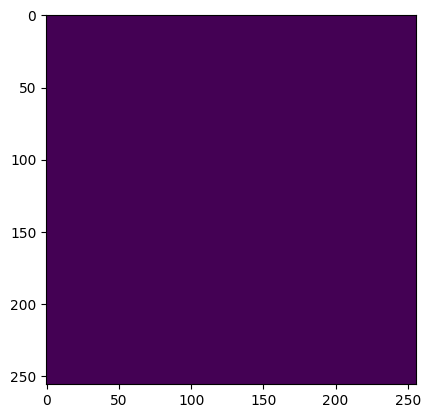

mask


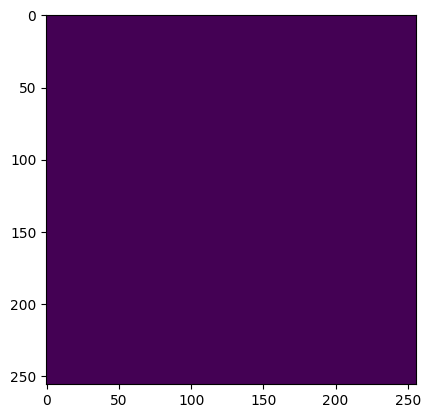

predict


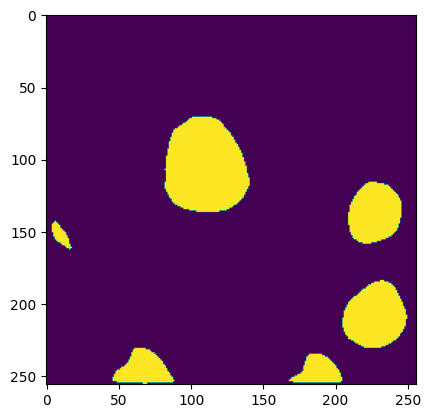

mask


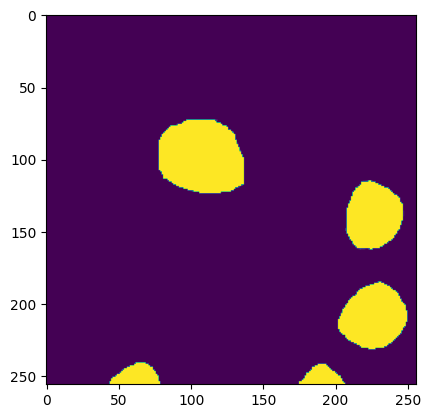

predict


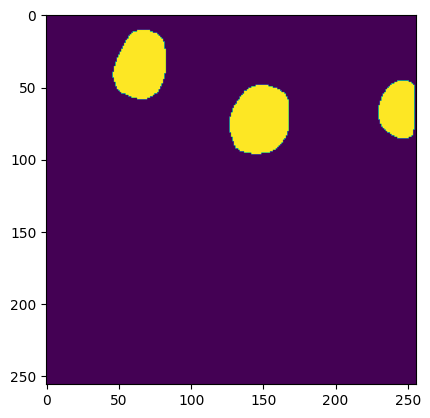

mask


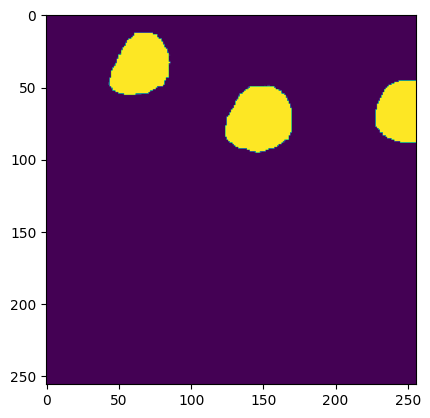

predict


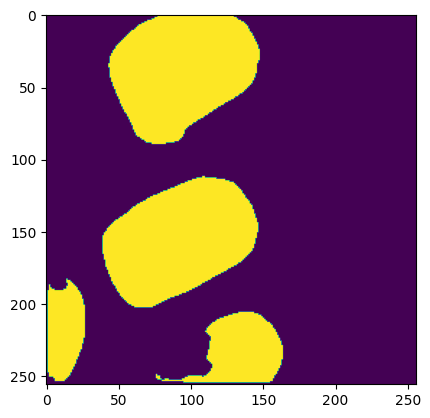

mask


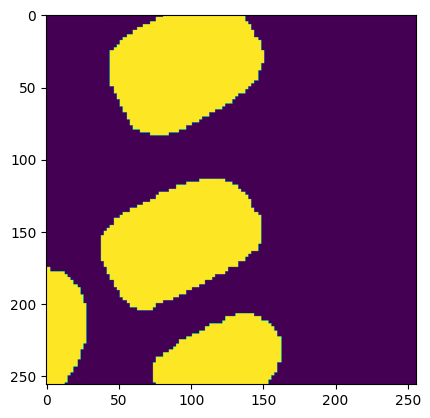

Validation:
	cost time: 5.164456367492676
---------------SAVE MODEL-----------------
	Save model: 14
-----------------------------------------


 27%|██▋       | 15/55 [08:17<22:07, 33.19s/it]

epoch/iterator num: 15/48
	Run cost 0.013806 sec
IOU: 21.10542106628418, Dice: 1.9103565216064453
-----------------------------------------
predict


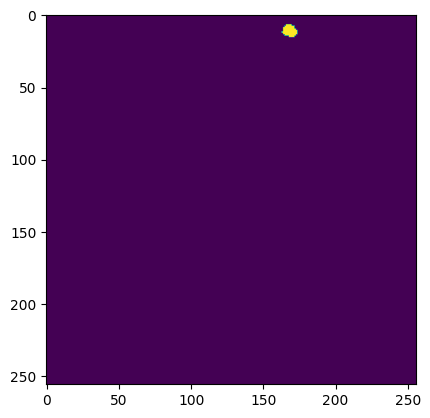

mask


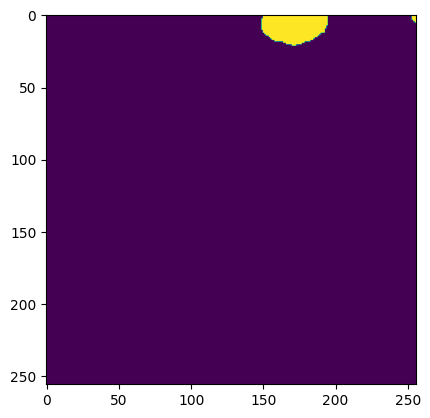

predict


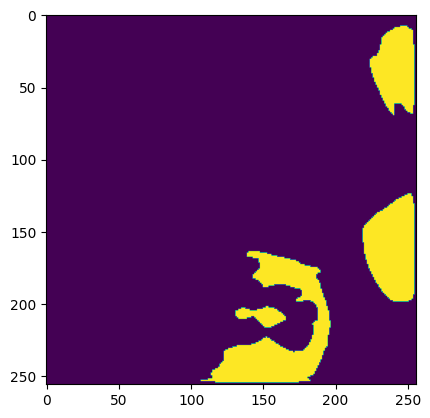

mask


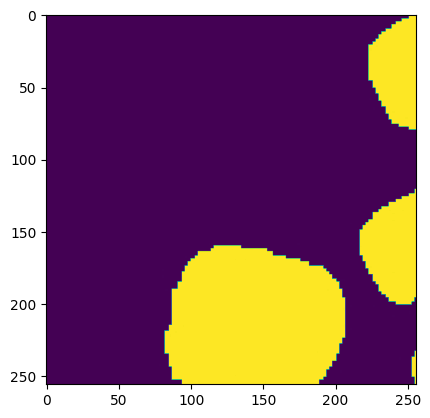

predict


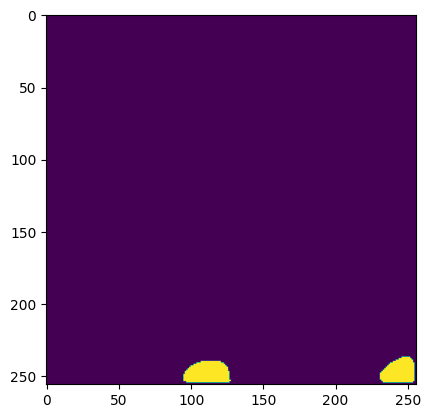

mask


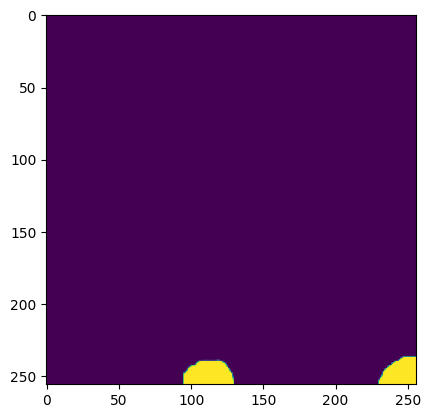

predict


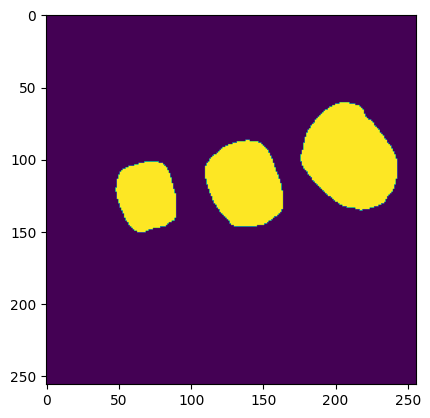

mask


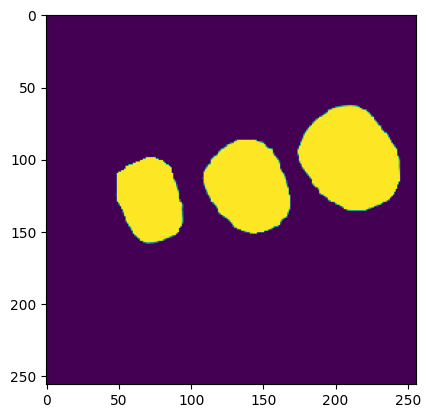

predict


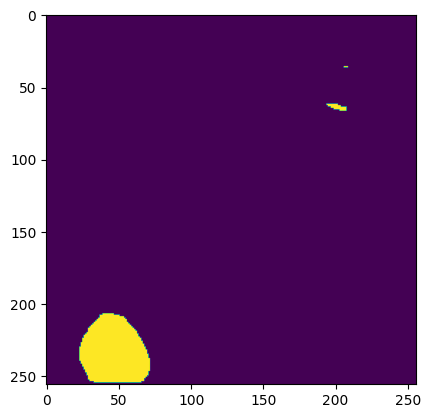

mask


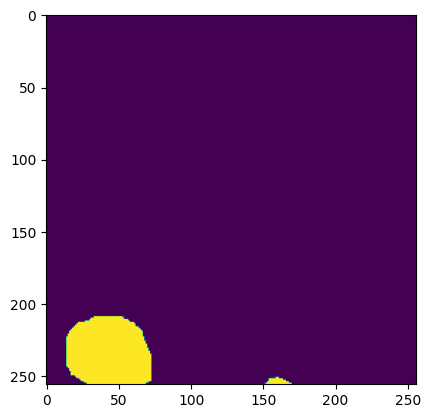

predict


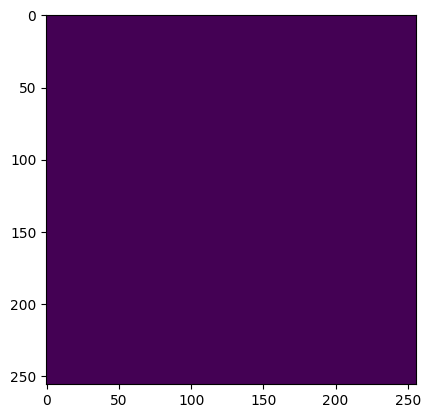

mask


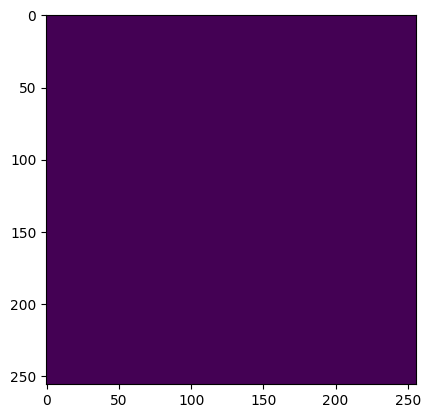

predict


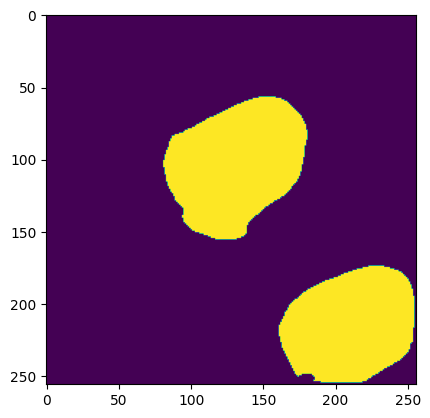

mask


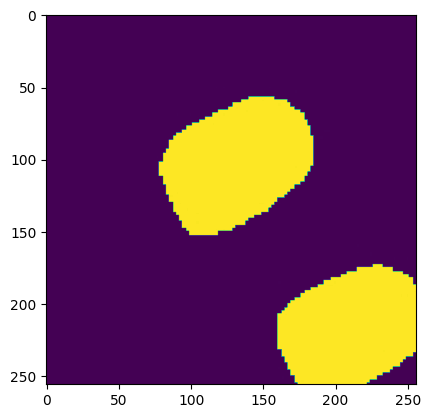

 29%|██▉       | 16/55 [08:50<21:31, 33.11s/it]

Validation:
	cost time: 5.074787616729736
epoch/iterator num: 16/52
	Run cost 0.012694 sec
IOU: 35.64934539794922, Dice: 1.9550580978393555
-----------------------------------------
predict


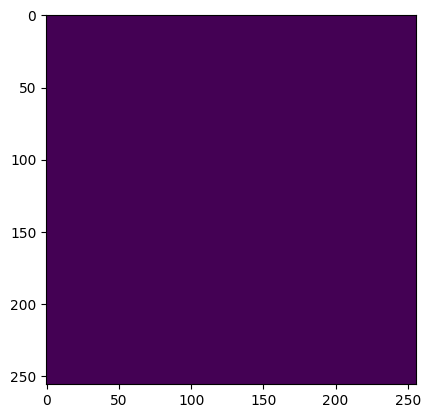

mask


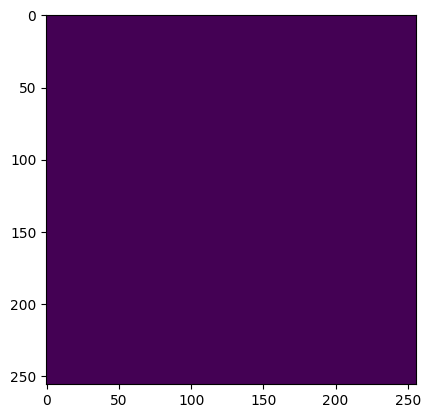

predict


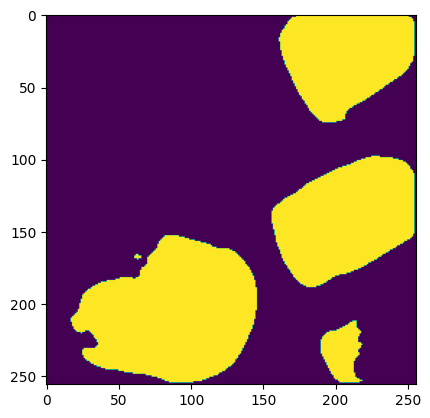

mask


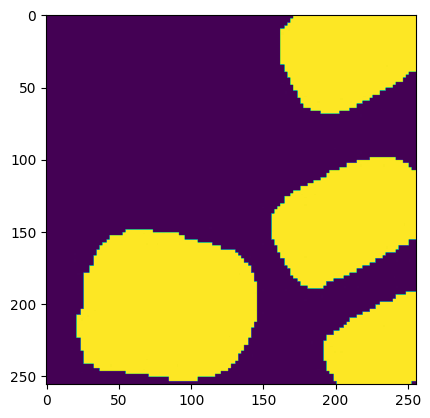

predict


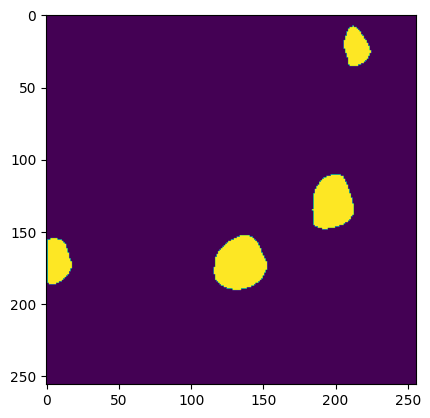

mask


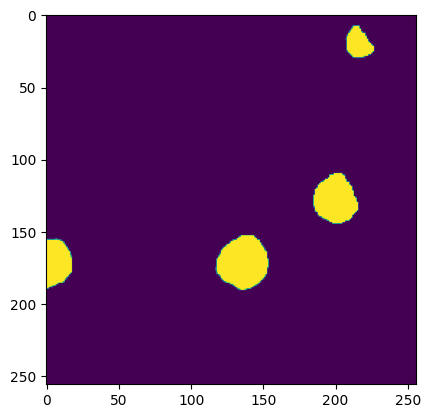

predict


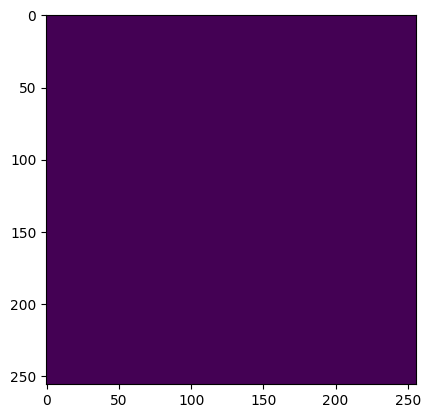

mask


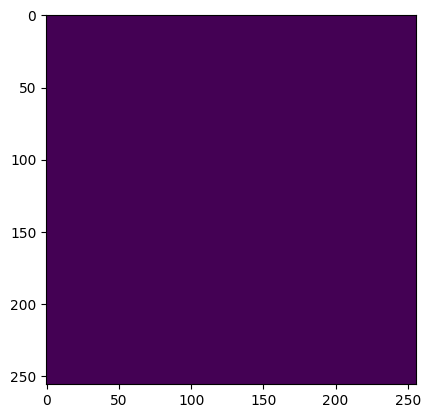

predict


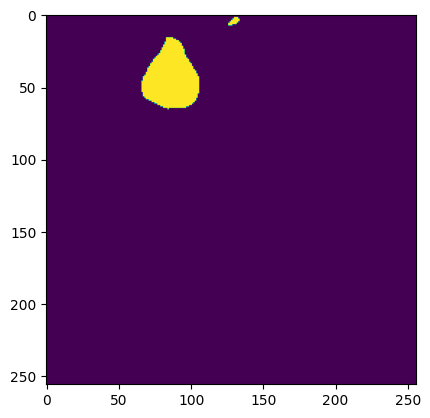

mask


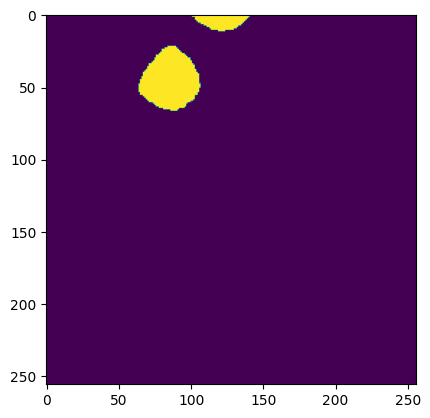

predict


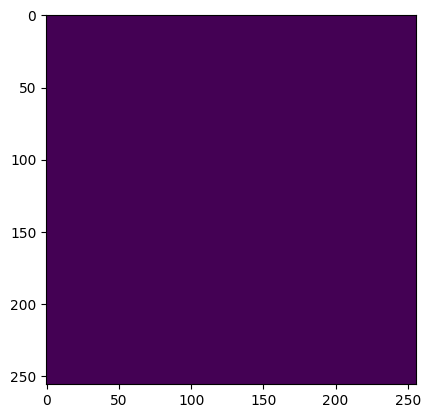

mask


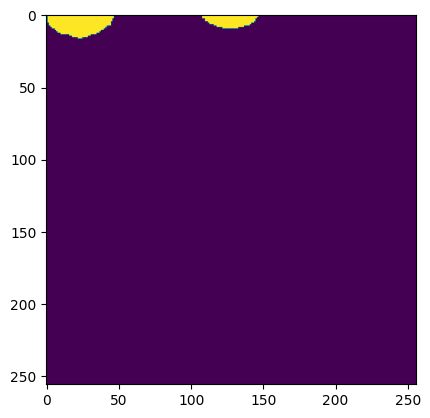

predict


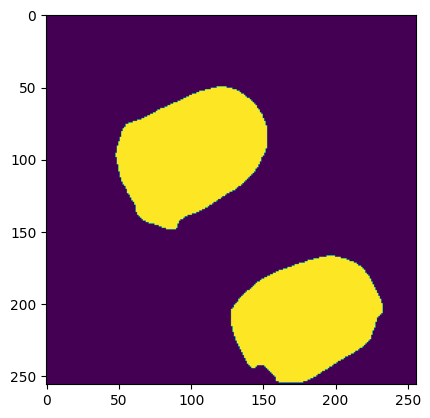

mask


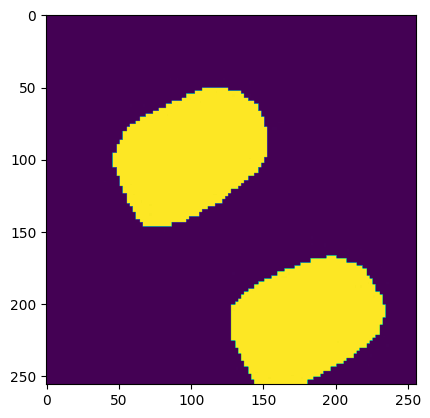

 31%|███       | 17/55 [09:23<20:58, 33.12s/it]

Validation:
	cost time: 5.245900869369507
epoch/iterator num: 17/55
	Run cost 0.013185 sec
IOU: 18.17229652404785, Dice: 1.9036650657653809
-----------------------------------------
predict


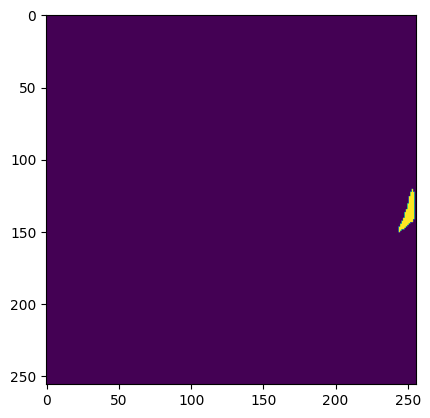

mask


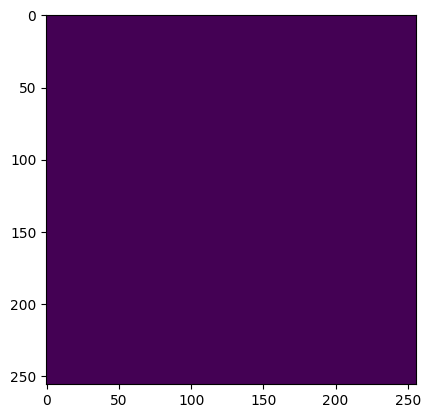

predict


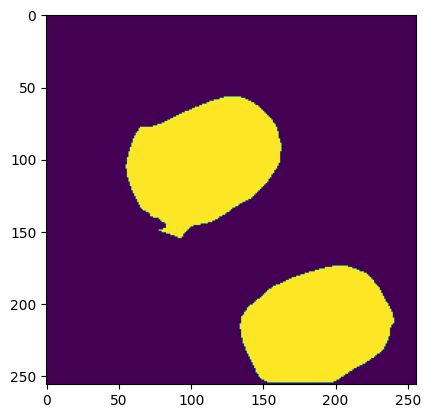

mask


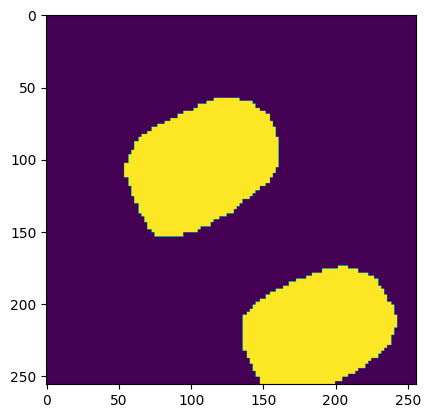

predict


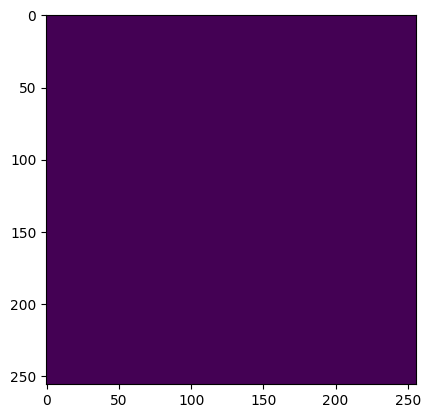

mask


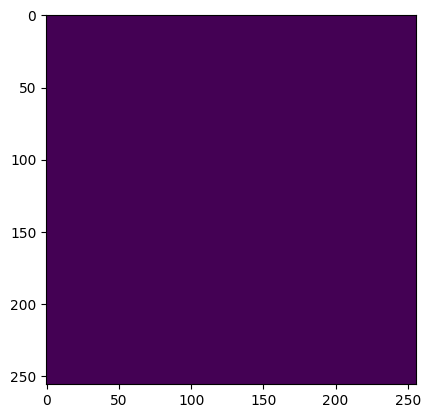

predict


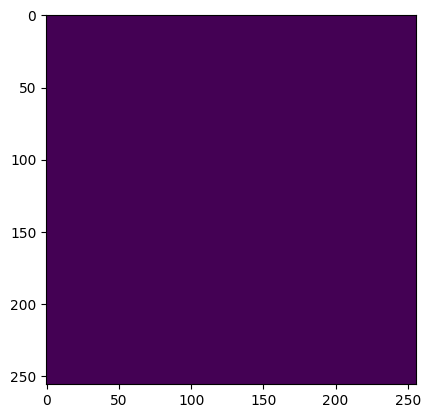

mask


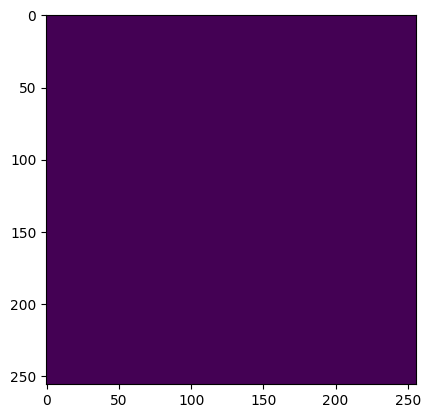

predict


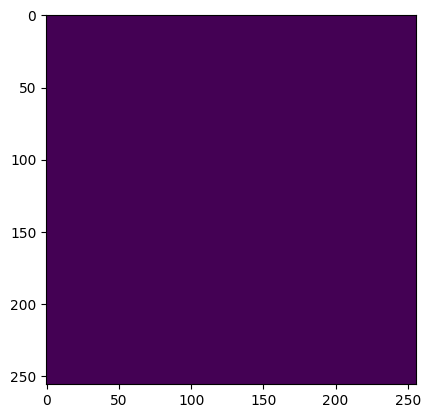

mask


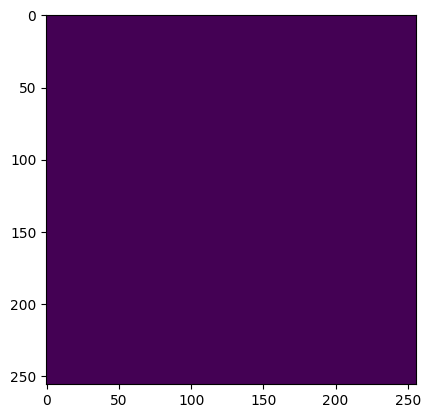

predict


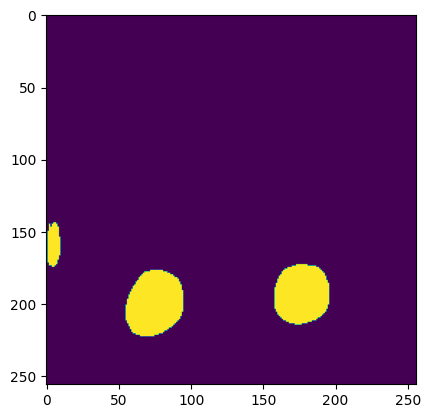

mask


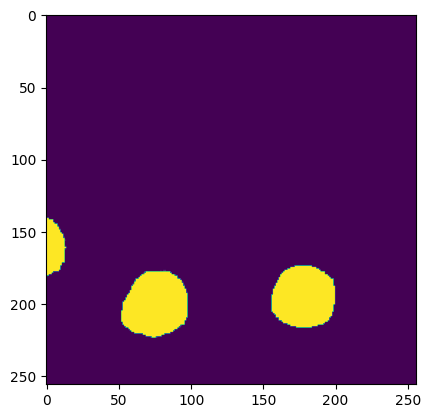

predict


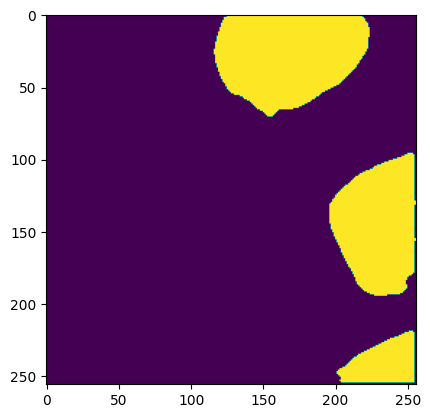

mask


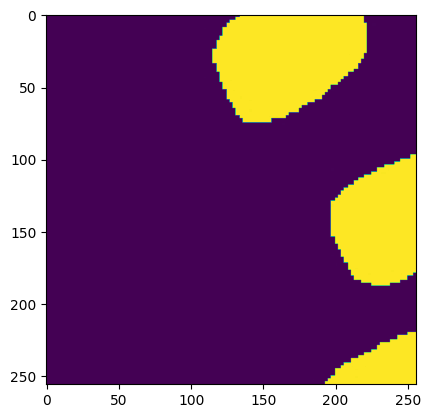

 33%|███▎      | 18/55 [09:56<20:17, 32.90s/it]

Validation:
	cost time: 5.102527856826782
epoch/iterator num: 18/58
	Run cost 0.008675 sec
IOU: 31.153148651123047, Dice: 1.9210201501846313
-----------------------------------------
predict


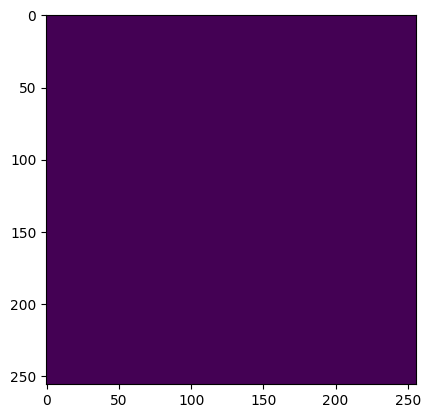

mask


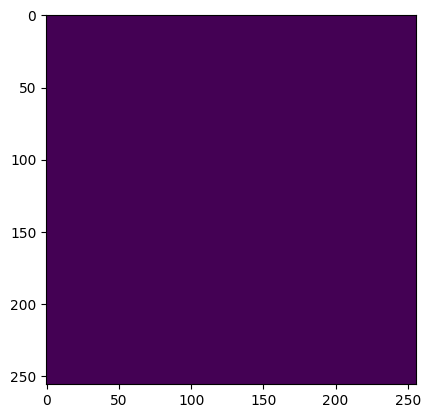

predict


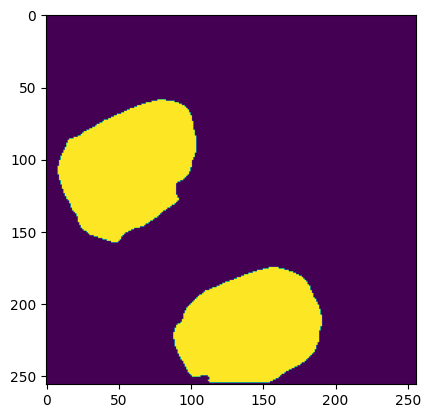

mask


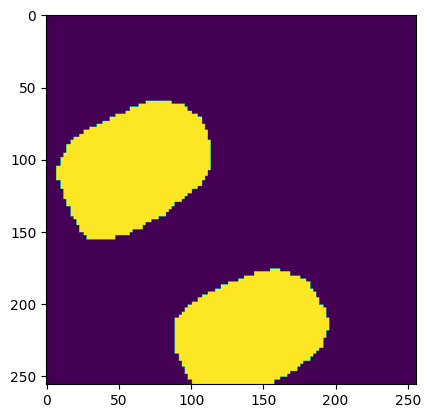

predict


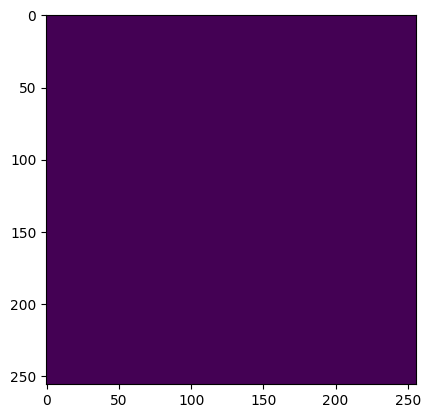

mask


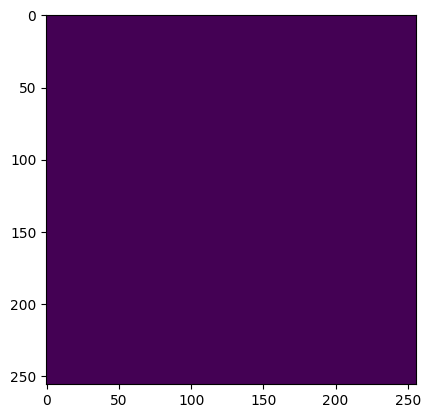

predict


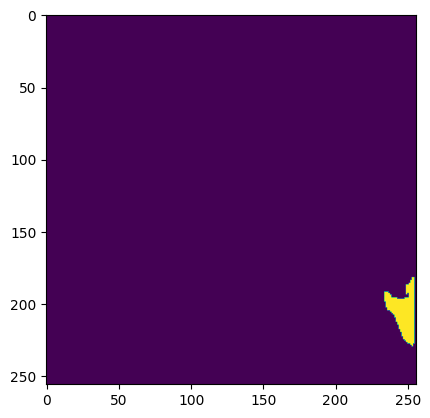

mask


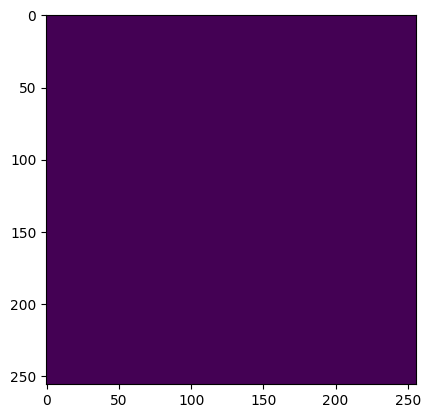

predict


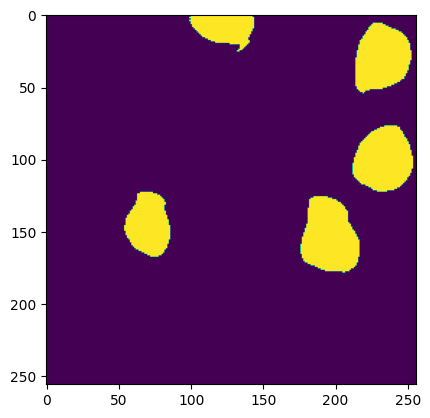

mask


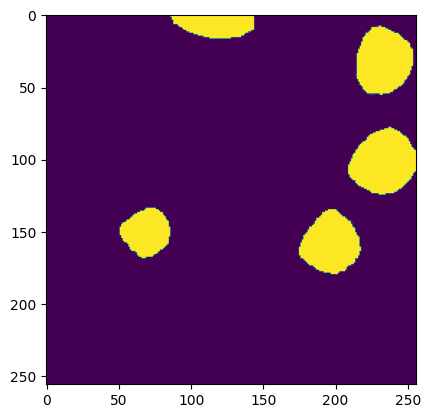

predict


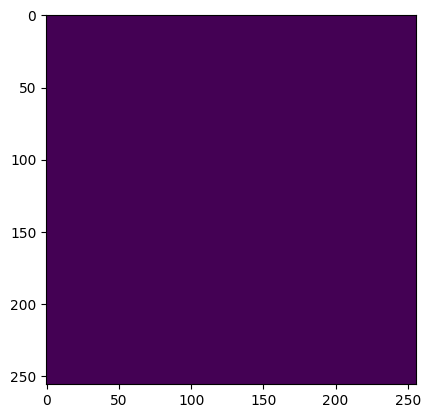

mask


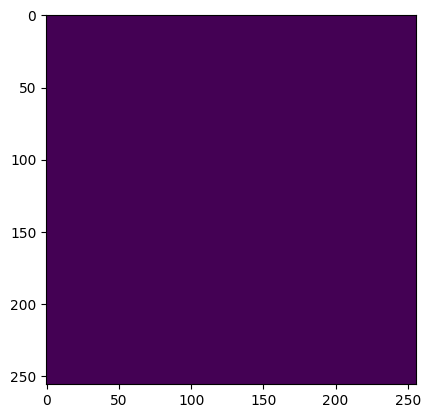

predict


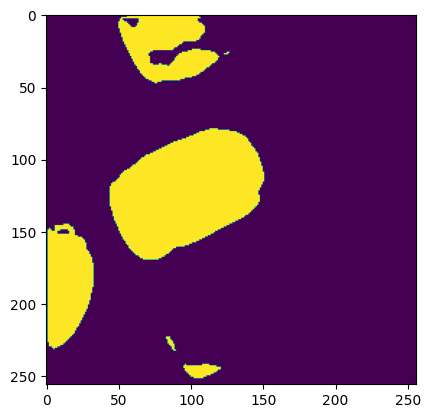

mask


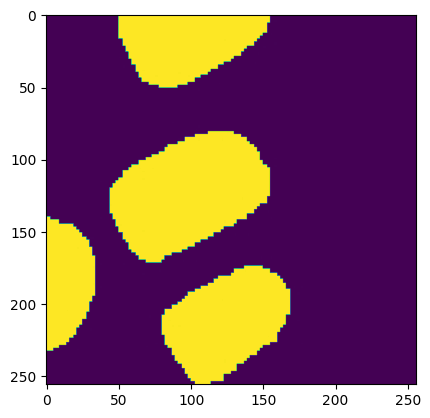

 35%|███▍      | 19/55 [10:29<19:45, 32.92s/it]

Validation:
	cost time: 5.417340040206909
epoch/iterator num: 19/61
	Run cost 0.010455 sec
IOU: 25.6009521484375, Dice: 1.9114036560058594
-----------------------------------------
predict


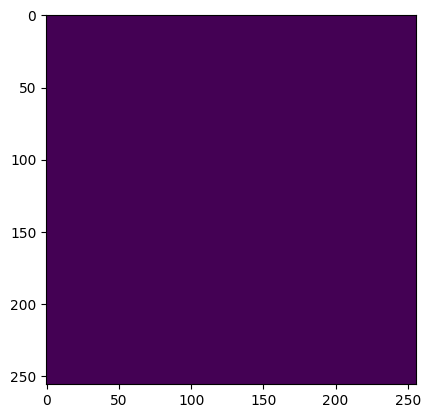

mask


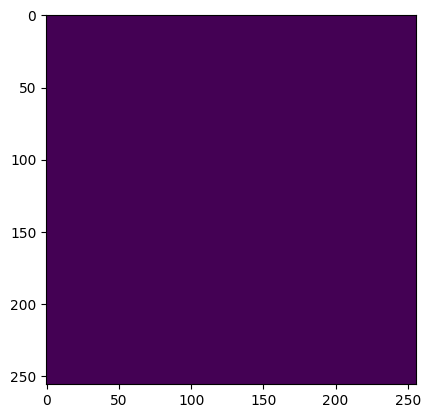

predict


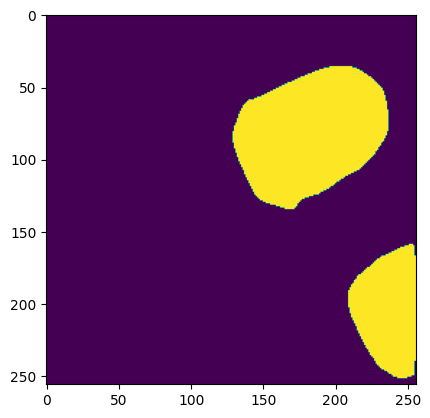

mask


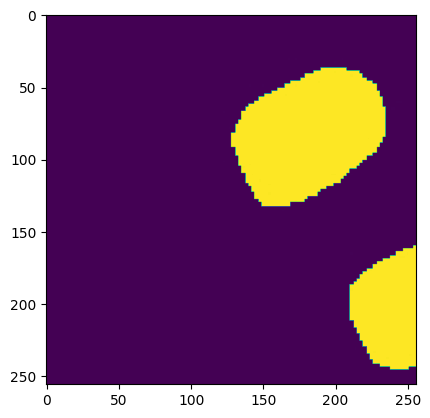

predict


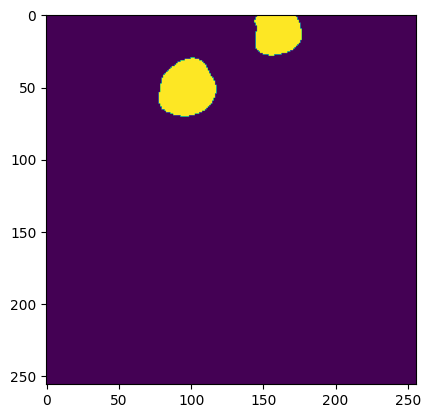

mask


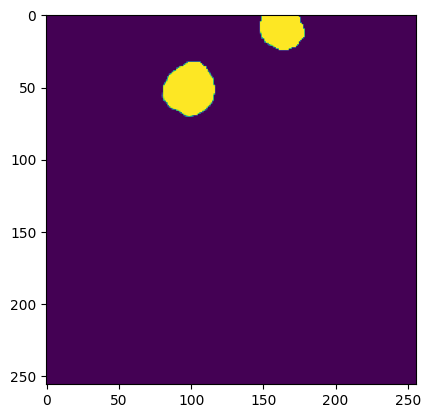

predict


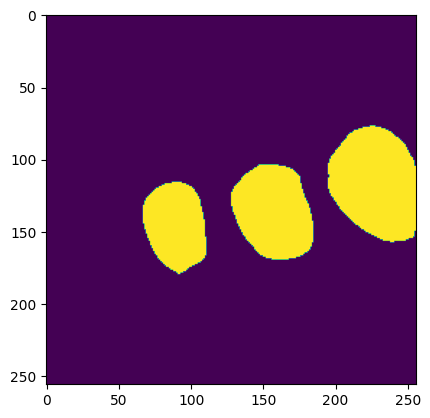

mask


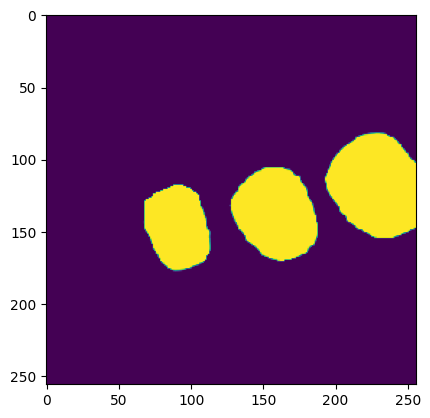

predict


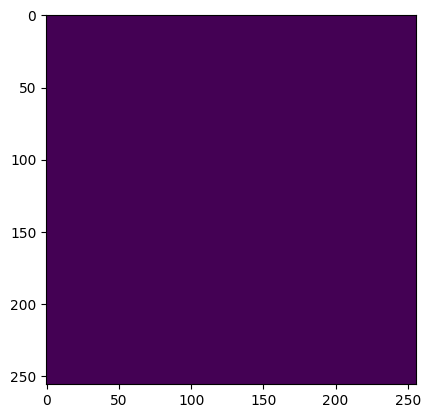

mask


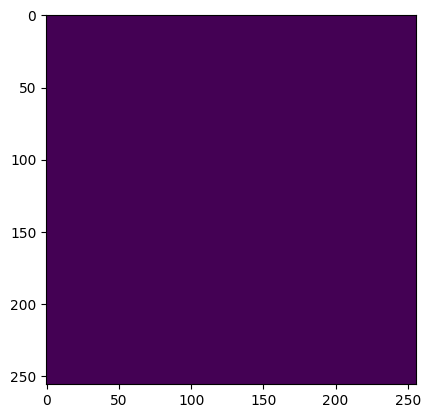

predict


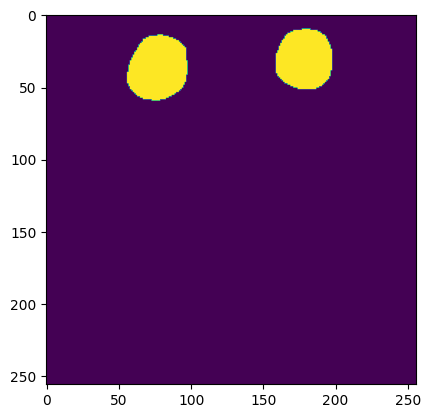

mask


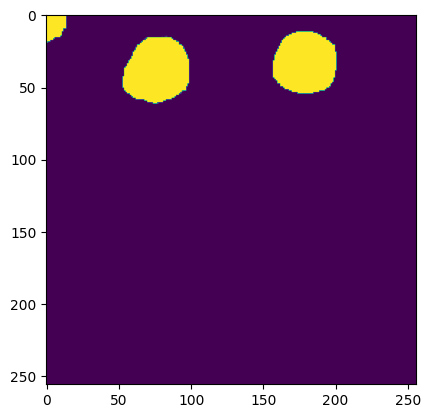

predict


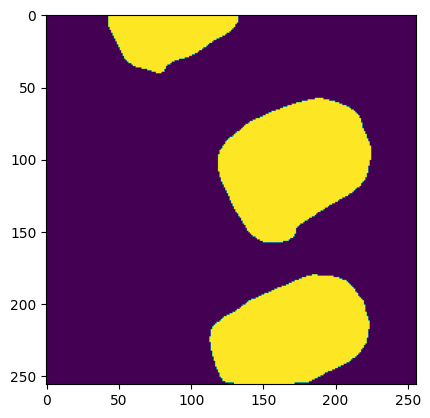

mask


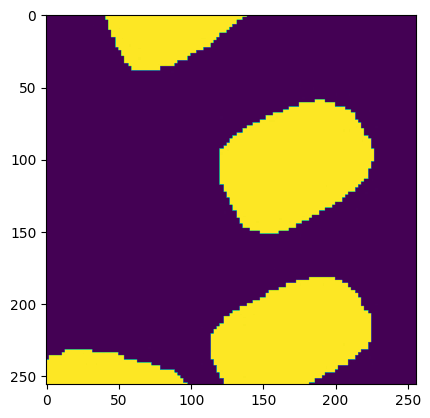

Validation:
	cost time: 5.313188314437866
---------------SAVE MODEL-----------------
	Save model: 19
-----------------------------------------


 36%|███▋      | 20/55 [11:02<19:12, 32.93s/it]

epoch/iterator num: 20/65
	Run cost 0.010603 sec
IOU: 26.81719970703125, Dice: 1.9278312921524048
-----------------------------------------
predict


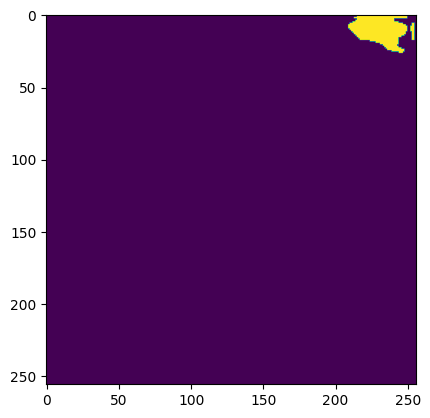

mask


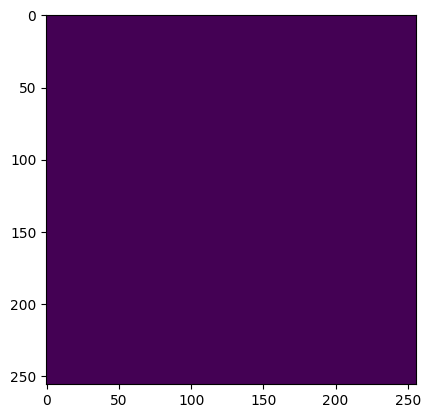

predict


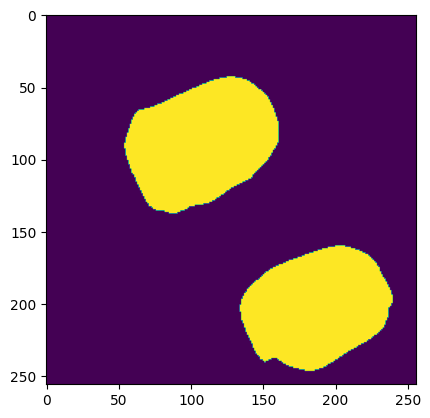

mask


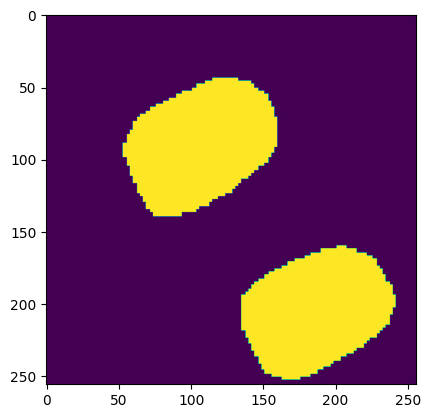

predict


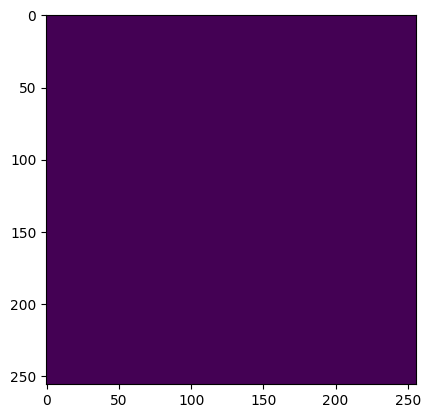

mask


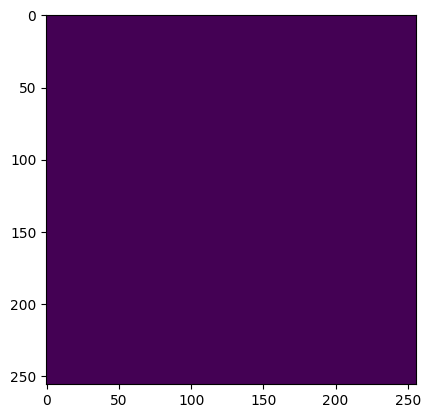

predict


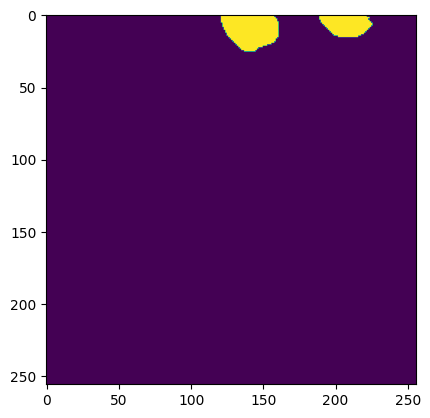

mask


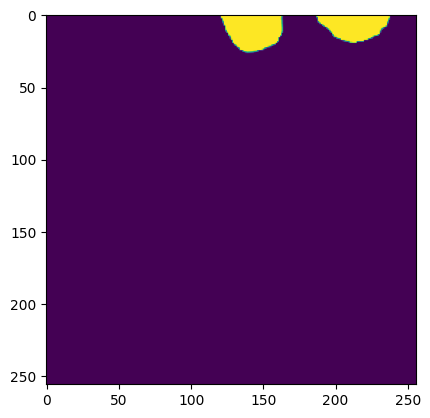

predict


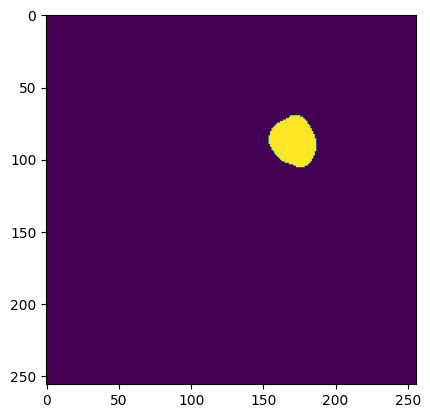

mask


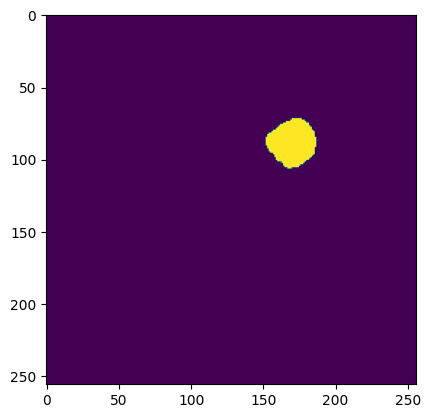

predict


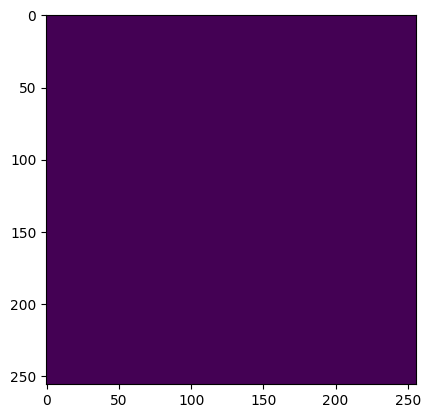

mask


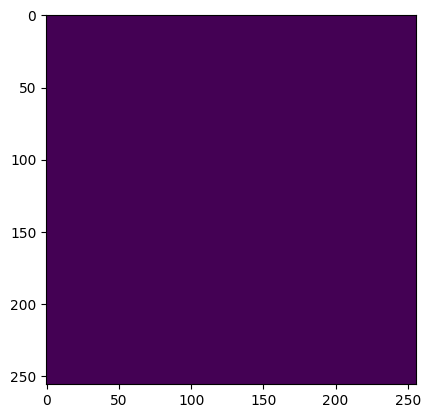

predict


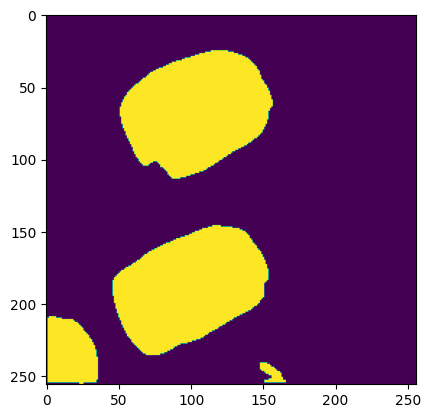

mask


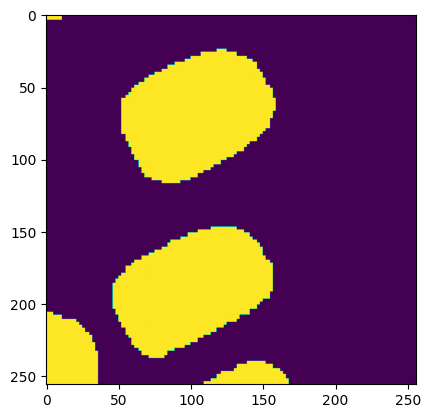

 38%|███▊      | 21/55 [11:34<18:30, 32.65s/it]

Validation:
	cost time: 4.993654489517212
epoch/iterator num: 21/68
	Run cost 0.008606 sec
IOU: 27.52098846435547, Dice: 1.9311249256134033
-----------------------------------------
predict


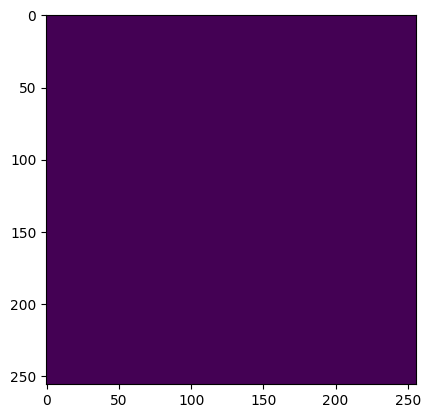

mask


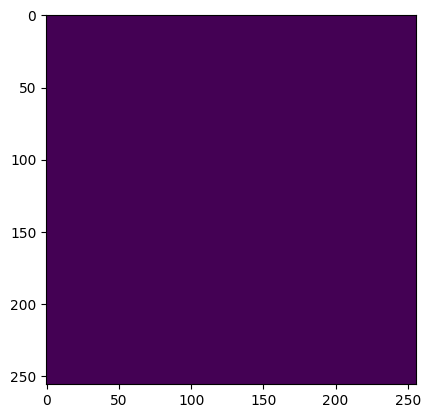

predict


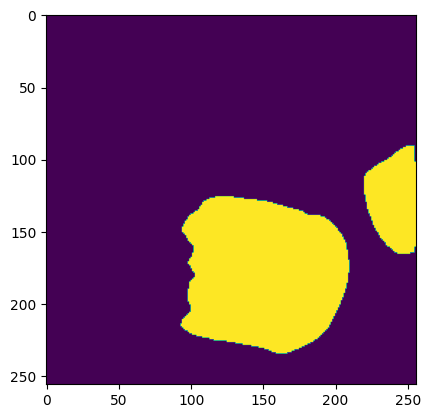

mask


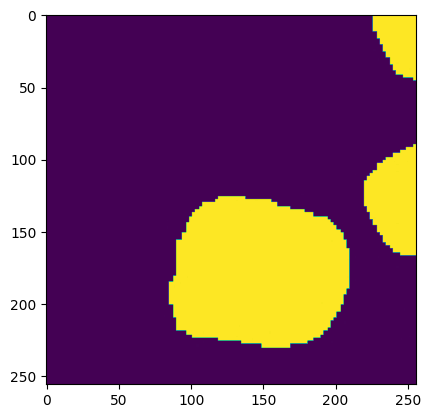

predict


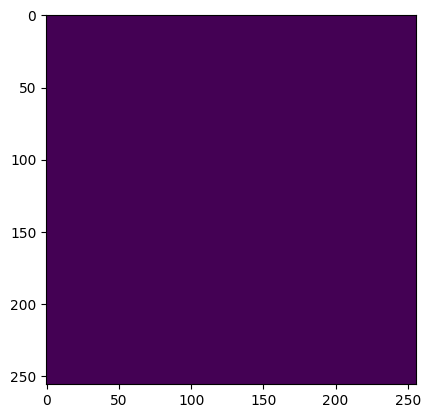

mask


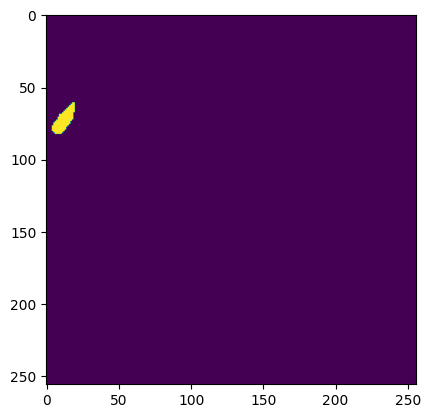

predict


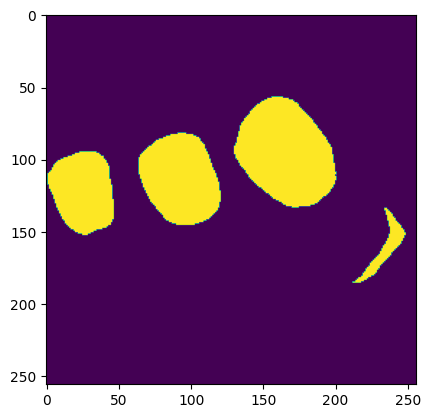

mask


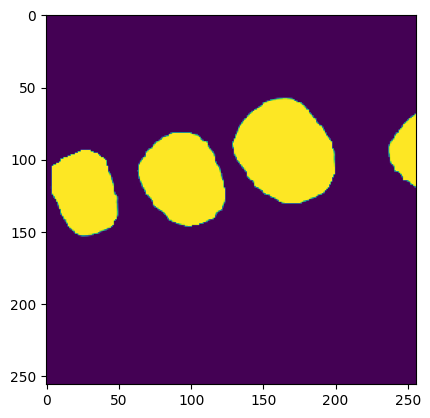

predict


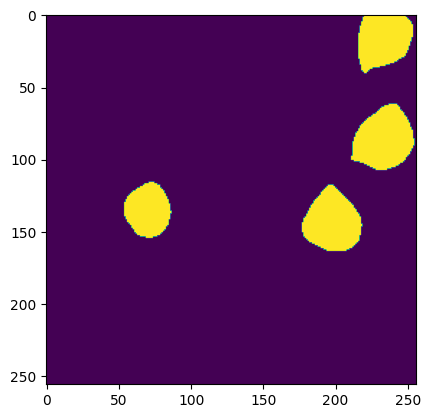

mask


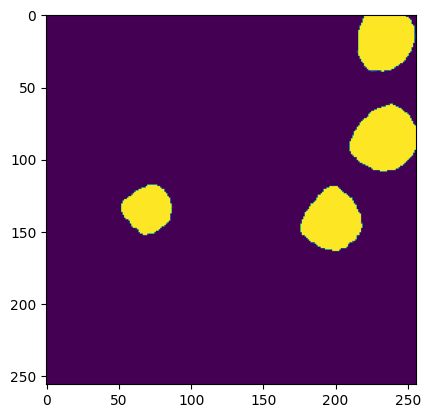

predict


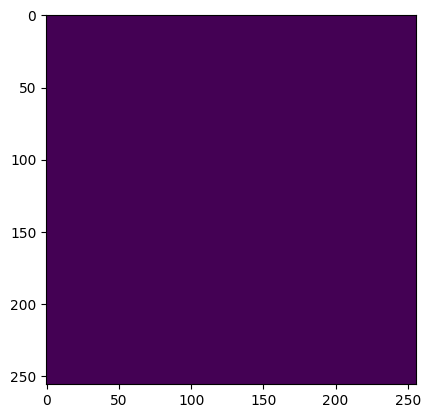

mask


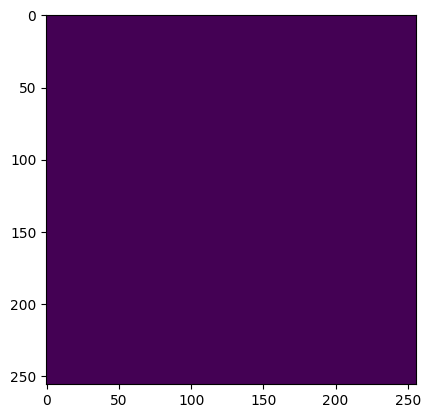

predict


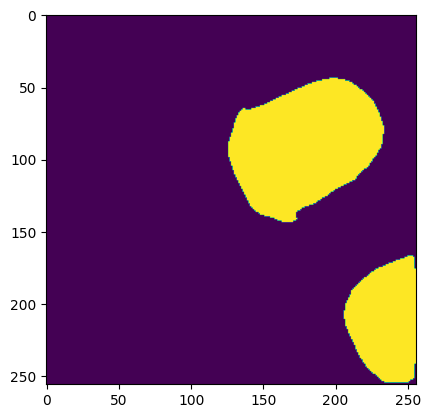

mask


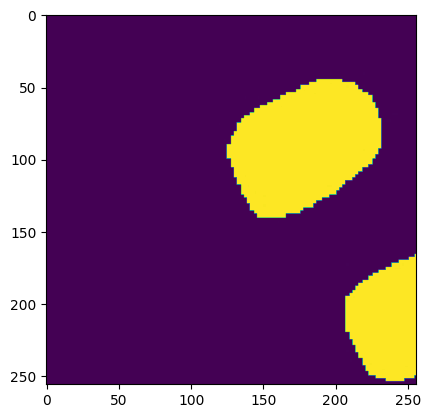

 40%|████      | 22/55 [12:06<17:52, 32.50s/it]

Validation:
	cost time: 4.984543561935425
epoch/iterator num: 22/71
	Run cost 0.011442 sec
IOU: 30.321426391601562, Dice: 1.9110387563705444
-----------------------------------------
predict


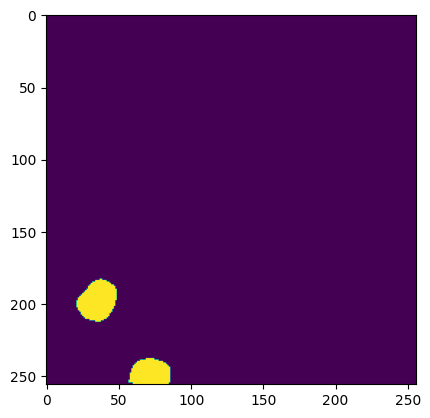

mask


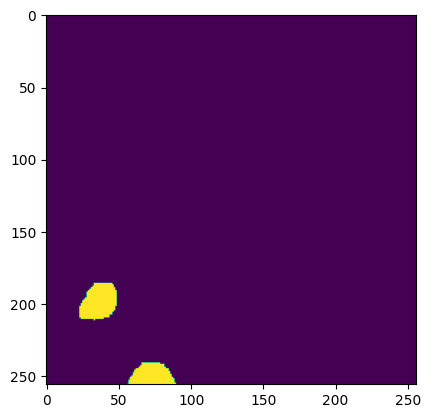

predict


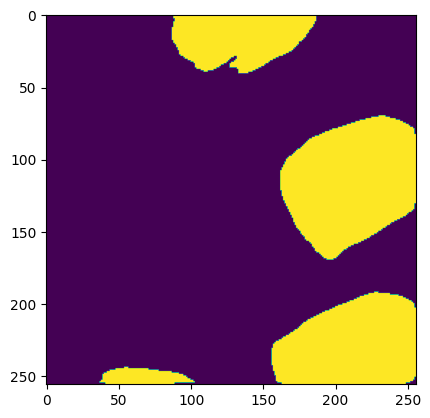

mask


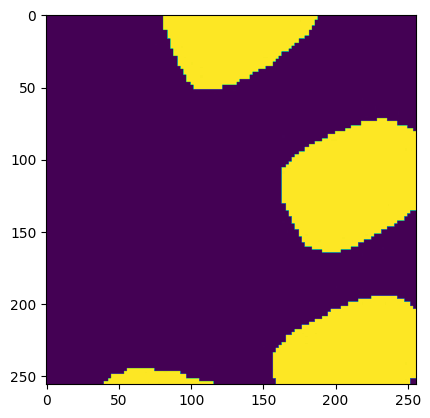

predict


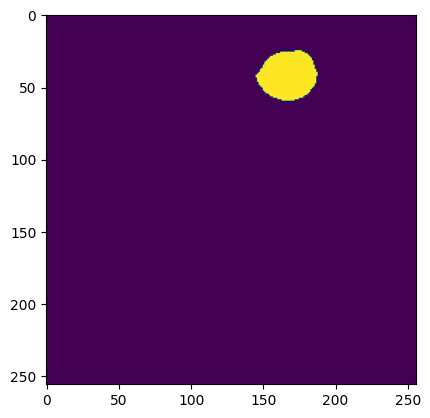

mask


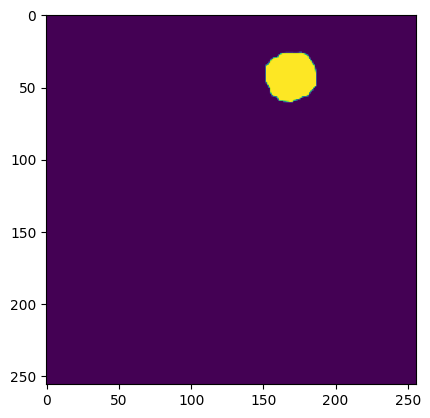

predict


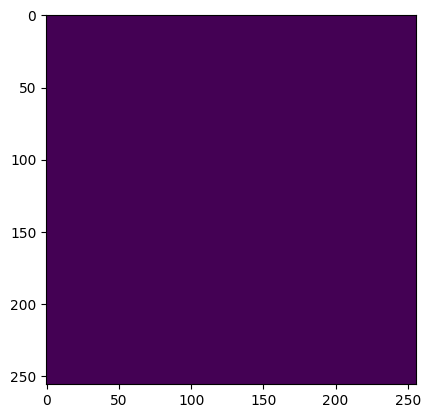

mask


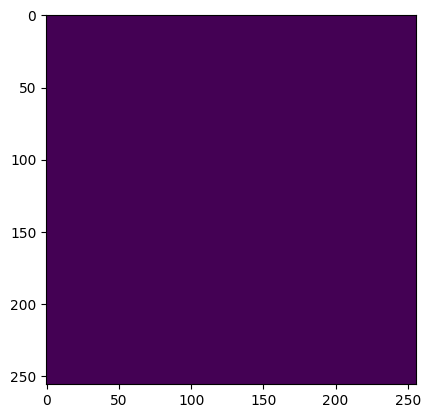

predict


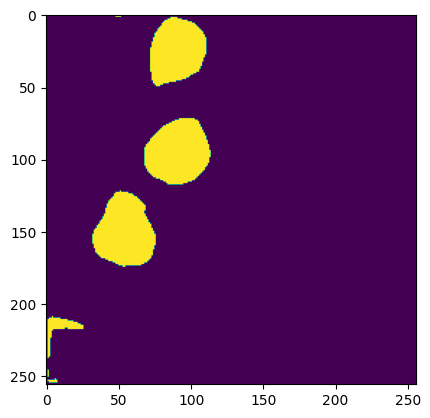

mask


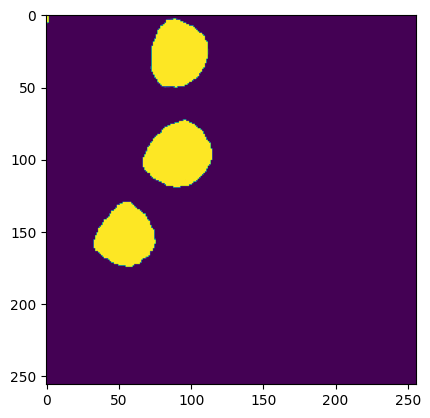

predict


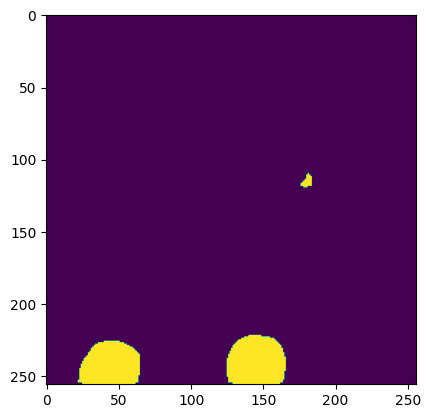

mask


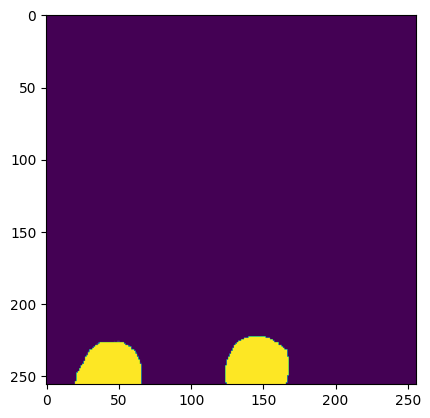

predict


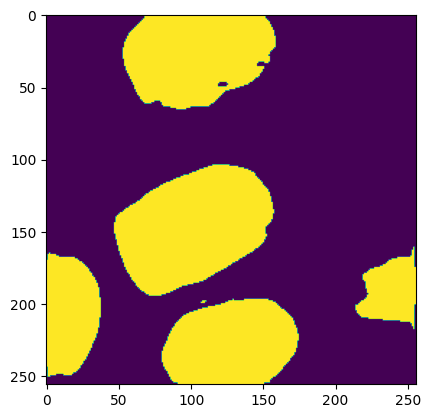

mask


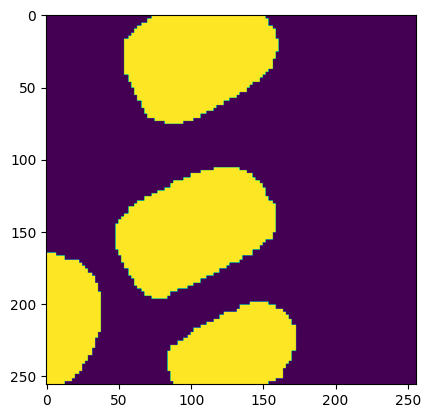

Validation:
	cost time: 5.061963319778442
---------------SAVE MODEL-----------------
	Save model: 22
-----------------------------------------


 42%|████▏     | 23/55 [12:38<17:21, 32.54s/it]

epoch/iterator num: 23/74
	Run cost 0.010653 sec
IOU: 16.921531677246094, Dice: 1.8488718271255493
-----------------------------------------
predict


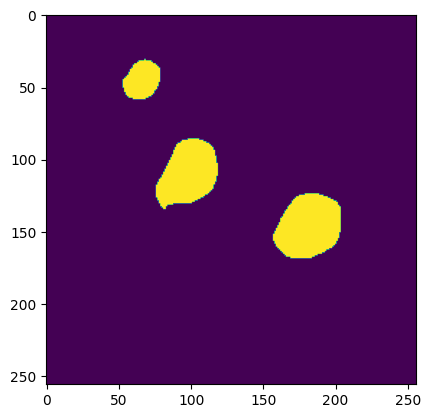

mask


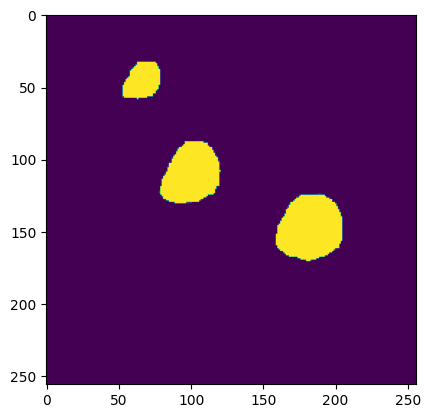

predict


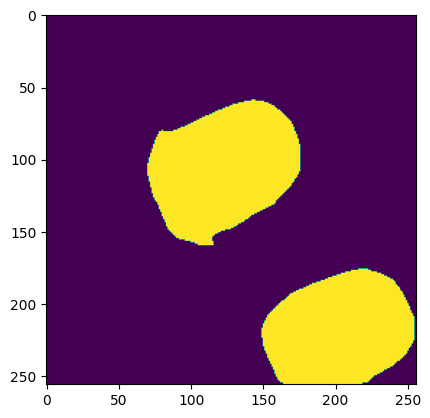

mask


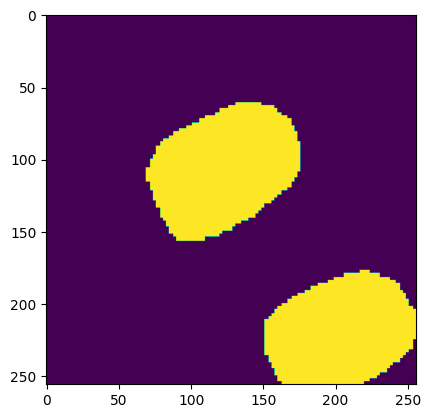

predict


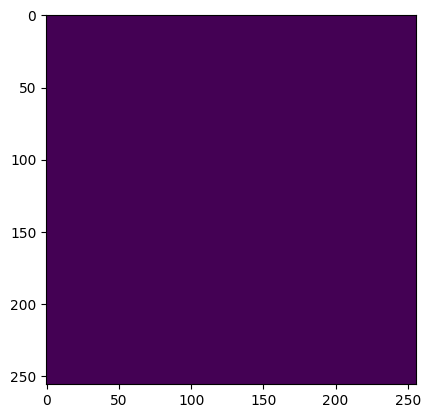

mask


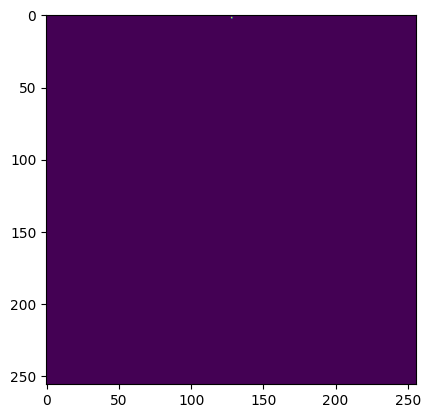

predict


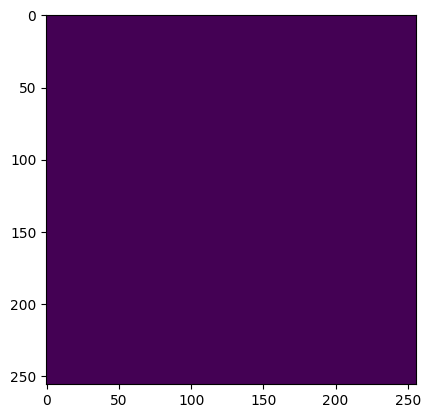

mask


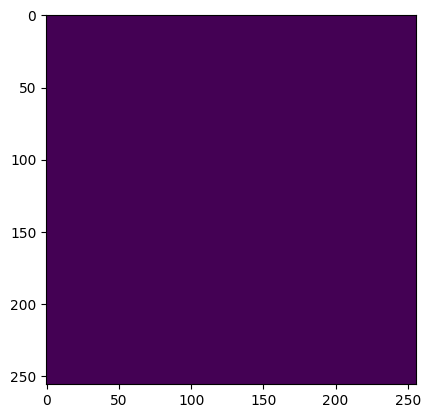

predict


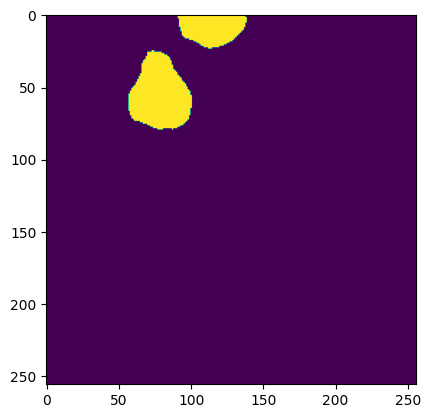

mask


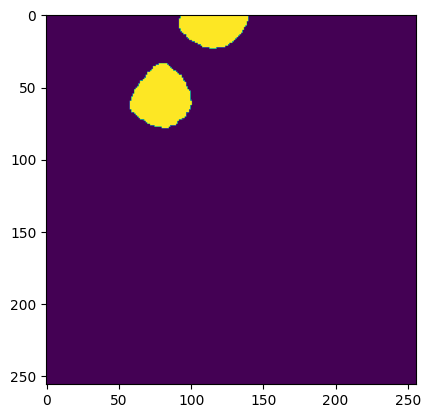

predict


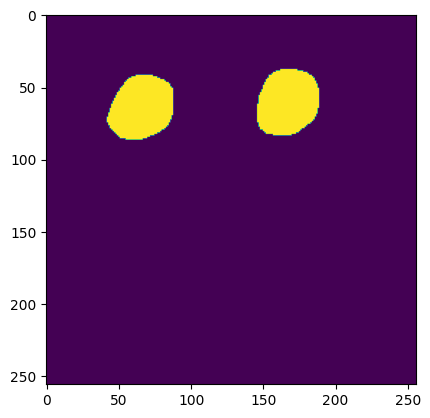

mask


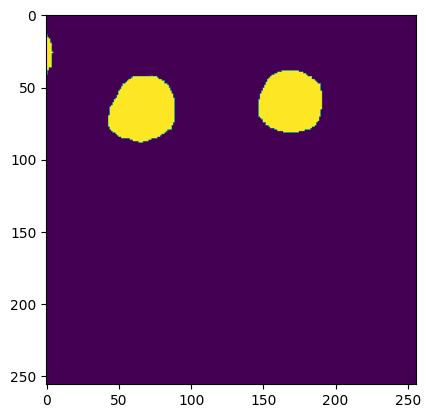

predict


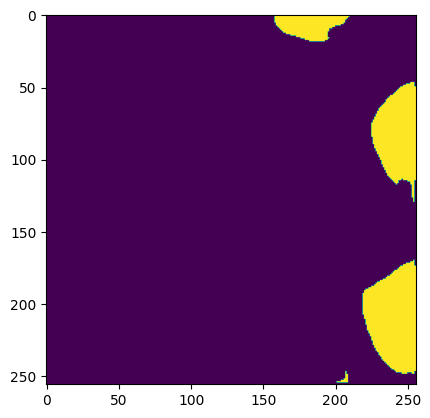

mask


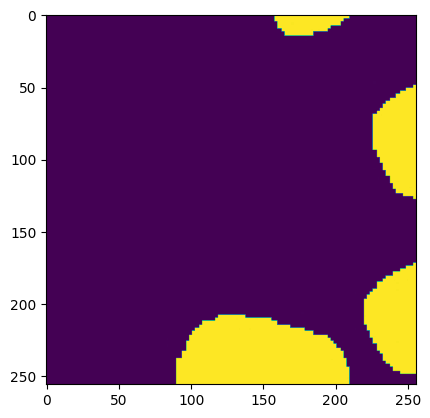

 44%|████▎     | 24/55 [13:11<16:49, 32.58s/it]

Validation:
	cost time: 5.107064485549927
epoch/iterator num: 24/78
	Run cost 0.009453 sec
IOU: 19.05698013305664, Dice: 1.8459397554397583
-----------------------------------------
predict


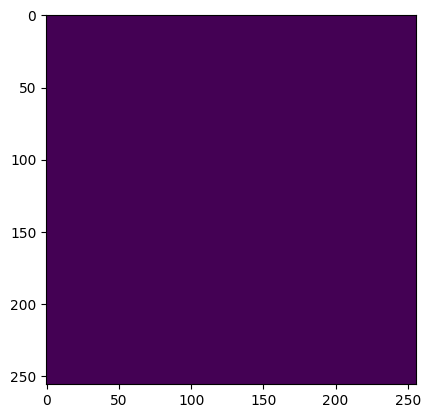

mask


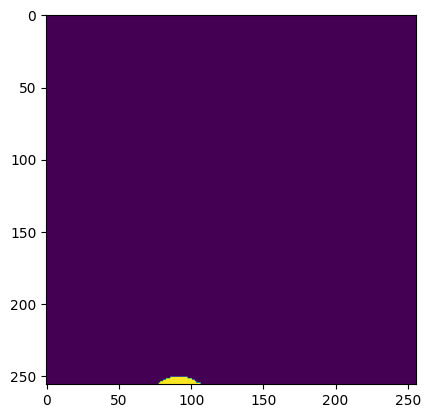

predict


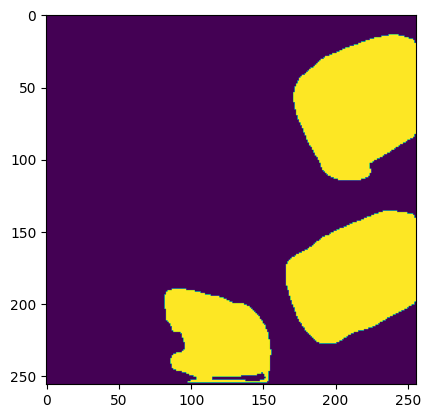

mask


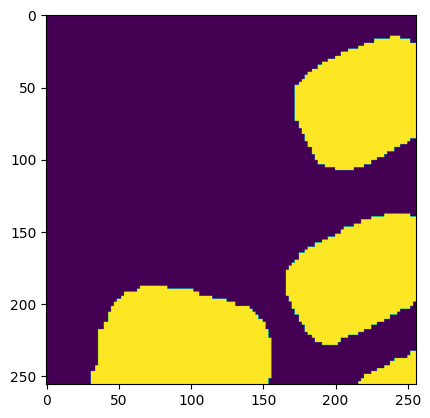

predict


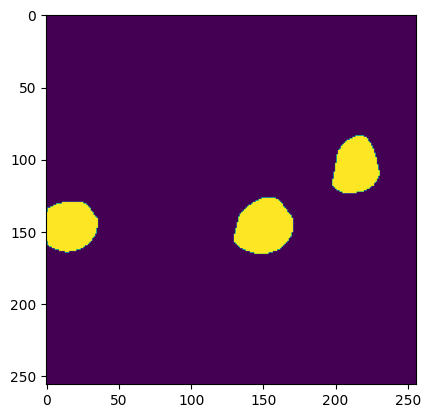

mask


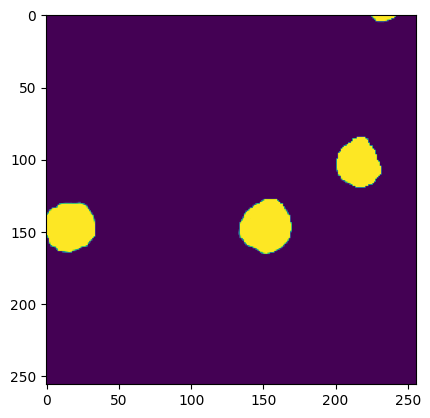

predict


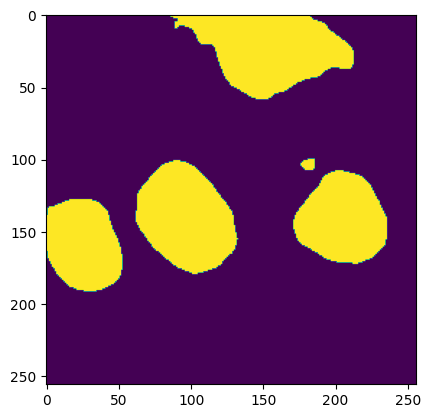

mask


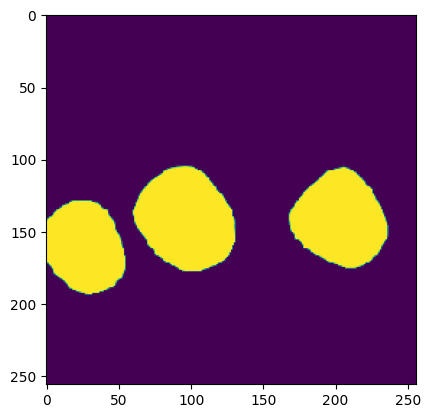

predict


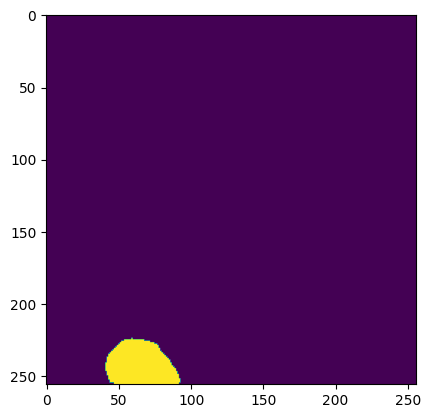

mask


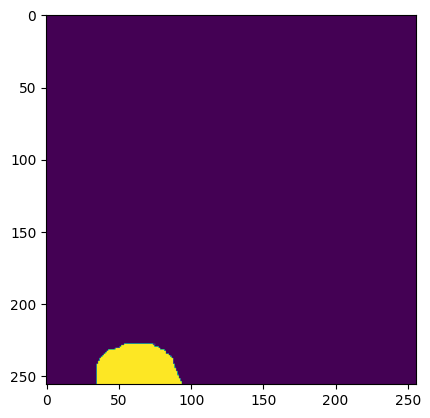

predict


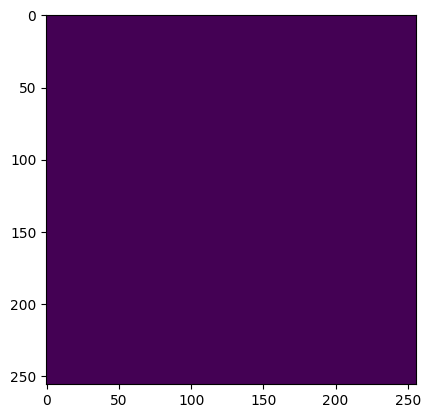

mask


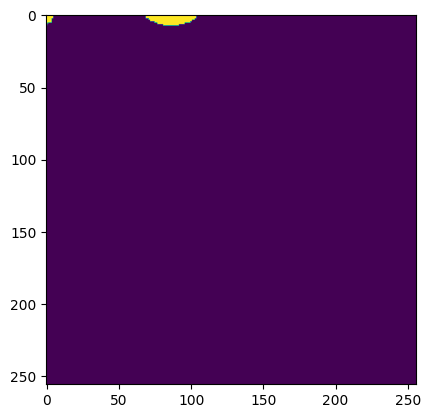

predict


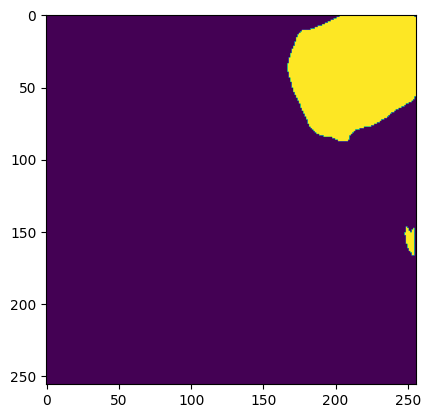

mask


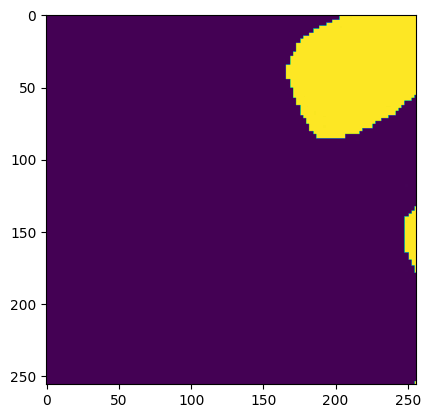

 45%|████▌     | 25/55 [13:44<16:22, 32.73s/it]

Validation:
	cost time: 5.3812255859375
epoch/iterator num: 25/81
	Run cost 0.012182 sec
IOU: 23.379817962646484, Dice: 1.922762393951416
-----------------------------------------
predict


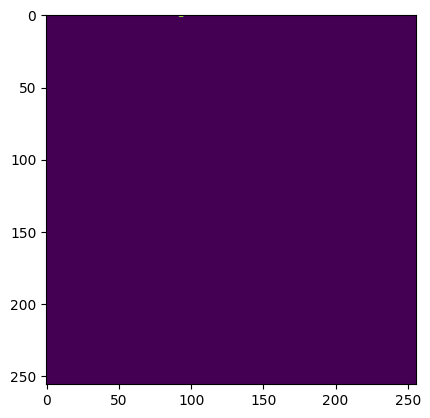

mask


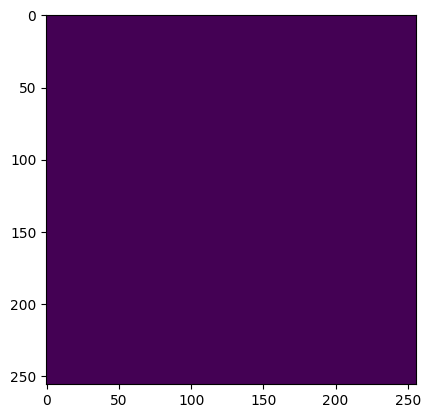

predict


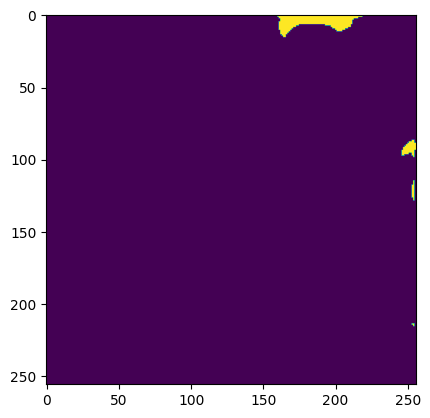

mask


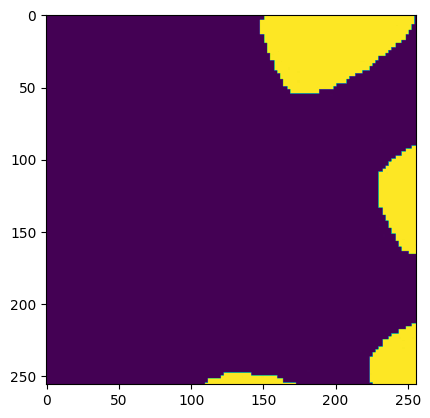

predict


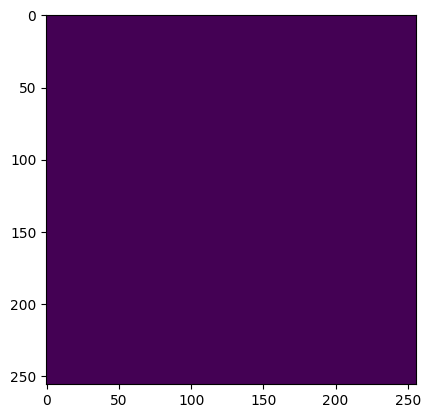

mask


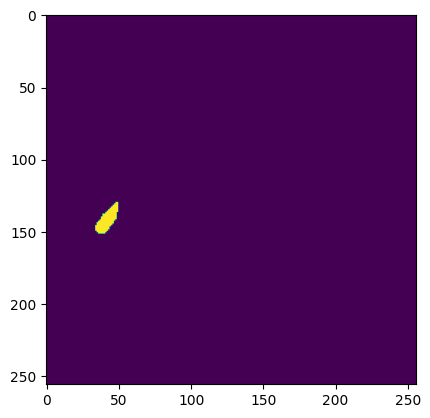

predict


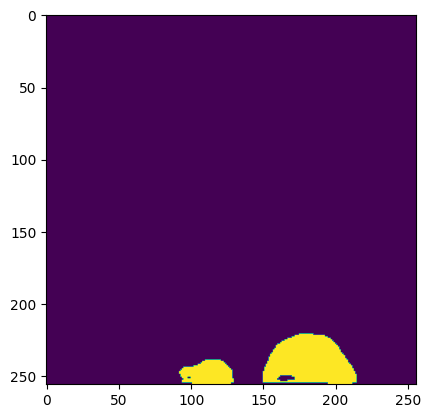

mask


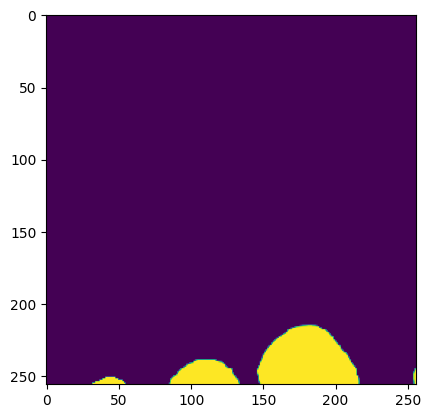

predict


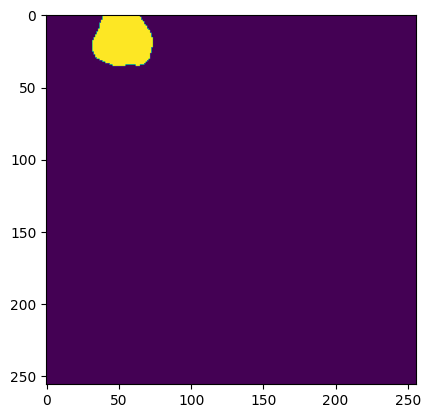

mask


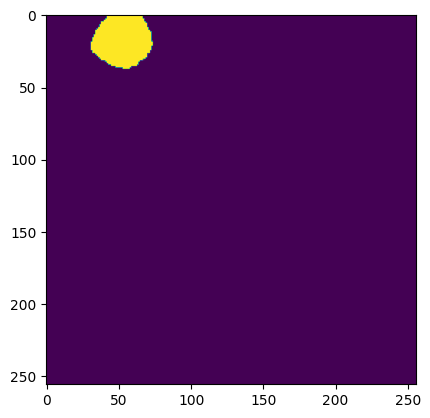

predict


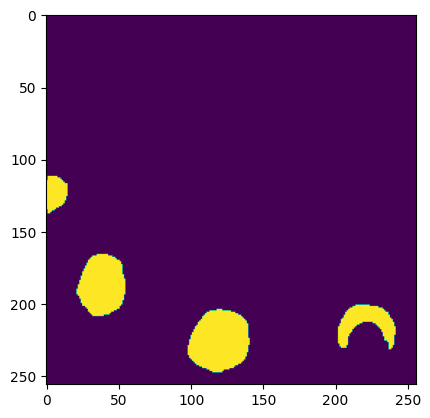

mask


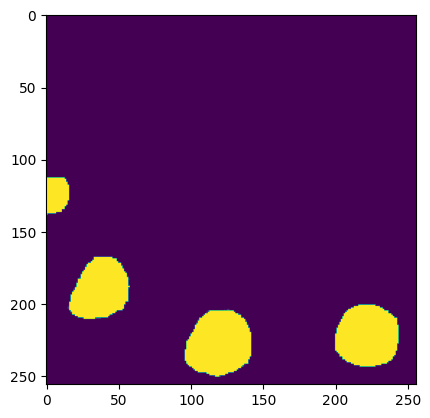

predict


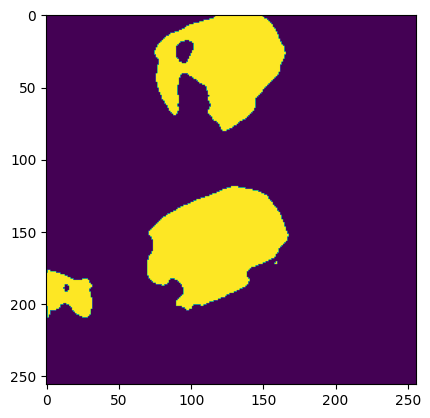

mask


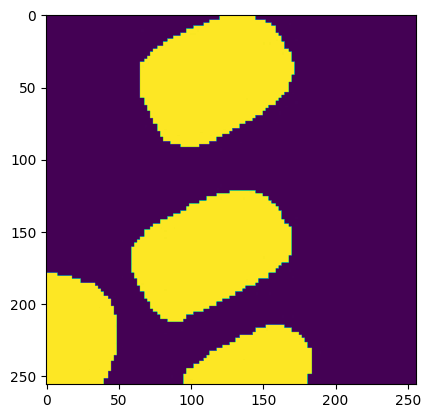

 47%|████▋     | 26/55 [14:17<15:48, 32.70s/it]

Validation:
	cost time: 5.114941835403442
epoch/iterator num: 26/84
	Run cost 0.011591 sec
IOU: 28.07221221923828, Dice: 1.943498134613037
-----------------------------------------
predict


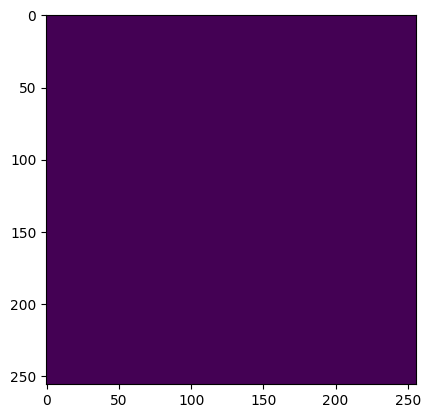

mask


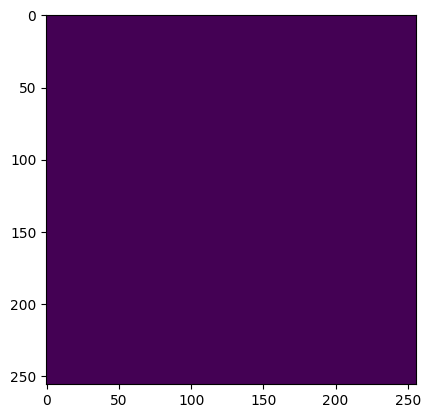

predict


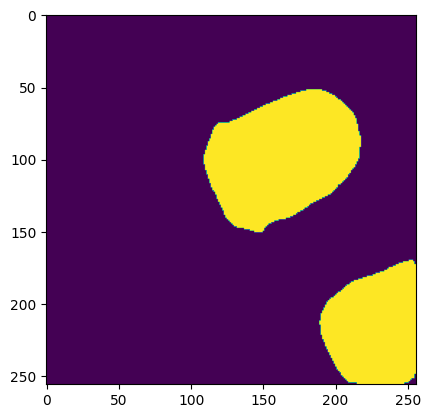

mask


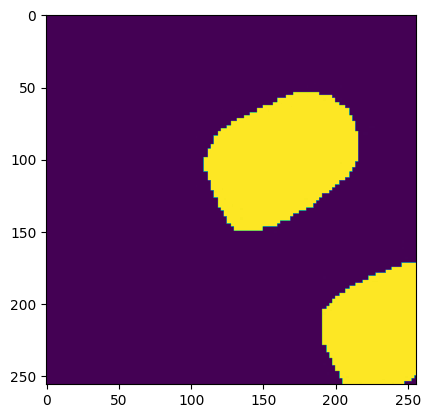

predict


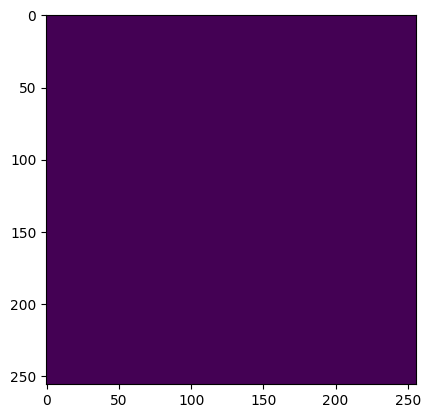

mask


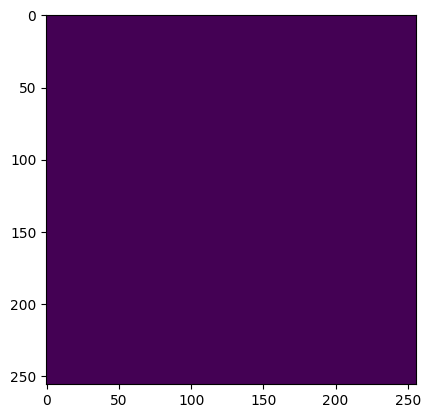

predict


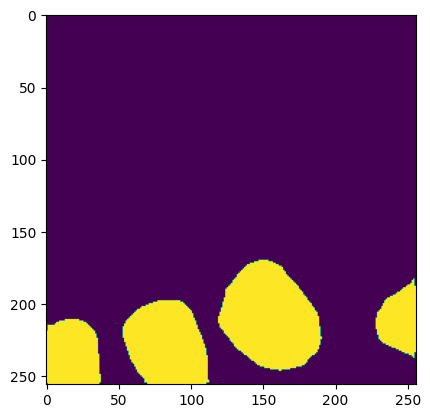

mask


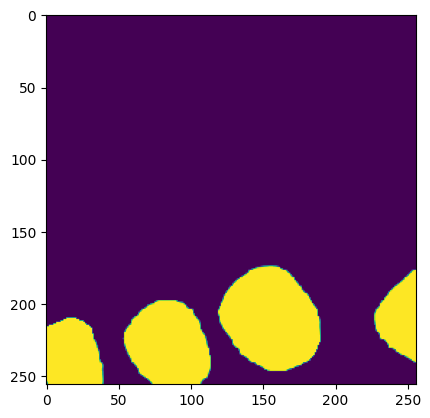

predict


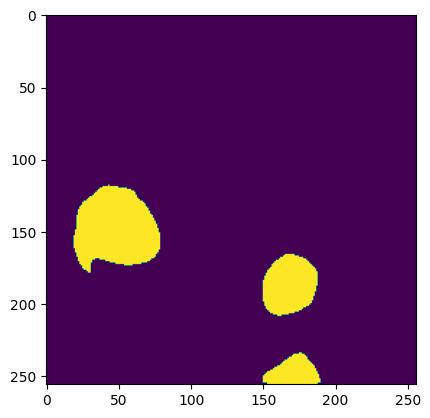

mask


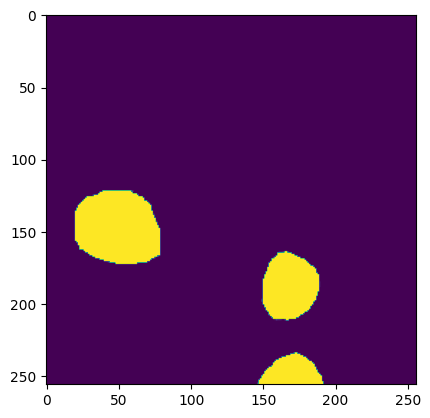

predict


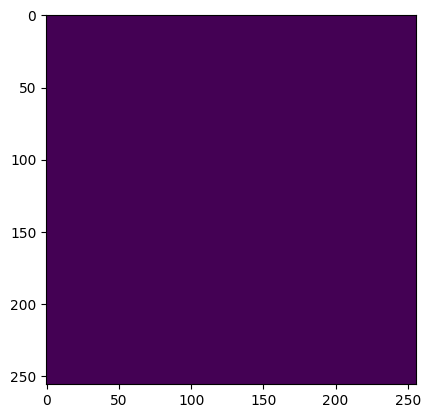

mask


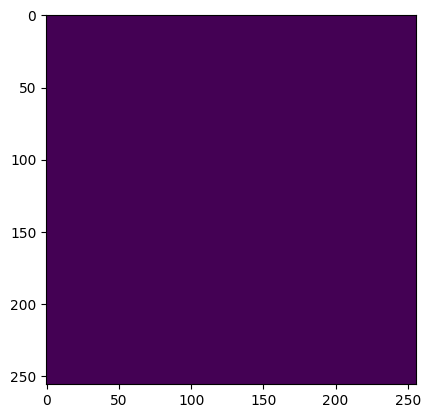

predict


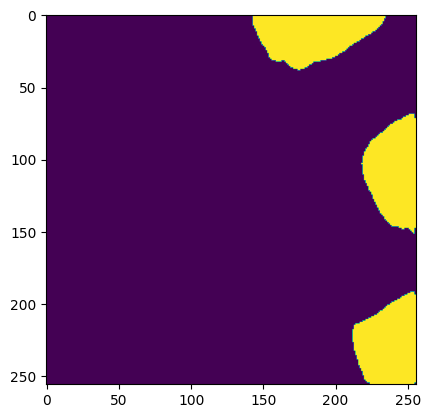

mask


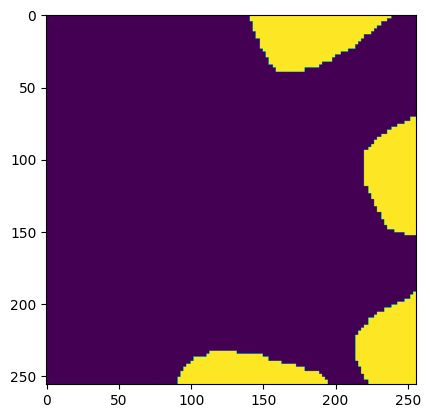

 49%|████▉     | 27/55 [14:49<15:10, 32.52s/it]

Validation:
	cost time: 5.1478166580200195
epoch/iterator num: 27/87
	Run cost 0.009029 sec
IOU: 24.032302856445312, Dice: 1.9227581024169922
-----------------------------------------
predict


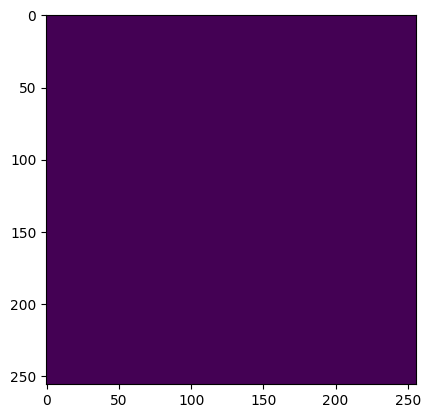

mask


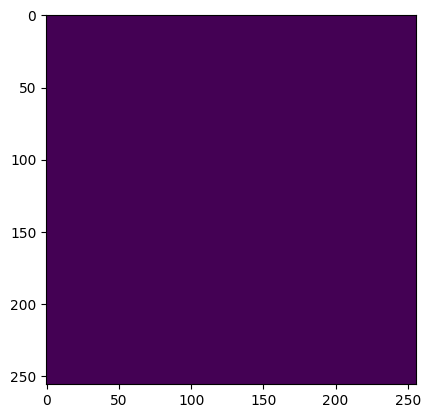

predict


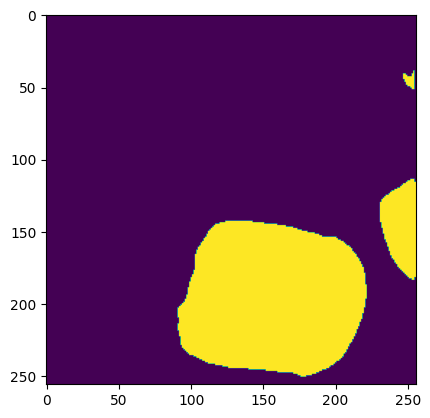

mask


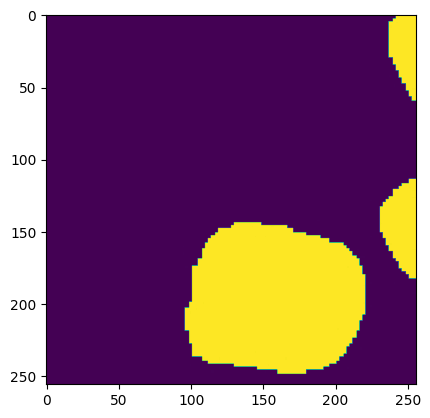

predict


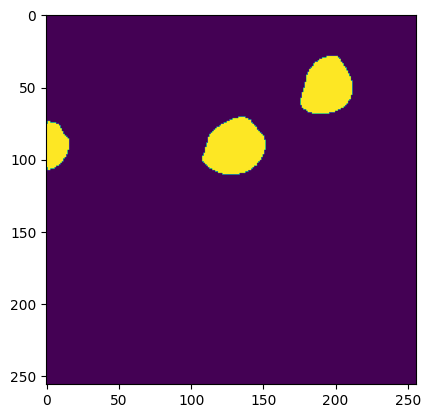

mask


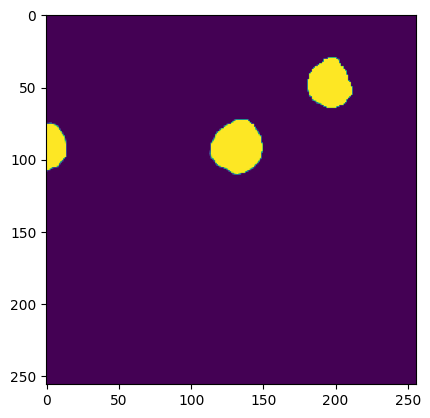

predict


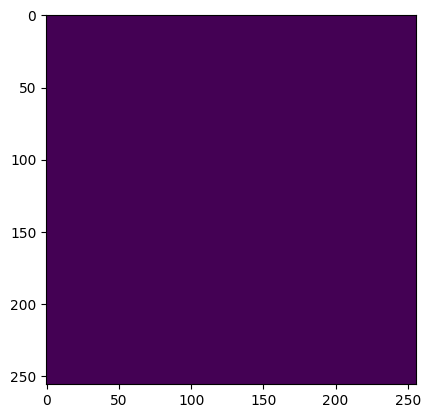

mask


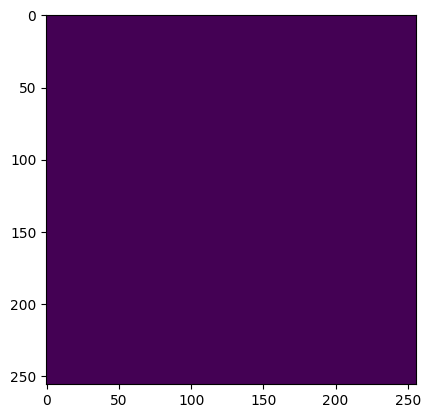

predict


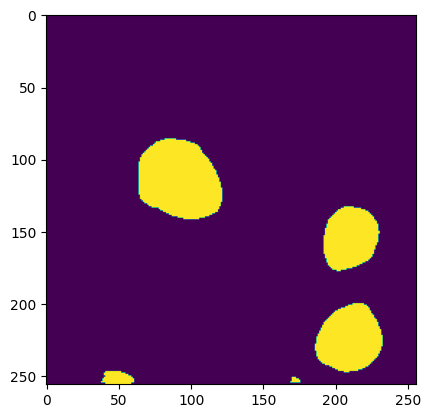

mask


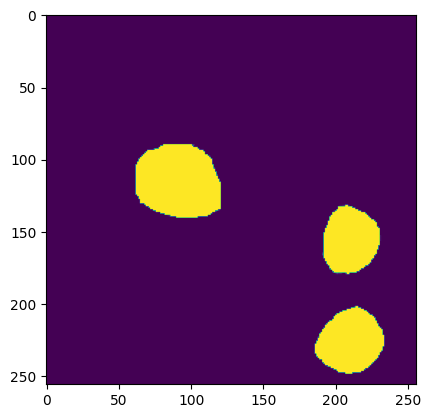

predict


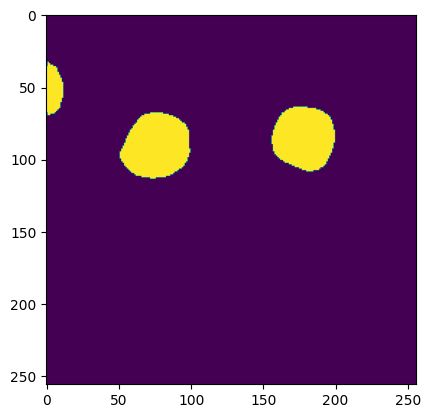

mask


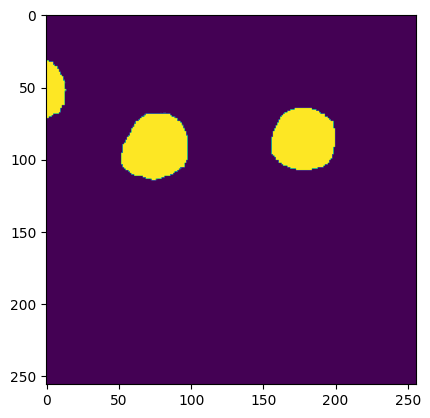

predict


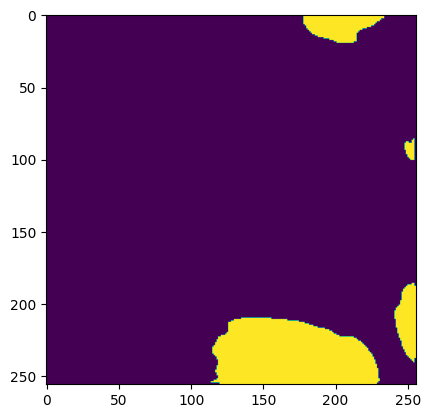

mask


Validation:
	cost time: 5.135030508041382
---------------SAVE MODEL-----------------
	Save model: 27
-----------------------------------------


 51%|█████     | 28/55 [15:22<14:43, 32.73s/it]

epoch/iterator num: 28/91
	Run cost 0.013824 sec
IOU: 19.250585556030273, Dice: 1.8792972564697266
-----------------------------------------
predict


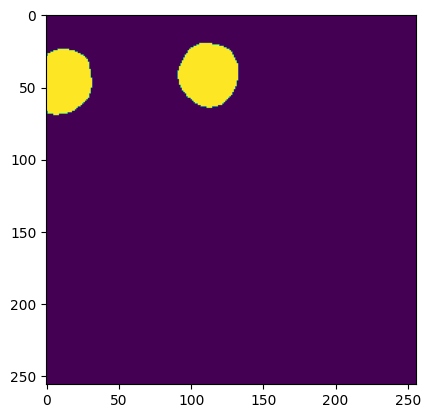

mask


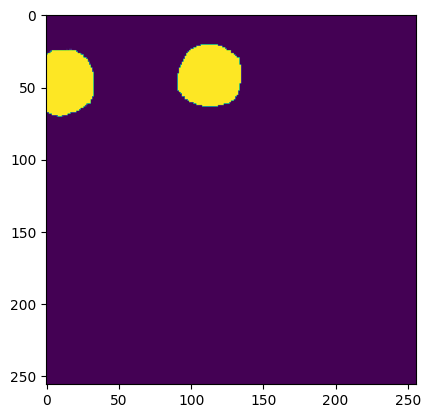

predict


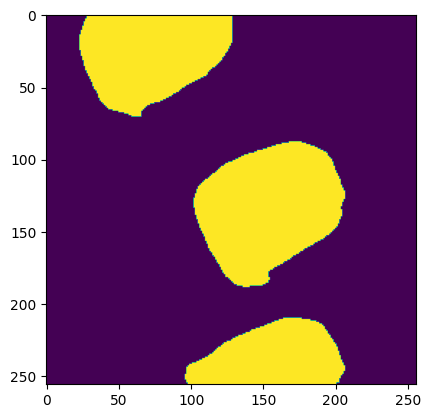

mask


predict


mask


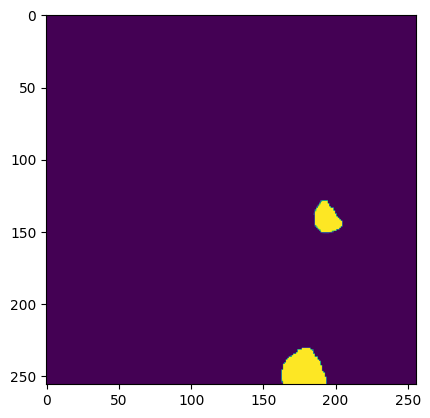

predict


mask


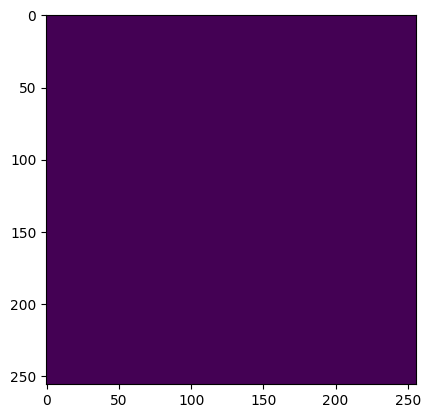

predict


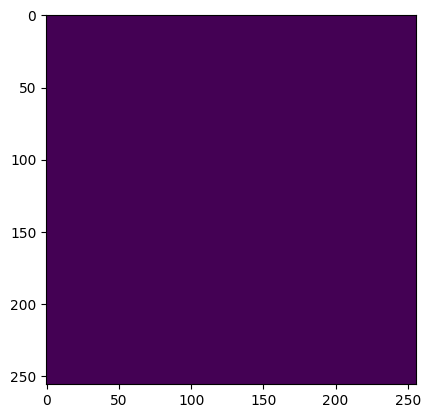

mask


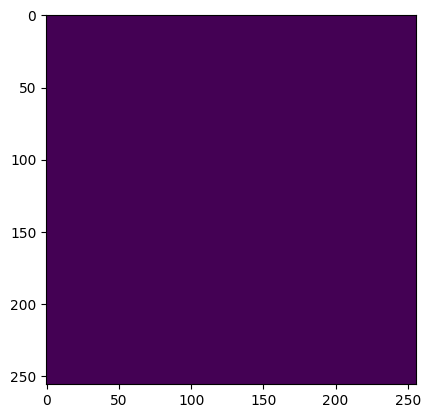

predict


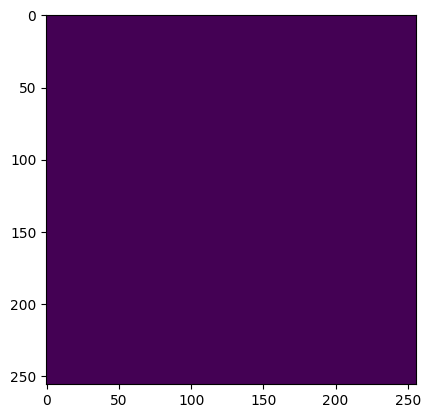

mask


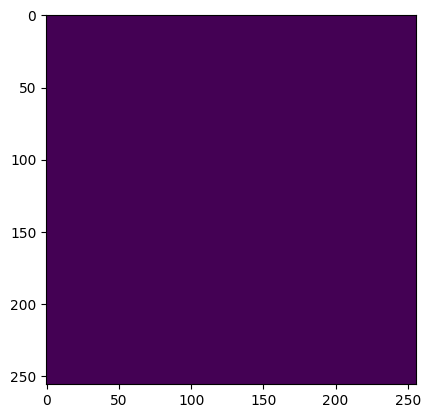

predict


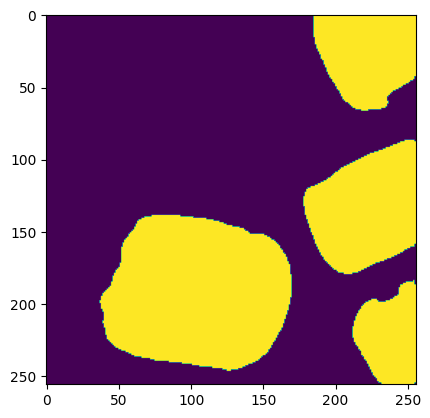

mask


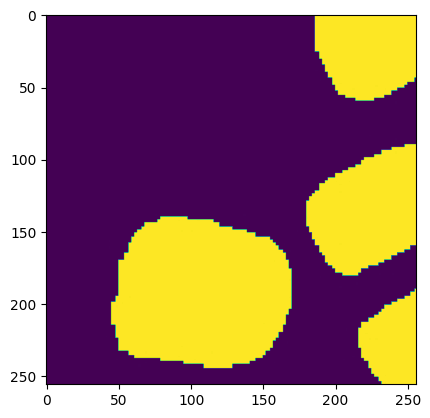

Validation:
	cost time: 5.016818523406982
---------------SAVE MODEL-----------------
	Save model: 28
-----------------------------------------


 53%|█████▎    | 29/55 [15:55<14:15, 32.92s/it]

epoch/iterator num: 29/94
	Run cost 0.008584 sec
IOU: 25.274824142456055, Dice: 1.9216126203536987
-----------------------------------------


 53%|█████▎    | 29/55 [16:06<14:26, 33.33s/it]


KeyboardInterrupt: 

In [34]:
# main
import wandb
from sklearn.metrics import jaccard_score
class Fingernails_segmentation():
    def __init__(self, config):
        super().__init__()

        self.config = config
        # setup logging & wandb
        self.init_setup()
        # self.set_wandb()

        # load model
        self.model = self.create_model()
        # self.model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
        self.model = self.model.to(self.device)
        # define optimizers and loss function
        self.hyperpara()
        self.loss_func()

        # load dataset
        self.load_data(self.config)

    def init_setup(self):
        self.global_step = 0
        self.val_step = 0
        self.global_val_loss = 1000
        self.mini_loss = np.inf
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.class_num = self.config['num_class']


    def set_wandb(self):
        # set wandb  = wandb
        # self.wandb = wandb.init(reinit=True)
        self.wandb.init(project=config['project_name'])
        self.wandb.config.train_batch_size = config['train_batch_size']
        self.wandb.config.val_batch_size = config['val_batch_size']
        self.wandb.config.save_path = config['save_path']
        self.wandb.config.lr = config['lr']


    def create_model(self):
        model = U_Net(img_ch = 3, output_ch=1 )

        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        model.to(self.device)
        return model


    def hyperpara(self):

        # optimizer for student
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['lr'])
        decay_rate = 0.99
        decay_steps = 300
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=decay_steps,
                                                         gamma=decay_rate)  # update every decay_steps steps

    def loss_func(self):
        # self.ce = nn.CrossEntropyLoss()
        self.ce = nn.BCEWithLogitsLoss()
        # self.ce = nn.BCELoss()
        self.dice = DiceLoss()

    def load_data(self, config):
        # load dataset
        dataset = MDataModule(config)
        self.train_loader = dataset.train_dataloader()
        self.test_loader = dataset.test_dataloader()
        self.val_loader = dataset.val_dataloader()


    def forward_step(self, batch):
        img, gt_mask = batch
        img = img.to(self.device)
        gt_mask = gt_mask.to(self.device)
        masks_pred = self.model(img)
        # dice_loss,acc =self.dice(masks_pred,torch.unsqueeze(gt_mask,dim=1))
        # dice_loss = self.dice(masks_pred.squeeze(1), gt_mask.float())[0]
        dice_loss = self.dice(masks_pred.squeeze(1), gt_mask.float())
        # ce_loss = self.ce(masks_pred,torch.unsqueeze(gt_mask,dim=1))
        # masks_pred = torch.sigmoid(masks_pred)
        # print("mask_pred",np.shape(masks_pred),"mask_sq",np.shape(masks_pred.squeeze(1)), "gt_mask",np.shape(gt_mask))
        ce_loss = self.ce(masks_pred.squeeze(1), gt_mask.float())
        # print("ce_loss ",ce_loss)
        loss =  ce_loss 

        return loss, masks_pred.squeeze(1), gt_mask, dice_loss

    def trainer(self):
        for iterator in tqdm(range(self.config['epoch'])):
            for step, batch in enumerate(self.train_loader):
                self.model.train()
                # zero the parameter gradients
                self.optimizer.zero_grad()
                # Training model by one batch.
                t_run_Start = time.time()
                loss, masks_pred, gt_mask, dice_loss = self.forward_step(batch)
                t_run_End = time.time()
                loss.backward()

                
                # write wandb
                masks_pred = torch.sigmoid(masks_pred)
                iou_score = IOU(gt_mask, masks_pred)
                dice_score = Dice_cofficient(gt_mask, masks_pred)


                # self.wandb.log({"train/crossentropy": loss.item(), "step": self.global_step})
                # self.wandb.log({"train/dice_score": dice_score, "step": self.global_step})
                # self.wandb.log({"lr": self.optimizer.param_groups[0]['lr'], "step": self.global_step})
                # self.wandb.log({"train/IOU": iou_score, "step": self.global_step})

                if step % 100 == 0:
                    string = str(step + int(self.global_step / self.config['train_batch_size']))
                    print(f'epoch/iterator num: {iterator}/{string}' )
                    print("\tRun cost %f sec" % (t_run_End - t_run_Start))

                    # save_metric(loss,P, N, TP, TN, FP, FN)
                    print(f"IOU: {iou_score}, Dice: {dice_score}")
                    print('-----------------------------------------')

                self.global_step += 1
                self.optimizer.step()
                # self.scheduler.step()

            # validation every epoch
            strat = time.time()

            l_ = 0
            val_iou = 0
            val_dice = 0
            val_len = len(self.val_loader)
            self.SAVE_MODEL = self.config['save_model']
            for step, batch in enumerate(self.val_loader):
                # Testing batch data(Validation).
                val_loss, val_pred, val_gt = self.validation(batch)

                l_ += val_loss
                val_pred = torch.sigmoid(val_pred)
                iou_score = IOU(val_gt, val_pred)
                dice_score = Dice_cofficient(val_gt, val_pred)
                
                val_iou += iou_score
                val_dice += dice_score
                
            # self.show_image(val_pred[0],val_gt[0])
            # self.show_image(val_pred[1],val_gt[1])
            
            end = time.time()

            print('Validation:')
            print('\tcost time: ' + str(end - strat))
            # write to wandb
            # self.wandb.log({"val/val_loss": l_/val_len, "epoch": iterator})
            # self.wandb.log({"val/val_IOU": val_iou/val_len, "epoch": iterator})
            # self.wandb.log({"val/val_Dice": val_dice/val_len, "epoch": iterator})

            if iterator == 0 and self.global_val_loss == 0:
                train_batch_size = self.config['train_batch_size']
                # save best weight
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                }, self.SAVE_MODEL + "/" + "best_model.pt")
                print("------SAVE INITIAL WEIGHT-------")
                self.global_val_loss = l_

            if l_ < self.global_val_loss :
                print('---------------SAVE MODEL-----------------')
                # Save model.
                print('\tSave model: ' + str(iterator))
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                }, self.SAVE_MODEL + "/" + "model.ckpt-" + str(iterator)+ ".ckpt")

                self.global_val_loss = l_
                print('-----------------------------------------')
                # save best weight
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                }, self.SAVE_MODEL + "/" + "best_model.ckpt")

    def show_image(self,pred, mask):
        def reverse_transform(inp):
            inp = inp.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            inp = (inp * 255).astype(np.uint8)
            return inp
        
        pred = torch.sigmoid(pred)
        pred = pred.cpu().numpy()
        pred  = pred.astype(np.uint8)
        print("predict")
        plt.imshow(pred)
        plt.show()
        
        
        gt_mask = mask.cpu().numpy()
        gt_mask = gt_mask.astype(np.uint8)
        print("mask")
        plt.imshow(gt_mask)
        plt.show()
    
    
    def validation(self,batch):
        self.model.eval()
        with torch.no_grad():
            loss, masks_pred, gt_mask, dice_loss = self.forward_step(batch)
            # self.wandb.log({"Val/loss": loss, "step": self.global_step})
        self.show_image(masks_pred[0],gt_mask[0])
        
        
        return loss, masks_pred, gt_mask

if __name__ == '__main__':

    # config
    config = {
        'data_root': 'kaggle/',
        'seed': 2021,
        'train_batch_size':16,
        'val_batch_size':16,
        'increase_factor':20,
        'save_path':'',
        'project_name':'Fingernails',
        'save_model':'LOGS',
        'lr':1e-4,
        'num_class':1,
        'epoch':55
    }

    seed = config['seed']
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    t_Start = time.time()
    Fingernails_segmentation(config).trainer()
    print("Finish Training: ", time.time() - t_Start)

# Validation 

train num:  10
(402, 402, 3)
(494, 494, 3)
(1067, 1600, 3)
(452, 452, 3)
(886, 1446, 3)
(361, 361, 3)
(702, 702, 3)
(503, 503, 3)
(256, 256, 3)


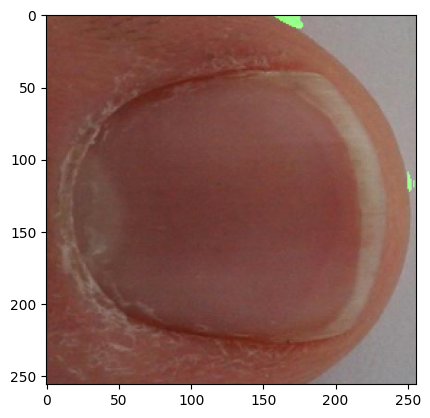

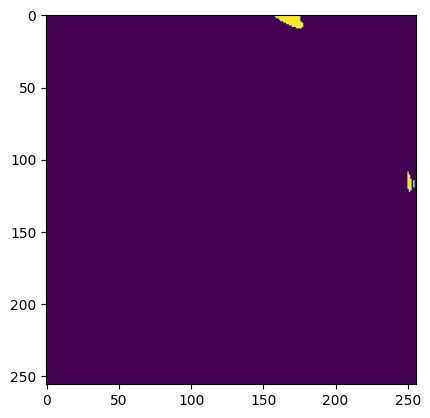

(256, 256, 3)


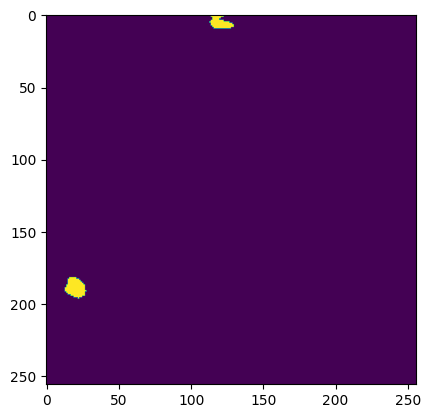

(256, 256, 3)


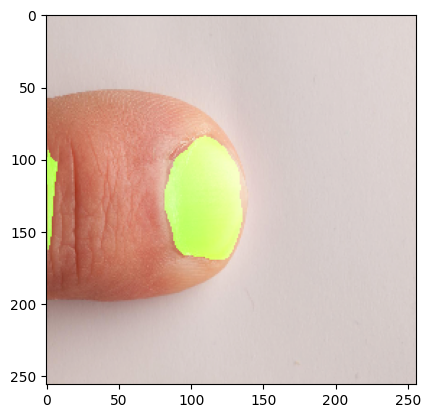

(256, 256, 3)


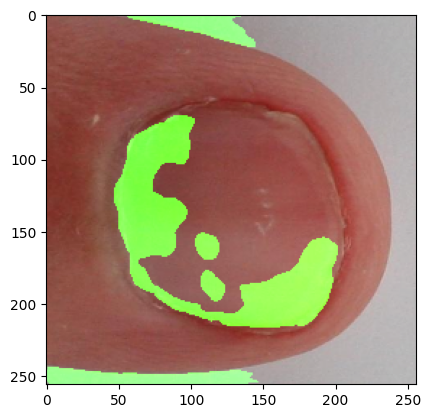

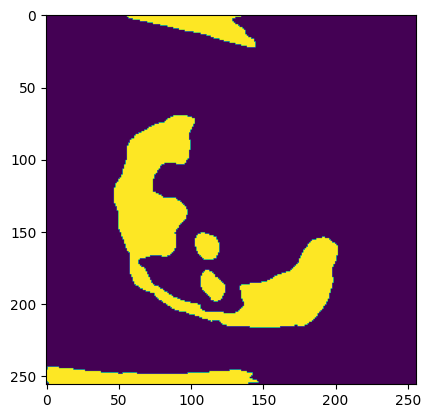

(256, 256, 3)


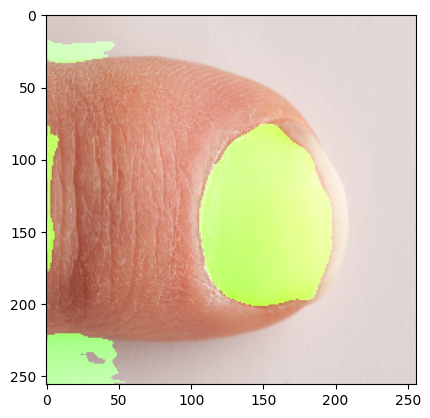

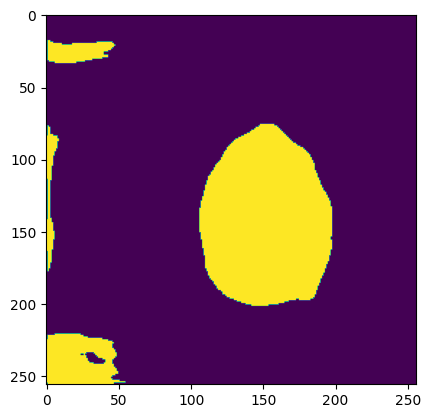

(256, 256, 3)


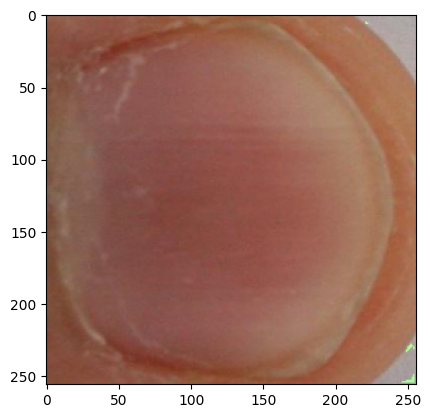

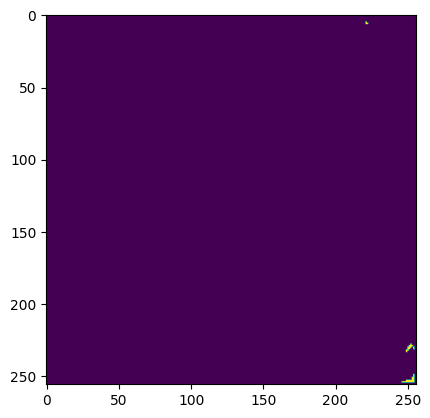

(256, 256, 3)


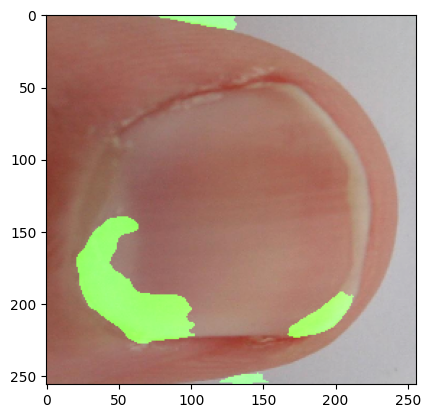

(256, 256, 3)


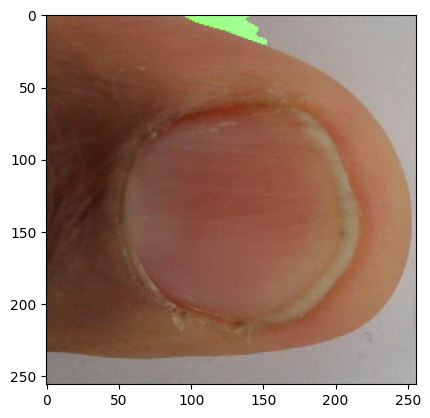

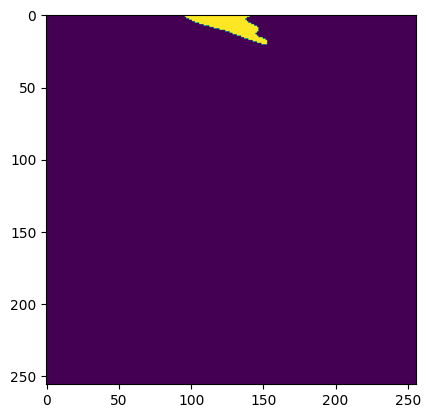

(335, 335, 3)
(403, 403, 3)
(256, 256, 3)


(256, 256, 3)


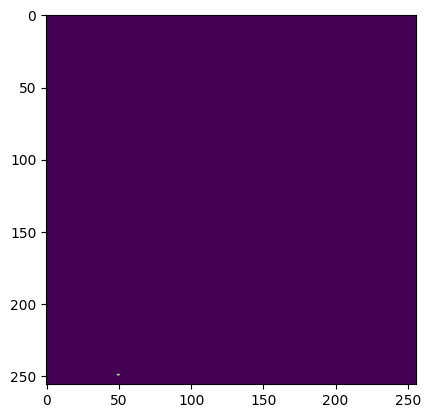

In [77]:
# inference
test_image_root = "kaggle/test/"
save_path = ''
model = U_Net(img_ch = 3, output_ch= 1)
ckpt = torch.load("LOGS/best_model.ckpt")
model.load_state_dict(ckpt['model_state_dict'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# test_case
class Fingernails(Dataset):
    def __init__(self, config, data_list, transform):
        super().__init__()
        # print(self.datas)
        self.config = config
        self.transform = transform
        self.data_list = data_list
        self.total_len = len(self.data_list)
        self.trans = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])
        print("train num: ", self.total_len)

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        img_path  = self.data_list[idx]
        img = self.get_data(img_path)
        print(img.shape)
        # img = self.get_data(image_path, mask_path)

        if self.transform is not None:
            augmentations = self.transform(image=img)
            img = augmentations['image']
            img = self.trans(img)
            # img = img.permute((2, 0, 1))
        return img

    def get_data(self, img_path):
        img = cv.imread(img_path)
    
        return img
    
def read_data(path:str):
    # read all data
    data_list = []
    for l in os.listdir(path):
        if l.endswith('.jpg'):
            data_list.append(test_image_root + l)
    random.shuffle(data_list)
    num_files = len(data_list)

    return data_list
    

def forward_step(batch, model):
    img = batch
    img = img.cuda()
    masks_pred = model(img)
    return img.squeeze(1), masks_pred.squeeze(1)

def show_image(img, pred):
    def reverse_transform(inp):
        inp = inp.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        inp = (inp * 255).astype(np.uint8)
        return inp
    
    pred = torch.sigmoid(pred)
    pred = pred.cpu().numpy()
    img = img.cpu().numpy()
    img = reverse_transform(img)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
    print(img.shape)
    pred  = pred.astype(np.uint8)
    img[:,:, 1] = np.where(pred == 1, 255, img[:,:, 1])
    # img[:,:, 2] = img[:,:, 2]  pred * 255
    plt.imshow(img)
    plt.show()

    plt.imshow(pred)
    plt.show()


def test(loader, model):
    model.eval()
    for batch in loader:
        with torch.no_grad():
            img, masks_pred = forward_step(batch, model)
            # self.wandb.log({"Val/loss": loss, "step": self.global_step})
        for i in range(len(batch)):
            show_image(img[i], masks_pred[i])
            
test_transform = A.Compose(
        [   
            # A.SmallestMaxSize(max_size=512),
            # A.RandomCrop(width=256, height=256),
            A.Resize(256, 256),
            # A.RandomCrop(width=224, height=224),
        ])

data_list = read_data(test_image_root)
test_dataset = Fingernails(config, data_list, test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers= 0, shuffle=False)
# test_loader  = dataset.test_dataset()
test(test_loader, model)